# 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import matplotlib.image as mpimg
import glob

In [39]:
def display(img1, img2, img3, img4, label1, label2, label3, label4):
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(label1, fontsize=30)
    ax2.imshow(img2)
    ax2.set_title(label2, fontsize=30)
    ax3.imshow(img3)
    ax3.set_title(label3, fontsize=30)
    ax4.imshow(img4)
    ax4.set_title(label4, fontsize=30)
    img5 = img4
    ax5.imshow(img5)
    ax5.set_title('Lane Lines', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
def remove_dist(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


def sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


def binary_acc_to_combined_threshold(image):
    grad_binary = sobel_thresh(image, orient='x', sobel_kernel=3, thresh_min=30, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30,100))
    dir_binary = dir_thresh(image, sobel_kernel=3, thresh=(0.7, 1.4))
    
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(grad_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    hls_binary = hls_select(image, thresh=(170, 255))

    combined = np.zeros_like(combined_binary)
    combined[(hls_binary == 1) | (combined_binary == 1)] = 1

    color_binary = np.dstack(( np.zeros_like(hls_binary), combined_binary, hls_binary)) * 255

    return combined, color_binary


def transform_image(img):     
    img_size = (img.shape[1], img.shape[0])
    offset = 100

    left_top  = [568,470]
    right_top = [720,470]
    left_bottom  = [260,680]
    right_bottom = [1050,680]

    src = np.float32([left_top, left_bottom, right_top, right_bottom])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)

    return warped, M


def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]//2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
    nwindows = 9
    margin = 100
    minpix = 30

    window_height = np.int(binary_warped.shape[0]//nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial_from_prev(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
     
    return left_fit_new, right_fit_new


def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    plt.imshow(out_img)
    
#     plt.savefig("output_images_lane_lines/" + "hello" + file_name)
    return out_img, left_fit, right_fit


def measure_curvature_real(warped, left_fit_cr, right_fit_cr):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    y_eval = np.max(ploty)
    print(y_eval, left_fit_cr, right_fit_cr)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad


def visualisation(warped, left_fit, right_fit, image, undist):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = np.linalg.inv(M)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#     plt2.imshow(result)
    return result


In [40]:
nx = 9
ny = 6
objpoints = []
imgpoints = []
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

images = glob.glob("camera_cal/calibration*.jpg")

for image in images:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [41]:
img = cv2.imread('camera_cal/calibration1.jpg')
undist = remove_dist(img, mtx, dist)
file_name = image.split('/')[1]
cv2.imwrite("camera_cal_output/" + file_name,undist)
# display(img, undist, 'Original Image', 'Undistorted Image')

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


719.0 [ 1.73921112e-04 -1.88143064e-01  3.10932326e+02] [ 6.64525495e-05 -1.13471908e-01  1.10897300e+03]
3012.1414457484225 7659.871441068453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


719.0 [-1.27800172e-05 -1.39504249e-02  1.76128413e+02] [ 1.41461094e-04 -1.59907352e-01  1.08174870e+03]
39136.287896344125 3656.8135227935136


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


719.0 [ 4.08227164e-05 -9.26651507e-03  2.53770440e+02] [ 5.37543836e-05 -5.00863421e-03  1.05914840e+03]
12248.937232168131 9301.611587028036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


719.0 [ 7.89472854e-05 -7.88077457e-02  2.52535855e+02] [ 1.02467751e-04 -9.91812221e-02  1.06413215e+03]
6385.542508493603 4943.083009691842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


719.0 [ 1.43980177e-04 -1.56788341e-01  2.84546748e+02] [ 1.42514655e-04 -1.65249404e-01  1.08818854e+03]
3587.673764664135 3638.4415024023583


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


719.0 [-8.18027093e-05  1.02288814e-01  2.39049219e+02] [-7.92190377e-05  7.73710168e-02  9.90080590e+02]
6199.428881355291 6361.614100463604


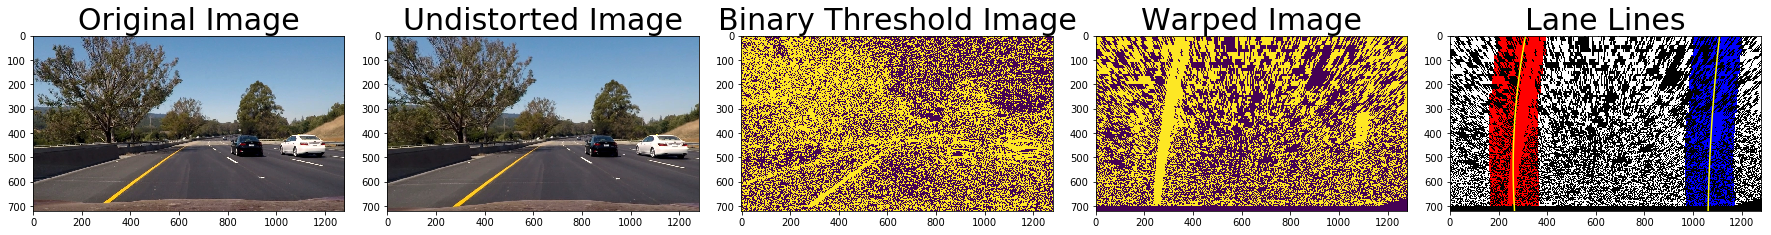

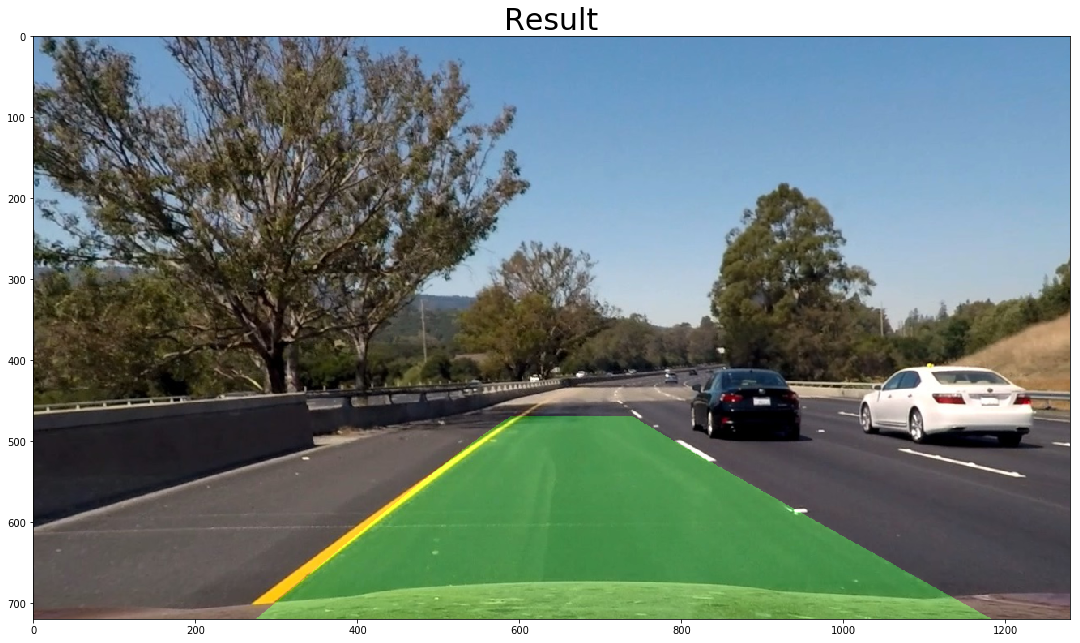

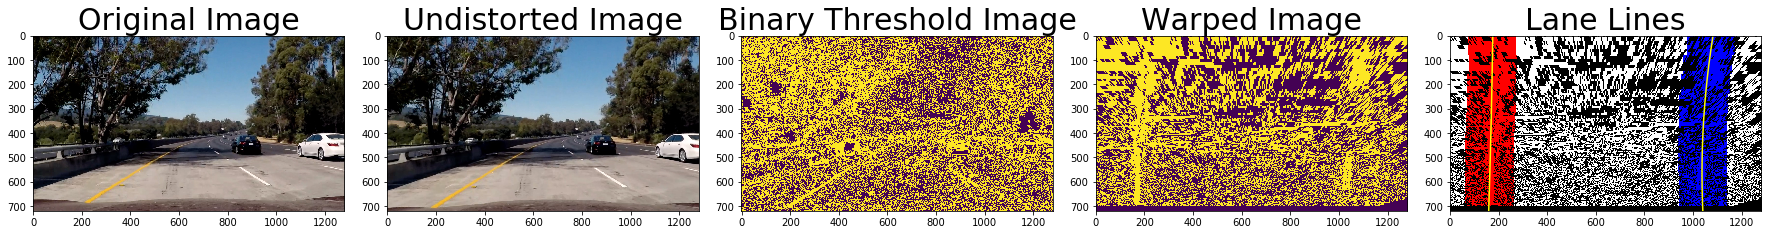

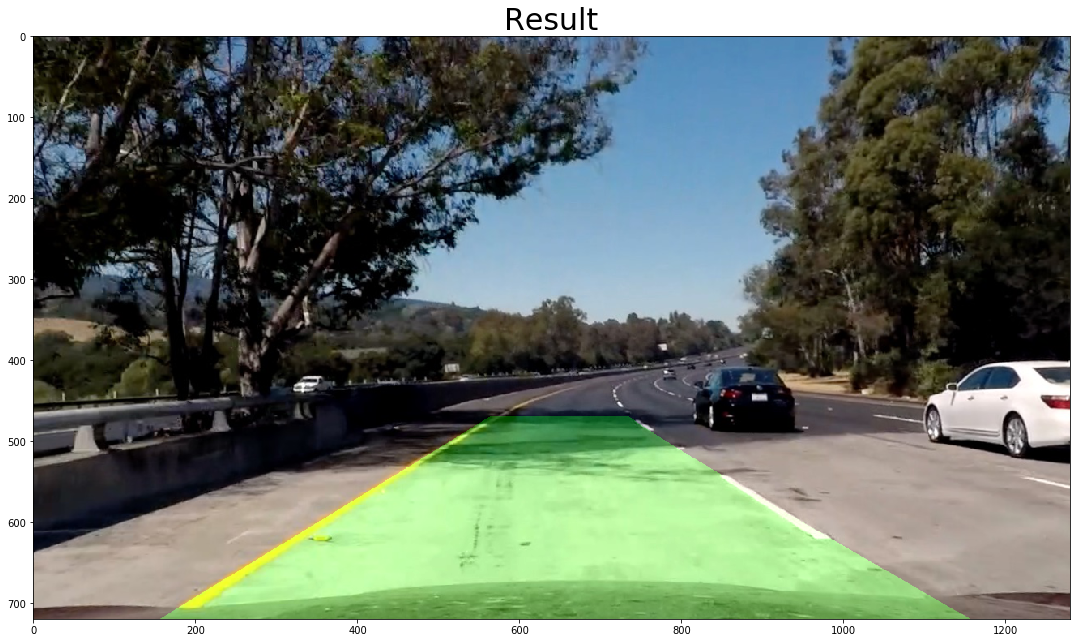

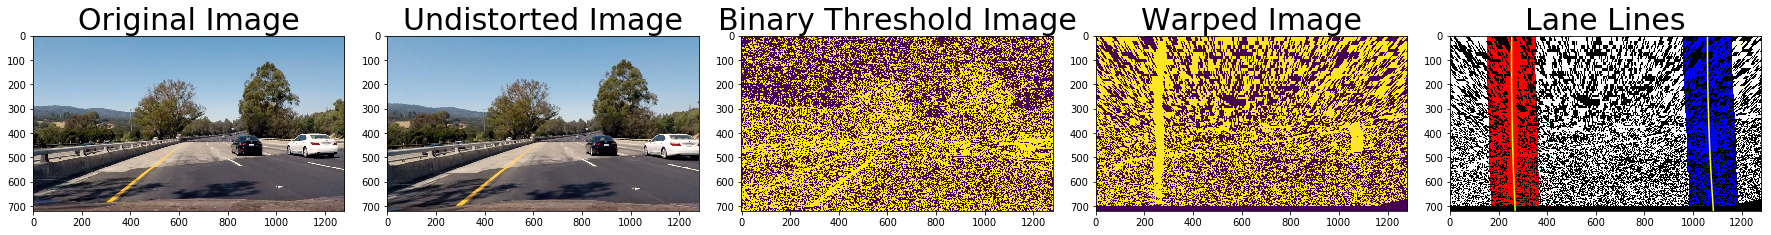

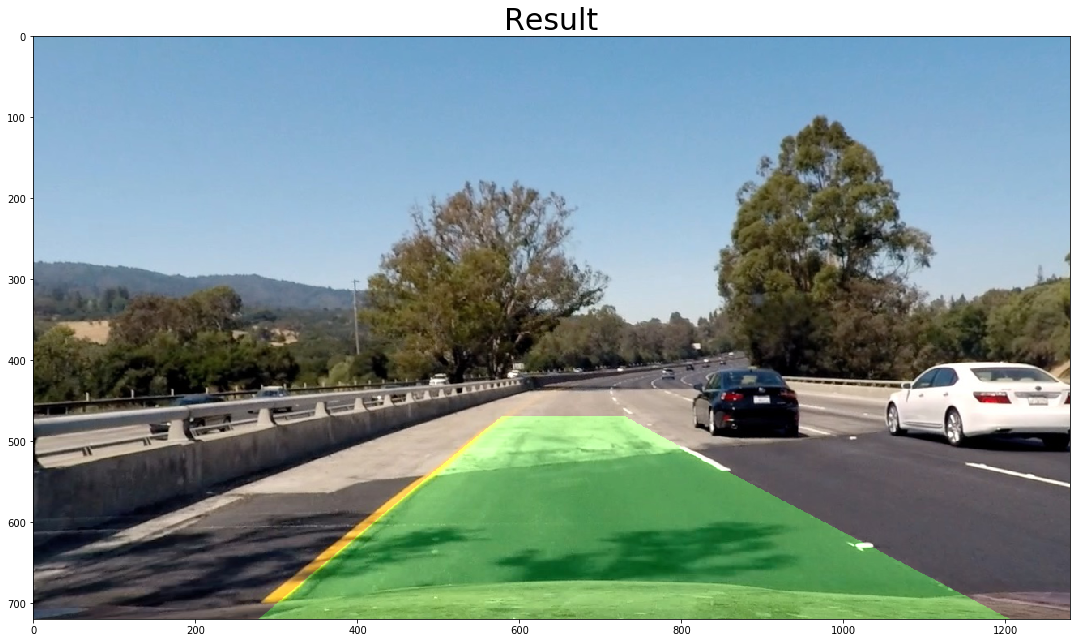

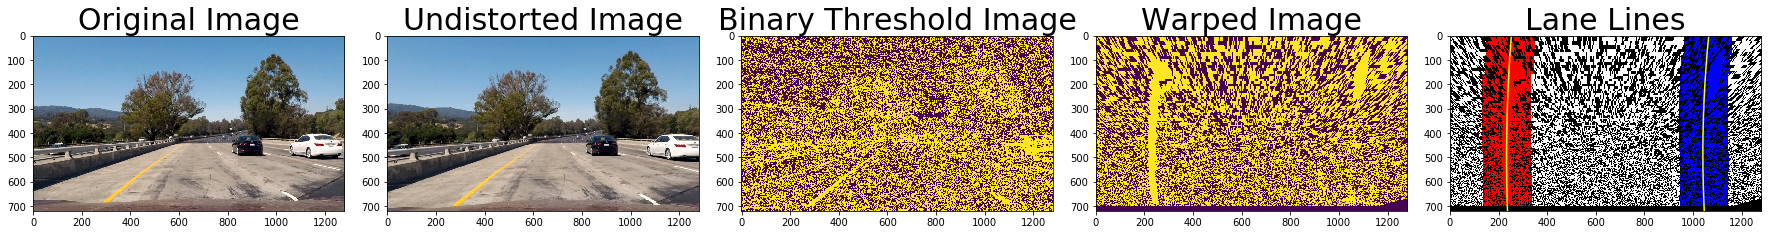

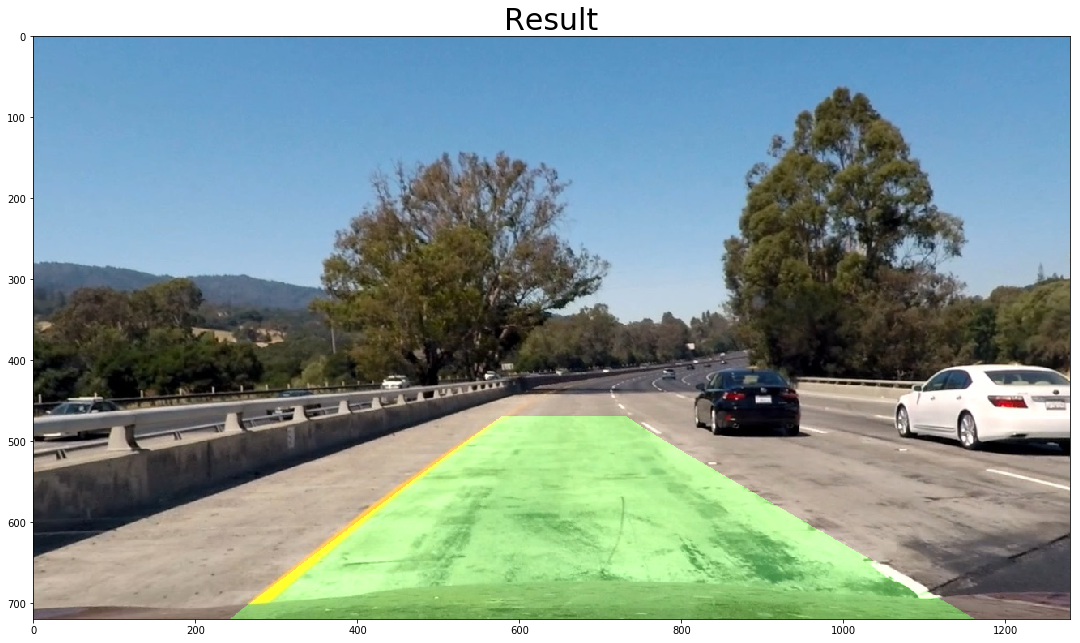

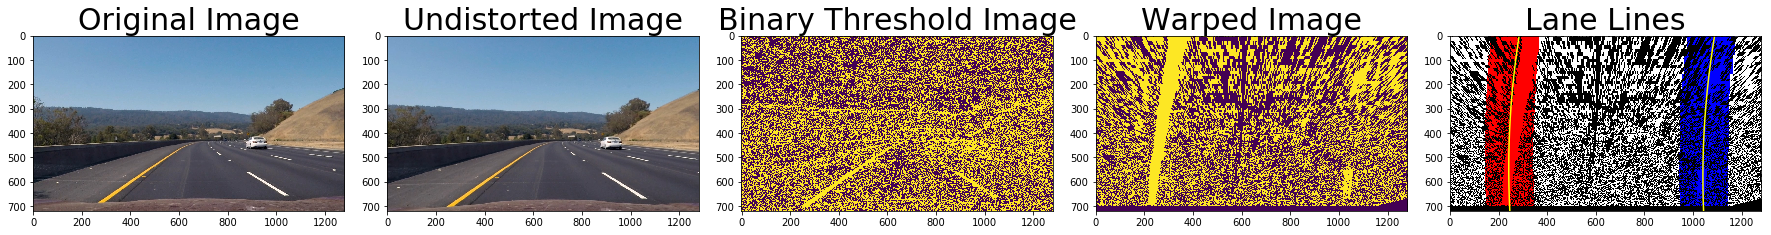

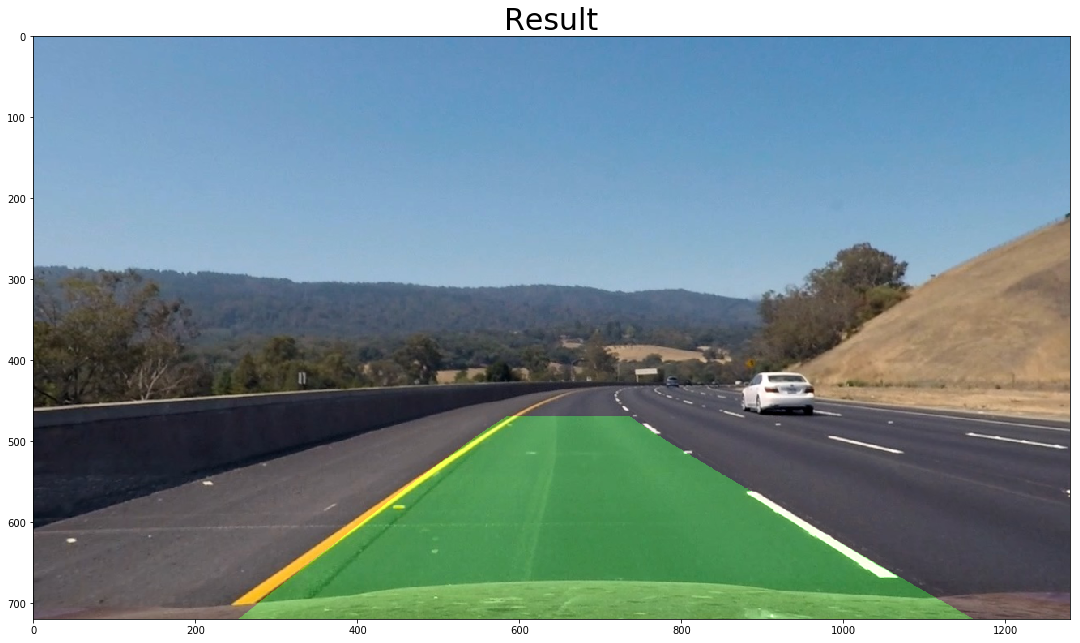

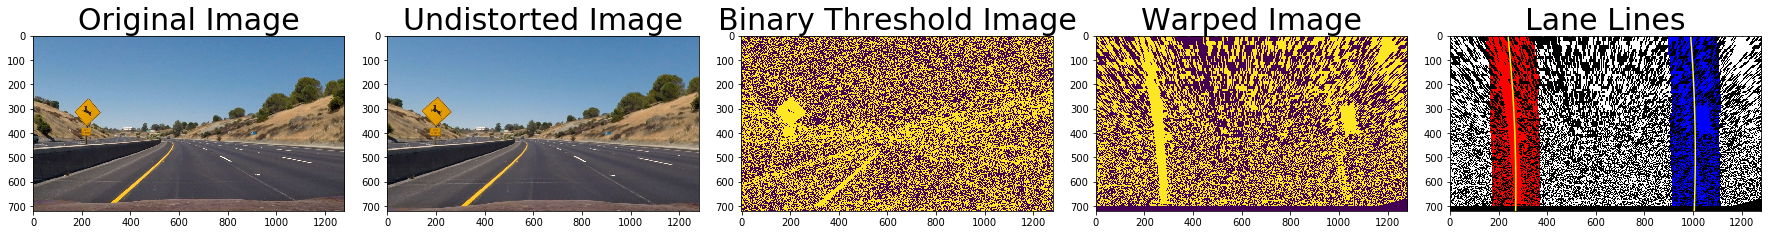

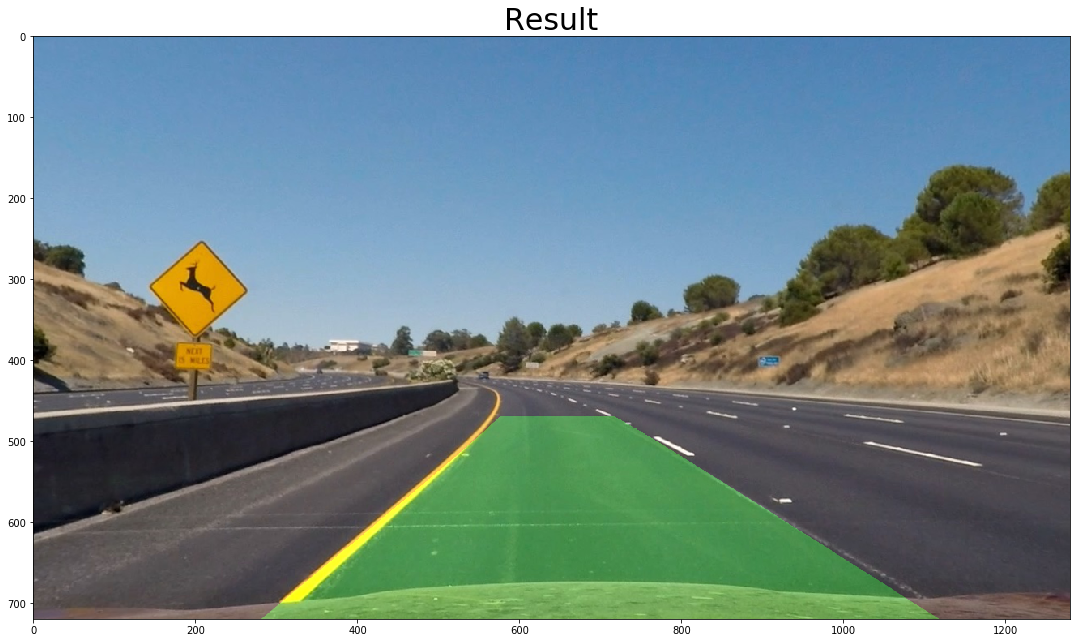

In [42]:
images = glob.glob("test_images/test*.jpg")

for image in images:
    file_name = image.split('/')[1]
    image = mpimg.imread(image)
    
    undist = remove_dist(image, mtx, dist)
    undistorted = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    cv2.imwrite("output_images_undistorted/" + file_name,undistorted)
    
    combined, color_binary = binary_acc_to_combined_threshold(undist)
    cv2.imwrite("output_images_binary/" + file_name,color_binary)
    
    warped, M = transform_image(combined)
    cv2.imwrite("output_images_bird_view/" + file_name,warped)
    
    display(image,undist,combined,warped,'Original Image','Undistorted Image','Binary Threshold Image','Warped Image')
    out_img, left_fit, right_fit = fit_polynomial(warped)
    cv2.imwrite("output_images_lane_lines/" + file_name,out_img)
    
    lc, rc = measure_curvature_real(warped, left_fit, right_fit)
    print(lc, rc)

    result = visualisation(warped, left_fit, right_fit, image, undist)
    
    f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(result)
    ax1.set_title('Result', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [53]:
class Lane():
    def __init__(obj):
        obj.left_fit = None
        obj.right_fit = None
        obj.left_fit_prev = None
        obj.right_fit_prev = None
        obj.counter = 0
        obj.reset = 0
        
        
def is_good_to_go(left_fit, right_fit):
    
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        ploty = np.linspace(0, 30, num=10 )
        y = 680
        left_fitx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
        right_fitx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
        diff = np.absolute(right_fitx - left_fitx)
        print('diff: ')
        print(diff)
        if diff < 700:
            status = False
        else:
            status = True
#         if diff >= 150 and diff <=425: 
#             status = True
#         else:
#             status = False
        
#         # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
#         left = 2*left_fit[0]*360+left_fit[1]
#         right = 2*right_fit[0]*360+right_fit[1]
#         delta_slope_mid =  np.abs(left-right)
        
#         #Check if lines are parallel at the middle
#         if delta_slope_mid <= 0.1:
#             status = True
#         else:
#             status = False
            
    return status


def process_image(image):
    
    undist = remove_dist(image, mtx, dist)
    combined, color_binary = binary_acc_to_combined_threshold(undist)
    warped, M = transform_image(combined)
    
    print('counter: ')
    print(lane.counter)
    
    if lane.counter==0:
        out_img, lane.left_fit, lane.right_fit = fit_polynomial(warped)
    else:
        lane.left_fit, lane.right_fit = fit_polynomial_from_prev(lane.left_fit, lane.right_fit, warped)
            
    status = is_good_to_go(lane.left_fit, lane.right_fit)
    
    print('status: ')
    print(status)
    
    if status==True:
        lane.left_fit_prev,lane.right_fit_prev = lane.left_fit, lane.right_fit
        lane.counter += 1
    else:
        lane.left_fit, lane.right_fit = lane.left_fit_prev, lane.right_fit_prev
#         out_img, lane.left_fit, lane.right_fit = fit_polynomial(warped)
        
    lc, rc = measure_curvature_real(warped, lane.left_fit, lane.right_fit)
    result = visualisation(warped, lane.left_fit, lane.right_fit, image, undist)
        

#     out_img, left_fit, right_fit = fit_polynomial(warped)
#     lc, rc = measure_curvature_real(warped, left_fit, right_fit)
#     result = visualisation(warped, left_fit, right_fit, image, undist)
        
    return result


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


counter: 
0
diff: 
808.1128415955884
status: 
True
719.0 [-1.22713806e-04  1.58481758e-01  2.16776577e+02] [-7.59002345e-05  7.37077374e-02  1.06088916e+03]
[MoviePy] >>>> Building video output_video/output_video.mp4
[MoviePy] Writing video output_video/output_video.mp4


  0%|          | 1/1261 [00:00<05:39,  3.71it/s]

counter: 
1
diff: 
803.5915485552532
status: 
True
719.0 [-9.74390687e-05  1.51929762e-01  2.11623746e+02] [-8.67525498e-05  8.08433534e-02  1.05861261e+03]


  0%|          | 2/1261 [00:00<05:12,  4.03it/s]

counter: 
2
diff: 
798.1412905285046
status: 
True
719.0 [-8.78241756e-05  1.55318960e-01  2.06720212e+02] [-1.16632308e-04  1.02035493e-01  1.05441514e+03]
counter: 
3


  0%|          | 3/1261 [00:00<04:52,  4.30it/s]

diff: 
794.5799989450204
status: 
True
719.0 [-1.14264893e-04  1.83521587e-01  2.00147486e+02] [-1.49462987e-04  1.28783765e-01  1.04822480e+03]
counter: 
4
diff: 
792.7446786178025
status: 
True
719.0 [-1.42444667e-04  2.09839148e-01  1.95307743e+02] [-1.70325598e-04  1.47249709e-01  1.04350538e+03]


  0%|          | 5/1261 [00:01<04:18,  4.86it/s]

counter: 
5
diff: 
792.1966916832826
status: 
True
719.0 [-1.42686676e-04  2.13451711e-01  1.94204159e+02] [-1.96662457e-04  1.76444766e-01  1.03652397e+03]
counter: 
6
diff: 
793.010855035858
status: 
True
719.0 [-1.64639936e-04  2.35646613e-01  1.89980850e+02] [-1.96348668e-04  1.83718229e-01  1.03296512e+03]


  1%|          | 7/1261 [00:01<03:53,  5.38it/s]

counter: 
7
diff: 
793.8175575670671
status: 
True
719.0 [-1.83022398e-04  2.58187249e-01  1.84255059e+02] [-1.96152446e-04  1.94383393e-01  1.02753057e+03]
counter: 
8
diff: 
791.7225459005035
status: 
True
719.0 [-1.72318101e-04  2.60172885e-01  1.81620466e+02] [-1.77461666e-04  1.86284206e-01  1.02596570e+03]


  1%|          | 9/1261 [00:01<03:39,  5.69it/s]

counter: 
9
diff: 
792.8354628598561
status: 
True
719.0 [-1.43441839e-04  2.41422409e-01  1.83505725e+02] [-1.03645762e-04  1.34111619e-01  1.03091082e+03]
counter: 
10


  1%|          | 11/1261 [00:02<03:37,  5.74it/s]

diff: 
792.701642184408
status: 
True
719.0 [-1.37127284e-04  2.44015770e-01  1.80628123e+02] [-4.43745194e-05  9.08687464e-02  1.03458086e+03]
counter: 
11
diff: 
791.3185047188042
status: 
True
719.0 [-1.14948079e-04  2.34853552e-01  1.78689388e+02] [-9.06375825e-06  6.78275433e-02  1.03462467e+03]


  1%|          | 12/1261 [00:02<03:38,  5.71it/s]

counter: 
12
diff: 
789.1331744030806
status: 
True
719.0 [-1.05266850e-04  2.35566417e-01  1.74231105e+02] [-7.78937502e-06  6.99356668e-02  1.03091961e+03]
counter: 
13


  1%|          | 13/1261 [00:02<03:53,  5.35it/s]

diff: 
788.1009248672926
status: 
True
719.0 [-9.06186392e-05  2.31274212e-01  1.70697075e+02] [-2.54224467e-06  6.95568179e-02  1.02803930e+03]
counter: 
14
diff: 
786.214311752741
status: 
True
719.0 [-9.37497095e-05  2.34835015e-01  1.68961616e+02] [-2.38464903e-05  9.18692230e-02  1.02006942e+03]


  1%|          | 15/1261 [00:02<03:51,  5.39it/s]

counter: 
15
diff: 
783.8602149934454
status: 
True
719.0 [-1.03504647e-04  2.43199952e-01  1.67264971e+02] [-5.70399867e-05  1.20699166e-01  1.01294046e+03]
counter: 
16


  1%|▏         | 16/1261 [00:02<03:50,  5.40it/s]

diff: 
781.7274607357804
status: 
True
719.0 [-1.13134008e-04  2.46364474e-01  1.68242546e+02] [-5.32147001e-05  1.16275592e-01  1.01072376e+03]
counter: 
17
diff: 
781.2562400177778
status: 
True
719.0 [-1.18787212e-04  2.51226979e-01  1.66439784e+02] [-5.25679156e-05  1.18205850e-01  1.00753059e+03]


  1%|▏         | 18/1261 [00:03<03:48,  5.44it/s]

counter: 
18
diff: 
781.4182483328004
status: 
True
719.0 [-1.41655616e-04  2.67474273e-01  1.64102159e+02] [-6.35978262e-05  1.29457331e-01  1.00327800e+03]
counter: 
19


  2%|▏         | 19/1261 [00:03<03:43,  5.56it/s]

diff: 
780.0023861168806
status: 
True
719.0 [-1.20975076e-04  2.54443366e-01  1.63859373e+02] [-7.83611847e-05  1.50662688e-01  9.94727958e+02]
counter: 
20
diff: 
779.6238757306186
status: 
True
719.0 [-1.16490193e-04  2.51069019e-01  1.63184724e+02] [-7.99759035e-05  1.55229293e-01  9.91095406e+02]


  2%|▏         | 21/1261 [00:03<03:56,  5.25it/s]

counter: 
21
diff: 
776.418112079212
status: 
True
719.0 [-9.84283102e-05  2.41356255e-01  1.61837648e+02] [-8.10306008e-05  1.58593087e-01  9.86490014e+02]
counter: 
22


  2%|▏         | 23/1261 [00:04<03:42,  5.56it/s]

diff: 
776.5275304247375
status: 
True
719.0 [-1.01759958e-04  2.49900210e-01  1.56499026e+02] [-6.65212617e-05  1.45963854e-01  9.87408905e+02]
counter: 
23
diff: 
774.8301640737916
status: 
True
719.0 [-7.20807206e-05  2.26634839e-01  1.57723212e+02] [-7.46319574e-05  1.48785777e-01  9.86670430e+02]


  2%|▏         | 24/1261 [00:04<03:40,  5.60it/s]

counter: 
24
diff: 
774.7749452001029
status: 
True
719.0 [-8.04259753e-05  2.30856546e-01  1.56374882e+02] [-9.25919102e-05  1.61659967e-01  9.83829030e+02]
counter: 
25


  2%|▏         | 25/1261 [00:04<03:44,  5.51it/s]

diff: 
774.3247119276741
status: 
True
719.0 [-7.60985459e-05  2.23768372e-01  1.57300944e+02] [-1.28398637e-04  1.90326460e-01  9.78549718e+02]
counter: 
26
diff: 
773.3578723258203
status: 
True
719.0 [-5.99002653e-05  2.09559210e-01  1.57929063e+02] [-1.81413978e-04  2.31890359e-01  9.72289695e+02]


  2%|▏         | 27/1261 [00:04<03:40,  5.59it/s]

counter: 
27
diff: 
778.6760195325018
status: 
True
719.0 [-5.48002372e-05  1.99951934e-01  1.59773591e+02] [-1.96092014e-04  2.52235111e-01  9.68230367e+02]
counter: 
28
diff: 
784.2870470410096
status: 
True
719.0 [-5.81765160e-05  2.02537301e-01  1.57009825e+02] [-1.91741501e-04  2.53375085e-01  9.68487628e+02]


  2%|▏         | 29/1261 [00:05<04:00,  5.13it/s]

counter: 
29
diff: 
789.2991075064028
status: 
True
719.0 [-6.74894087e-05  2.04429682e-01  1.57690570e+02] [-1.95425945e-04  2.63626999e-01  9.65893357e+02]


  2%|▏         | 30/1261 [00:05<04:14,  4.84it/s]

counter: 
30
diff: 
795.4420978311931
status: 
True
719.0 [-9.78814779e-05  2.23285674e-01  1.56037783e+02] [-1.56166647e-04  2.36170019e-01  9.69669588e+02]


  2%|▏         | 31/1261 [00:05<04:36,  4.44it/s]

counter: 
31
diff: 
798.0420841816182
status: 
True
719.0 [-9.94684919e-05  2.17050425e-01  1.59983671e+02] [-1.31737508e-04  2.22213224e-01  9.69436244e+02]


  3%|▎         | 32/1261 [00:06<04:20,  4.71it/s]

counter: 
32
diff: 
798.9789792383181
status: 
True
719.0 [-9.83689797e-05  2.09272685e-01  1.64303817e+02] [-1.03459840e-04  2.05257235e-01  9.68367316e+02]
counter: 
33


  3%|▎         | 34/1261 [00:06<03:51,  5.30it/s]

diff: 
800.4899710761107
status: 
True
719.0 [-1.32144331e-04  2.34205770e-01  1.61311259e+02] [-8.29791163e-05  1.90162802e-01  9.69016453e+02]
counter: 
34
diff: 
798.9511230683108
status: 
True
719.0 [-1.26280159e-04  2.27793085e-01  1.63492244e+02] [-6.43825757e-05  1.75196423e-01  9.69587654e+02]


  3%|▎         | 35/1261 [00:06<04:03,  5.04it/s]

counter: 
35
diff: 
796.8505119199825
status: 
True
719.0 [-1.30068740e-04  2.26571681e-01  1.66166478e+02] [-5.38325397e-05  1.63157571e-01  9.70886966e+02]


  3%|▎         | 36/1261 [00:06<04:04,  5.01it/s]

counter: 
36
diff: 
791.4906503014611
status: 
True
719.0 [-1.25830936e-04  2.21193733e-01  1.69490437e+02] [-8.16848895e-05  1.81432107e-01  9.67605862e+02]
counter: 
37


  3%|▎         | 37/1261 [00:07<03:58,  5.12it/s]

diff: 
786.4164223467171
status: 
True
719.0 [-1.47945261e-04  2.37859174e-01  1.69294866e+02] [-1.24281109e-04  2.13797837e-01  9.61130694e+02]
counter: 
38


  3%|▎         | 39/1261 [00:07<03:53,  5.24it/s]

diff: 
785.0260533201382
status: 
True
719.0 [-1.86333062e-04  2.67320846e-01  1.66512413e+02] [-1.39471581e-04  2.28932999e-01  9.55973453e+02]
counter: 
39
diff: 
782.4725128625472
status: 
True
719.0 [-2.07083826e-04  2.84090626e-01  1.66028691e+02] [-1.47246376e-04  2.41145062e-01  9.50035349e+02]


  3%|▎         | 40/1261 [00:07<03:46,  5.40it/s]

counter: 
40
diff: 
780.6533252241652
status: 
True
719.0 [-2.38506013e-04  3.11171266e-01  1.62452538e+02] [-1.68416772e-04  2.61212354e-01  9.44668658e+02]
counter: 
41


  3%|▎         | 41/1261 [00:07<03:48,  5.35it/s]

diff: 
782.0764107820396
status: 
True
719.0 [-2.53193098e-04  3.25264168e-01  1.59816828e+02] [-1.68234407e-04  2.68981434e-01  9.40880598e+02]
counter: 
42


  3%|▎         | 42/1261 [00:07<03:55,  5.17it/s]

diff: 
784.5446710085748
status: 
True
719.0 [-2.75580670e-04  3.41957666e-01  1.58376592e+02] [-1.73789427e-04  2.83175648e-01  9.35824764e+02]
counter: 
43


  3%|▎         | 43/1261 [00:08<04:13,  4.81it/s]

diff: 
785.4328799575576
status: 
True
719.0 [-2.56690855e-04  3.28822490e-01  1.60085706e+02] [-1.64899434e-04  2.86934304e-01  9.31558199e+02]
counter: 
44


  3%|▎         | 44/1261 [00:08<04:22,  4.63it/s]

diff: 
786.4536536912923
status: 
True
719.0 [-2.52502073e-04  3.30047929e-01  1.57884218e+02] [-1.49090322e-04  2.74262621e-01  9.34454288e+02]
counter: 
45


  4%|▎         | 45/1261 [00:08<04:18,  4.71it/s]

diff: 
785.4398428375758
status: 
True
719.0 [-2.38774721e-04  3.24542444e-01  1.56213603e+02] [-1.65031213e-04  2.87089489e-01  9.33022458e+02]
counter: 
46
diff: 
783.696425583302
status: 
True
719.0 [-2.48085758e-04  3.34806434e-01  1.53371224e+02] [-1.62747581e-04  2.79295982e-01  9.35354383e+02]


  4%|▎         | 47/1261 [00:09<04:05,  4.95it/s]

counter: 
47
diff: 
779.6692612717013
status: 
True
719.0 [-2.36111595e-04  3.29749965e-01  1.51695460e+02] [-1.87139525e-04  2.92445642e-01  9.34086975e+02]
counter: 
48


  4%|▍         | 48/1261 [00:09<04:03,  4.99it/s]

diff: 
774.640475125854
status: 
True
719.0 [-2.09580945e-04  3.11125155e-01  1.53306362e+02] [-2.05988951e-04  3.00083663e-01  9.33794114e+02]
counter: 
49


  4%|▍         | 49/1261 [00:09<04:13,  4.79it/s]

diff: 
773.1536208705917
status: 
True
719.0 [-2.07680253e-04  3.13873035e-01  1.50908169e+02] [-2.13774217e-04  3.01685070e-01  9.35167455e+02]
counter: 
50
diff: 
769.4027784042898
status: 
True
719.0 [-1.95452784e-04  3.10811230e-01  1.48427483e+02] [-2.37871870e-04  3.15371097e-01  9.34344137e+02]


  4%|▍         | 51/1261 [00:09<04:06,  4.91it/s]

counter: 
51
diff: 
768.0732319977626
status: 
True
719.0 [-1.72445631e-04  2.97626586e-01  1.47775517e+02] [-2.42855675e-04  3.19543744e-01  9.33502686e+02]
counter: 
52


  4%|▍         | 52/1261 [00:10<04:02,  4.98it/s]

diff: 
769.0329823300406
status: 
True
719.0 [-1.96172204e-04  3.22847776e-01  1.42057154e+02] [-2.30404584e-04  3.15579303e-01  9.31861750e+02]
counter: 
53


  4%|▍         | 53/1261 [00:10<04:10,  4.81it/s]

diff: 
768.469779874652
status: 
True
719.0 [-1.91491236e-04  3.23697562e-01  1.40651816e+02] [-2.25801014e-04  3.16725956e-01  9.29727130e+02]
counter: 
54
diff: 
772.2054629318998
status: 
True
719.0 [-2.02671528e-04  3.37015220e-01  1.36356962e+02] [-2.02432578e-04  3.09780850e-01  9.26971306e+02]


  4%|▍         | 55/1261 [00:10<04:08,  4.85it/s]

counter: 
55
diff: 
777.4260939511548
status: 
True
719.0 [-2.03858364e-04  3.38025209e-01  1.34807646e+02] [-1.66718224e-04  2.92513483e-01  9.26008112e+02]


  4%|▍         | 56/1261 [00:10<04:15,  4.72it/s]

counter: 
56
diff: 
777.0581863416055
status: 
True
719.0 [-1.76084950e-04  3.19334427e-01  1.35275620e+02] [-1.57499803e-04  2.85214056e-01  9.26941886e+02]


  5%|▍         | 57/1261 [00:11<04:17,  4.68it/s]

counter: 
57
diff: 
777.2888446716069
status: 
True
719.0 [-1.45877732e-04  2.94922018e-01  1.38076508e+02] [-1.51270410e-04  2.82352707e-01  9.26406059e+02]


  5%|▍         | 58/1261 [00:11<04:20,  4.62it/s]

counter: 
58
diff: 
775.2301166376354
status: 
True
719.0 [-1.49495213e-04  3.01950136e-01  1.34599566e+02] [-1.39800327e-04  2.66497095e-01  9.29454835e+02]


  5%|▍         | 59/1261 [00:11<04:17,  4.67it/s]

counter: 
59
diff: 
773.3678897516083
status: 
True
719.0 [-1.24071650e-04  2.80221917e-01  1.38416529e+02] [-1.11625370e-04  2.41375659e-01  9.32444714e+02]
counter: 
60


  5%|▍         | 60/1261 [00:11<04:06,  4.88it/s]

diff: 
770.3782761624345
status: 
True
719.0 [-9.99842430e-05  2.57658397e-01  1.43467276e+02] [-9.51770385e-05  2.24216287e-01  9.34363336e+02]
counter: 
61


  5%|▍         | 61/1261 [00:11<04:21,  4.59it/s]

diff: 
768.6531897227794
status: 
True
719.0 [-9.14568781e-05  2.42417903e-01  1.48918985e+02] [-1.10144678e-04  2.34450284e-01  9.31631394e+02]
counter: 
62


  5%|▍         | 62/1261 [00:12<04:19,  4.63it/s]

diff: 
768.0639453857768
status: 
True
719.0 [-1.26044002e-04  2.63953439e-01  1.48025736e+02] [-1.19831645e-04  2.43253746e-01  9.27292879e+02]
counter: 
63


  5%|▍         | 63/1261 [00:12<04:19,  4.62it/s]

diff: 
764.3620314017987
status: 
True
719.0 [-1.21812271e-04  2.56238865e-01  1.50358012e+02] [-1.54088239e-04  2.65015787e-01  9.23676144e+02]


  5%|▌         | 64/1261 [00:12<04:42,  4.23it/s]

counter: 
64
diff: 
761.5693139258103
status: 
True
719.0 [-1.03478341e-04  2.39329485e-01  1.53396399e+02] [-1.74035556e-04  2.78173208e-01  9.21177638e+02]


  5%|▌         | 65/1261 [00:12<04:41,  4.25it/s]

counter: 
65
diff: 
763.34641203215
status: 
True
719.0 [-8.38588358e-05  2.17945963e-01  1.57980708e+02] [-1.54921407e-04  2.69785182e-01  9.18935784e+02]


  5%|▌         | 66/1261 [00:13<04:35,  4.33it/s]

counter: 
66
diff: 
766.8034322988289
status: 
True
719.0 [-9.27612414e-05  2.22712342e-01  1.57186264e+02] [-1.50844050e-04  2.76463584e-01  9.14296342e+02]
counter: 
67


  5%|▌         | 68/1261 [00:13<04:09,  4.78it/s]

diff: 
770.6044177263971
status: 
True
719.0 [-9.67431222e-05  2.22341909e-01  1.57752972e+02] [-1.35745080e-04  2.73929291e-01  9.11312476e+02]
counter: 
68
diff: 
774.6281116799423
status: 
True
719.0 [-1.00519629e-04  2.21304245e-01  1.58196572e+02] [-9.10648119e-05  2.42598869e-01  9.13972432e+02]


  5%|▌         | 69/1261 [00:13<04:05,  4.86it/s]

counter: 
69
diff: 
775.1772985203238
status: 
True
719.0 [-1.34553711e-04  2.46430332e-01  1.54399926e+02] [-7.84822872e-05  2.31398079e-01  9.13871730e+02]
counter: 
70


  6%|▌         | 70/1261 [00:13<04:05,  4.85it/s]

diff: 
777.2897341608366
status: 
True
719.0 [-1.58142026e-04  2.63903732e-01  1.50837060e+02] [-6.21323381e-05  2.18230104e-01  9.14789982e+02]
counter: 
71


  6%|▌         | 71/1261 [00:14<04:19,  4.58it/s]

diff: 
778.067661738128
status: 
True
719.0 [-1.71212583e-04  2.74561459e-01  1.48125418e+02] [-6.70629457e-05  2.23348712e-01  9.12858955e+02]
counter: 
72
diff: 

  6%|▌         | 73/1261 [00:14<03:59,  4.95it/s]


777.5493564495744
status: 
True
719.0 [-1.57219986e-04  2.62681659e-01  1.49009991e+02] [-5.14120054e-05  2.08397451e-01  9.14546999e+02]
counter: 
73
diff: 
776.1351972352409
status: 
True
719.0 [-1.59221201e-04  2.64877204e-01  1.47551511e+02] [-5.72599869e-05  2.11506240e-01  9.12832098e+02]


  6%|▌         | 74/1261 [00:14<04:11,  4.71it/s]

counter: 
74
diff: 
775.8632357586607
status: 
True
719.0 [-1.47503144e-04  2.54701571e-01  1.47835701e+02] [-6.49750105e-05  2.18066245e-01  9.10449949e+02]


  6%|▌         | 75/1261 [00:14<04:08,  4.77it/s]

counter: 
75
diff: 
775.67468914868
status: 
True
719.0 [-1.12350734e-04  2.30518294e-01  1.48422704e+02] [-5.35934371e-05  2.10116680e-01  9.10801116e+02]
counter: 
76


  6%|▌         | 76/1261 [00:15<04:02,  4.90it/s]

diff: 
774.8955524812379
status: 
True
719.0 [-1.01524105e-04  2.26072056e-01  1.46537131e+02] [-4.69163836e-05  2.04951315e-01  9.10544177e+02]
counter: 
77
diff: 
777.600268387046
status: 
True
719.0 [-1.03987640e-04  2.32708529e-01  1.42115862e+02] [-5.50062179e-06  1.71739535e-01  9.15634649e+02]


  6%|▌         | 78/1261 [00:15<04:19,  4.55it/s]

counter: 
78
diff: 
779.727647632274
status: 
True
719.0 [-9.79385089e-05  2.32066937e-01  1.39009058e+02] [1.41497218e-05 1.54195786e-01 9.19859490e+02]


  6%|▋         | 79/1261 [00:15<04:31,  4.35it/s]

counter: 
79
diff: 
780.3986010522307
status: 
True
719.0 [-9.47022053e-05  2.32367701e-01  1.36015269e+02] [-4.49759201e-06  1.62728345e-01  9.22058019e+02]


  6%|▋         | 80/1261 [00:16<04:26,  4.44it/s]

counter: 
80
diff: 
780.7732140166661
status: 
True
719.0 [-8.77992701e-05  2.24715708e-01  1.35969150e+02] [-2.95893086e-05  1.78819459e-01  9.21035527e+02]


  6%|▋         | 81/1261 [00:16<04:37,  4.26it/s]

counter: 
81
diff: 
779.4009925832569
status: 
True
719.0 [-9.10064958e-05  2.21714418e-01  1.36503148e+02] [-8.11319971e-05  2.11386080e-01  9.18361442e+02]


  7%|▋         | 82/1261 [00:16<04:30,  4.37it/s]

counter: 
82
diff: 
778.7491106185183
status: 
True
719.0 [-8.60544079e-05  2.10629593e-01  1.39189280e+02] [-1.10047307e-04  2.26581088e-01  9.18185691e+02]
counter: 
83


  7%|▋         | 83/1261 [00:16<04:15,  4.61it/s]

diff: 
777.0287058464335
status: 
True
719.0 [-7.06718456e-05  1.95304504e-01  1.40965672e+02] [-1.29800388e-04  2.36875100e-01  9.17067410e+02]
counter: 
84


  7%|▋         | 84/1261 [00:16<04:14,  4.62it/s]

diff: 
776.8090391309912
status: 
True
719.0 [-5.87904266e-05  1.85600736e-01  1.39622180e+02] [-1.86622659e-04  2.76070654e-01  9.14021299e+02]
counter: 
85


  7%|▋         | 85/1261 [00:17<04:18,  4.55it/s]

diff: 
780.1349041798068
status: 
True
719.0 [-7.11839958e-05  1.92820959e-01  1.37436796e+02] [-2.16636698e-04  3.00139886e-01  9.11852159e+02]


  7%|▋         | 86/1261 [00:17<04:30,  4.35it/s]

counter: 
86
diff: 
784.5035574858589
status: 
True
719.0 [-8.52430754e-05  1.99751999e-01  1.36782389e+02] [-2.32900392e-04  3.17054578e-01  9.09796936e+02]


  7%|▋         | 87/1261 [00:17<04:20,  4.50it/s]

counter: 
87
diff: 
788.3934520807392
status: 
True
719.0 [-8.34472749e-05  1.88659115e-01  1.42432421e+02] [-2.24116515e-04  3.16373958e-01  9.09025236e+02]
counter: 
88


  7%|▋         | 88/1261 [00:17<04:10,  4.68it/s]

diff: 
789.2731965921785
status: 
True
719.0 [-7.67550491e-05  1.76215342e-01  1.48125411e+02] [-1.95801509e-04  2.96412110e-01  9.10711888e+02]
counter: 
89
diff: 
790.52332715634
status: 
True
719.0 [-9.55687777e-05  1.83676893e-01  1.50946972e+02] [-1.72198159e-04  2.81410415e-01  9.10444930e+02]


  7%|▋         | 90/1261 [00:18<04:17,  4.55it/s]

counter: 
90
diff: 
789.2247843633229
status: 
True
719.0 [-1.11425066e-04  1.88011325e-01  1.55716537e+02] [-1.64323635e-04  2.76078360e-01  9.09516036e+02]
counter: 
91


  7%|▋         | 92/1261 [00:18<03:59,  4.88it/s]

diff: 
791.1303660377117
status: 
True
719.0 [-1.30932124e-04  1.93819469e-01  1.59975382e+02] [-1.47320088e-04  2.65010532e-01  9.10273620e+02]
counter: 
92
diff: 
790.5446731533209
status: 
True
719.0 [-1.35041625e-04  1.94022285e-01  1.62497480e+02] [-1.52798639e-04  2.70446629e-01  9.09284442e+02]


  7%|▋         | 93/1261 [00:18<03:53,  5.01it/s]

counter: 
93
diff: 
789.5400239183848
status: 
True
719.0 [-1.32461785e-04  1.88413521e-01  1.66024974e+02] [-1.50755768e-04  2.71291994e-01  9.07666774e+02]
counter: 
94


  8%|▊         | 95/1261 [00:19<03:47,  5.12it/s]

diff: 
787.7298834587873
status: 
True
719.0 [-1.39600799e-04  1.92531656e-01  1.67395074e+02] [-1.49031379e-04  2.69050542e-01  9.07452815e+02]
counter: 
95
diff: 
785.0449177440728
status: 
True
719.0 [-1.68256453e-04  2.16591434e-01  1.64061444e+02] [-1.61594326e-04  2.72421092e-01  9.08061627e+02]


  8%|▊         | 96/1261 [00:19<03:44,  5.19it/s]

counter: 
96
diff: 
781.2641644936464
status: 
True
719.0 [-1.71555281e-04  2.21543436e-01  1.63368500e+02] [-1.57131846e-04  2.60988511e-01  9.11140617e+02]


  8%|▊         | 97/1261 [00:19<04:02,  4.81it/s]

counter: 
97
diff: 
777.1901109869575
status: 
True
719.0 [-1.81597420e-04  2.32628172e-01  1.61305811e+02] [-1.79568011e-04  2.73428009e-01  9.09813634e+02]


  8%|▊         | 98/1261 [00:19<04:14,  4.58it/s]

counter: 
98
diff: 
773.3599679840133
status: 
True
719.0 [-1.70532571e-04  2.28468573e-01  1.60585378e+02] [-2.06589318e-04  2.91158478e-01  9.07988850e+02]


  8%|▊         | 99/1261 [00:20<04:19,  4.48it/s]

counter: 
99
diff: 
770.0215346041912
status: 
True
719.0 [-1.58624603e-04  2.21523811e-01  1.61598456e+02] [-2.13819461e-04  2.92902516e-01  9.08604574e+02]


  8%|▊         | 100/1261 [00:20<04:22,  4.42it/s]

counter: 
100
diff: 
769.3780897495794
status: 
True
719.0 [-1.66627247e-04  2.27577981e-01  1.61181538e+02] [-2.18990650e-04  2.92652581e-01  9.10521737e+02]


  8%|▊         | 101/1261 [00:20<04:29,  4.30it/s]

counter: 
101
diff: 
768.4268547816284
status: 
True
719.0 [-1.74998106e-04  2.37175492e-01  1.59838825e+02] [-2.19264447e-04  2.88521645e-01  9.13819053e+02]


  8%|▊         | 102/1261 [00:20<04:17,  4.50it/s]

counter: 
102
diff: 
766.1278590001995
status: 
True
719.0 [-1.71105821e-04  2.35198104e-01  1.60703088e+02] [-2.44058918e-04  3.07019431e-01  9.11725957e+02]
counter: 
103


  8%|▊         | 103/1261 [00:21<04:09,  4.65it/s]

diff: 
765.9415526435108
status: 
True
719.0 [-1.66595286e-04  2.31832490e-01  1.62308311e+02] [-2.61732902e-04  3.21991368e-01  9.10933460e+02]
counter: 
104
diff: 
766.7895346760546
status: 
True
719.0 [-1.39652975e-04  2.10216238e-01  1.66485489e+02] [-2.64274184e-04  3.28524813e-01  9.10450039e+02]


  8%|▊         | 105/1261 [00:21<04:09,  4.64it/s]

counter: 
105
diff: 
770.9673396752132
status: 
True
719.0 [-1.45284755e-04  2.18873685e-01  1.63728382e+02] [-2.91083918e-04  3.55914109e-01  9.08925766e+02]
counter: 
106


  8%|▊         | 107/1261 [00:21<03:50,  5.00it/s]

diff: 
774.6862551955224
status: 
True
719.0 [-1.40096336e-04  2.16958620e-01  1.63524428e+02] [-2.92983123e-04  3.63398772e-01  9.09326231e+02]
counter: 
107
diff: 
781.0438094164356
status: 
True
719.0 [-1.56417742e-04  2.31908922e-01  1.60300710e+02] [-2.85353335e-04  3.63199799e-01  9.11686542e+02]


  9%|▊         | 108/1261 [00:22<03:50,  4.99it/s]

counter: 
108
diff: 
784.1090432222561
status: 
True
719.0 [-1.59961603e-04  2.33845537e-01  1.61790103e+02] [-2.64217036e-04  3.51699126e-01  9.13966417e+02]


  9%|▊         | 109/1261 [00:22<04:07,  4.65it/s]

counter: 
109
diff: 
784.5866460208134
status: 
True
719.0 [-1.33353770e-04  2.12281136e-01  1.66100175e+02] [-2.46832483e-04  3.37991976e-01  9.17676008e+02]


  9%|▊         | 110/1261 [00:22<04:55,  3.90it/s]

counter: 
110
diff: 
787.9357073315963
status: 
True
719.0 [-1.21214666e-04  1.98417124e-01  1.70611938e+02] [-2.20137846e-04  3.21889932e-01  9.20328215e+02]


  9%|▉         | 111/1261 [00:22<04:53,  3.92it/s]

counter: 
111
diff: 
789.4529426215034
status: 
True
719.0 [-1.23397913e-04  1.99267436e-01  1.71587166e+02] [-1.94506295e-04  3.03181347e-01  9.23259165e+02]


  9%|▉         | 112/1261 [00:23<04:33,  4.20it/s]

counter: 
112
diff: 
791.8450029653728
status: 
True
719.0 [-1.26982407e-04  2.05263351e-01  1.69134509e+02] [-1.77491627e-04  2.88724252e-01  9.27581562e+02]


  9%|▉         | 113/1261 [00:23<04:25,  4.32it/s]

counter: 
113
diff: 
790.7957600729943
status: 
True
719.0 [-1.22207266e-04  1.99620325e-01  1.72224162e+02] [-1.80802731e-04  2.88755963e-01  9.29502231e+02]
counter: 
114


  9%|▉         | 114/1261 [00:23<04:15,  4.49it/s]

diff: 
791.9790535778559
status: 
True
719.0 [-1.48497812e-04  2.20006024e-01  1.70049515e+02] [-1.56805452e-04  2.67062907e-01  9.33871341e+02]
counter: 
115
diff: 
793.1872520460108
status: 
True
719.0 [-1.56453813e-04  2.20723370e-01  1.73592588e+02] [-1.30531145e-04  2.47202087e-01  9.36787671e+02]


  9%|▉         | 116/1261 [00:23<03:56,  4.85it/s]

counter: 
116
diff: 
791.3421390817957
status: 
True
719.0 [-1.61101766e-04  2.25493822e-01  1.74320684e+02] [-1.23246749e-04  2.42177343e-01  9.36813868e+02]


  9%|▉         | 117/1261 [00:24<04:07,  4.62it/s]

counter: 
117
diff: 
789.6901979751211
status: 
True
719.0 [-1.67449198e-04  2.31930896e-01  1.73892674e+02] [-1.20623803e-04  2.36632270e-01  9.38733876e+02]


  9%|▉         | 118/1261 [00:24<04:06,  4.64it/s]

counter: 
118
diff: 
789.4095757770824
status: 
True
719.0 [-1.85628747e-04  2.47092597e-01  1.71949341e+02] [-1.13398958e-04  2.28138330e-01  9.40848764e+02]
counter: 
119


 10%|▉         | 120/1261 [00:24<03:46,  5.03it/s]

diff: 
788.6080116714882
status: 
True
719.0 [-2.06269740e-04  2.65786927e-01  1.68884351e+02] [-1.08261683e-04  2.21934072e-01  9.41993378e+02]
counter: 
120
diff: 
788.8535482126489
status: 
True
719.0 [-2.17387199e-04  2.73796024e-01  1.69415932e+02] [-7.32214731e-05  1.93005967e-01  9.46544488e+02]


 10%|▉         | 121/1261 [00:24<03:51,  4.93it/s]

counter: 
121
diff: 
787.9263828329429
status: 
True
719.0 [-2.16060786e-04  2.74841250e-01  1.69930870e+02] [-5.89262564e-05  1.82100392e-01  9.48262030e+02]
counter: 
122


 10%|▉         | 123/1261 [00:25<03:35,  5.28it/s]

diff: 
788.4600881637491
status: 
True
719.0 [-2.26162931e-04  2.85265891e-01  1.69119162e+02] [-4.91878884e-05  1.77876097e-01  9.48771051e+02]
counter: 
123
diff: 
787.0581705274044
status: 
True
719.0 [-2.31930608e-04  2.94041680e-01  1.67984274e+02] [-4.18676877e-05  1.75845230e-01  9.47530935e+02]


 10%|▉         | 124/1261 [00:25<03:29,  5.42it/s]

counter: 
124
diff: 
783.6372249727818
status: 
True
719.0 [-2.23617698e-04  2.89761956e-01  1.69837352e+02] [-5.48638354e-05  1.87766398e-01  9.44799770e+02]
counter: 
125


 10%|▉         | 126/1261 [00:25<03:26,  5.50it/s]

diff: 
779.8421972900394
status: 
True
719.0 [-2.28614900e-04  2.96766001e-01  1.69570325e+02] [-8.14129156e-05  2.12151965e-01  9.38883868e+02]
counter: 
126
diff: 
781.8385002057802
status: 
True
719.0 [-2.10504866e-04  2.84282389e-01  1.70569980e+02] [-7.17552466e-05  2.14641263e-01  9.35606622e+02]


 10%|█         | 127/1261 [00:25<03:25,  5.53it/s]

counter: 
127
diff: 
781.1889916615414
status: 
True
719.0 [-2.01824590e-04  2.80859736e-01  1.70077454e+02] [-8.16375509e-05  2.27232791e-01  9.32158282e+02]
counter: 
128


 10%|█         | 128/1261 [00:26<03:24,  5.55it/s]

diff: 
783.731182166958
status: 
True
719.0 [-2.05951506e-04  2.85392201e-01  1.68911395e+02] [-2.52108400e-05  1.84008704e-01  9.38008871e+02]
counter: 
129


 10%|█         | 129/1261 [00:26<03:41,  5.11it/s]

diff: 
783.397827874169
status: 
True
719.0 [-1.98495321e-04  2.80884558e-01  1.70273878e+02] [1.76034105e-05 1.53676824e-01 9.40248912e+02]
counter: 
130
diff: 
783.3240728158603
status: 
True
719.0 [-2.03503559e-04  2.86374925e-01  1.69413756e+02] [7.28762254e-05 1.05165543e-01 9.48162196e+02]


 10%|█         | 131/1261 [00:26<03:48,  4.94it/s]

counter: 
131
diff: 
782.383623788299
status: 
True
719.0 [-1.94273945e-04  2.79742631e-01  1.70170202e+02] [1.20383754e-04 6.15767296e-02 9.55408919e+02]


 10%|█         | 132/1261 [00:27<04:13,  4.46it/s]

counter: 
132
diff: 
779.5606709386104
status: 
True
719.0 [-1.80540032e-04  2.65481721e-01  1.74671379e+02] [1.45479102e-04 3.29665421e-02 9.61591124e+02]
counter: 
133

 11%|█         | 133/1261 [00:27<04:01,  4.66it/s]


diff: 
775.7727908139801
status: 
True
719.0 [-1.63567884e-04  2.51617517e-01  1.77472181e+02] [1.51308265e-04 1.92341840e-02 9.65666907e+02]
counter: 
134


 11%|█         | 135/1261 [00:27<03:39,  5.14it/s]

diff: 
769.9432941360919
status: 
True
719.0 [-1.68934045e-04  2.58373825e-01  1.77137598e+02] [1.40058205e-04 1.62198282e-02 9.68867593e+02]
counter: 
135
diff: 
767.3558169180367
status: 
True
719.0 [-1.93365813e-04  2.77801325e-01  1.74928470e+02] [9.40680316e-05 4.72403187e-02 9.66156362e+02]


 11%|█         | 136/1261 [00:27<03:46,  4.97it/s]

counter: 
136
diff: 
762.5107959817216
status: 
True
719.0 [-1.88923871e-04  2.75493895e-01  1.75800917e+02] [3.69946104e-05 8.47917771e-02 9.63524447e+02]


 11%|█         | 137/1261 [00:28<03:49,  4.89it/s]

counter: 
137
diff: 
760.2700469105373
status: 
True
719.0 [-1.86004832e-04  2.75755215e-01  1.75018046e+02] [-1.66591286e-05  1.24589151e-01  9.59775563e+02]
counter: 
138


 11%|█         | 139/1261 [00:28<03:31,  5.30it/s]

diff: 
759.6187832387099
status: 
True
719.0 [-1.91328975e-04  2.80881449e-01  1.73364112e+02] [-6.64493726e-05  1.65321840e-01  9.53819101e+02]
counter: 
139
diff: 
759.7112919259296
status: 
True
719.0 [-2.11579125e-04  3.00656673e-01  1.68462195e+02] [-9.98615458e-05  1.91669915e-01  9.50626274e+02]


 11%|█         | 140/1261 [00:28<03:28,  5.37it/s]

counter: 
140
diff: 
761.7994195812482
status: 
True
719.0 [-2.06687278e-04  2.99779900e-01  1.66180490e+02] [-1.08404468e-04  1.97612860e-01  9.52007526e+02]
counter: 
141


 11%|█         | 141/1261 [00:28<03:33,  5.25it/s]

diff: 
764.7693434492147
status: 
True
719.0 [-1.96398340e-04  2.96024367e-01  1.64586255e+02] [-1.08685153e-04  2.04927601e-01  9.50742822e+02]
counter: 
142
diff: 
768.3657464560499
status: 
True
719.0 [-1.92606144e-04  2.96309324e-01  1.62422633e+02] [-9.71071413e-05  1.99914488e-01  9.52178130e+02]


 11%|█▏        | 143/1261 [00:29<03:36,  5.17it/s]

counter: 
143
diff: 
770.2599462888068
status: 
True
719.0 [-1.69214011e-04  2.79779437e-01  1.63658771e+02] [-9.09154051e-05  1.97467531e-01  9.53685538e+02]
counter: 
144


 11%|█▏        | 144/1261 [00:29<03:28,  5.35it/s]

diff: 
772.5448547543051
status: 
True
719.0 [-1.46395026e-04  2.59359727e-01  1.67009589e+02] [-8.74901265e-05  2.01106851e-01  9.51928773e+02]
counter: 
145
diff: 
774.8246964522108
status: 
True
719.0 [-1.31330993e-04  2.43680106e-01  1.69724048e+02] [-9.44682426e-05  2.10124084e-01  9.50321503e+02]


 12%|█▏        | 146/1261 [00:29<03:26,  5.39it/s]

counter: 
146
diff: 
774.4957289740992
status: 
True
719.0 [-1.16164679e-04  2.28271499e-01  1.73050127e+02] [-8.64544337e-05  2.03511084e-01  9.50644920e+02]
counter: 
147


 12%|█▏        | 148/1261 [00:30<03:21,  5.52it/s]

diff: 
773.6364440511451
status: 
True
719.0 [-1.13612076e-04  2.23770844e-01  1.75078381e+02] [-9.37914346e-05  2.09061923e-01  9.49551827e+02]
counter: 
148
diff: 
770.3357426149399
status: 
True
719.0 [-1.13463638e-04  2.17679849e-01  1.79301279e+02] [-1.26780756e-04  2.33177812e-01  9.45256242e+02]


 12%|█▏        | 149/1261 [00:30<03:23,  5.48it/s]

counter: 
149
diff: 
768.8228211466334
status: 
True
719.0 [-1.23150547e-04  2.19955234e-01  1.81607383e+02] [-1.52495691e-04  2.55707559e-01  9.39687819e+02]
counter: 
150


 12%|█▏        | 150/1261 [00:30<03:21,  5.52it/s]

diff: 
767.0209564623992
status: 
True
719.0 [-9.84631022e-05  1.98795375e-01  1.85637626e+02] [-1.74669940e-04  2.75192902e-01  9.35946306e+02]
counter: 
151


 12%|█▏        | 152/1261 [00:30<03:25,  5.40it/s]

diff: 
767.3947360974737
status: 
True
719.0 [-1.05579519e-04  2.07032059e-01  1.83193786e+02] [-1.71198254e-04  2.71556830e-01  9.37053780e+02]
counter: 
152
diff: 
771.3890946031548
status: 
True
719.0 [-1.26920027e-04  2.25855238e-01  1.77931965e+02] [-1.48566052e-04  2.53057785e-01  9.40832448e+02]


 12%|█▏        | 153/1261 [00:31<03:25,  5.40it/s]

counter: 
153
diff: 
774.0379237805257
status: 
True
719.0 [-1.43539192e-04  2.40144662e-01  1.75008332e+02] [-1.25532889e-04  2.39327708e-01  9.41275671e+02]
counter: 
154


 12%|█▏        | 154/1261 [00:31<03:21,  5.48it/s]

diff: 
777.8247999037803
status: 
True
719.0 [-1.48716485e-04  2.47882700e-01  1.71305823e+02] [-8.91522936e-05  2.11834990e-01  9.46100583e+02]
counter: 
155
diff: 
780.9721715076028
status: 
True
719.0 [-1.35294160e-04  2.42685011e-01  1.68219372e+02] [-5.05999737e-05  1.82729523e-01  9.50798684e+02]


 12%|█▏        | 156/1261 [00:31<03:19,  5.55it/s]

counter: 
156
diff: 
781.678465665771
status: 
True
719.0 [-1.38192137e-04  2.45085093e-01  1.66449325e+02] [-6.50727950e-05  1.92035348e-01  9.50391234e+02]
counter: 
157


 12%|█▏        | 157/1261 [00:31<03:19,  5.53it/s]

diff: 
782.5003983509323
status: 
True
719.0 [-1.18267054e-04  2.27627987e-01  1.67563935e+02] [-4.49102770e-05  1.69671323e-01  9.55554692e+02]
counter: 
158


 13%|█▎        | 158/1261 [00:32<03:48,  4.83it/s]

diff: 
780.6612964328988
status: 
True
719.0 [-1.18653088e-04  2.24403294e-01  1.69099354e+02] [-4.14379231e-05  1.61356336e-01  9.56928289e+02]


 13%|█▎        | 159/1261 [00:32<04:09,  4.41it/s]

counter: 
159
diff: 
777.0602860266772
status: 
True
719.0 [-1.14068220e-04  2.20338858e-01  1.68255223e+02] [-6.70305850e-05  1.71180380e-01  9.56993072e+02]


 13%|█▎        | 160/1261 [00:32<03:56,  4.66it/s]

counter: 
160
diff: 
775.1397768134677
status: 
True
719.0 [-1.22784266e-04  2.23077386e-01  1.68157446e+02] [-1.00920457e-04  1.93951543e-01  9.52992971e+02]
counter: 
161


 13%|█▎        | 162/1261 [00:32<03:36,  5.07it/s]

diff: 
773.7714689903535
status: 
True
719.0 [-1.38044960e-04  2.38381973e-01  1.62997610e+02] [-1.33300003e-04  2.11954511e-01  9.52545685e+02]
counter: 
162
diff: 
774.753413937199
status: 
True
719.0 [-1.53525038e-04  2.54426353e-01  1.57484029e+02] [-1.65675094e-04  2.41237094e-01  9.46824325e+02]


 13%|█▎        | 163/1261 [00:33<03:32,  5.17it/s]

counter: 
163
diff: 
777.3269285722938
status: 
True
719.0 [-1.62050205e-04  2.62660325e-01  1.54094346e+02] [-1.91054105e-04  2.69880111e-01  9.39923224e+02]
counter: 
164


 13%|█▎        | 164/1261 [00:33<03:26,  5.30it/s]

diff: 
777.5335366656475
status: 
True
719.0 [-1.62046198e-04  2.64069489e-01  1.52627184e+02] [-2.21105232e-04  2.95913708e-01  9.35815548e+02]
counter: 
165
diff: 
776.6186255106121
status: 
True
719.0 [-1.55061524e-04  2.57172374e-01  1.54320363e+02] [-2.37775116e-04  3.12307825e-01  9.31693647e+02]


 13%|█▎        | 166/1261 [00:33<03:24,  5.36it/s]

counter: 
166
diff: 
778.8243222907938
status: 
True
719.0 [-1.52525377e-04  2.55957415e-01  1.54077861e+02] [-2.28145793e-04  3.13021213e-01  9.29065681e+02]
counter: 
167


 13%|█▎        | 168/1261 [00:33<03:18,  5.52it/s]

diff: 
783.8640393433808
status: 
True
719.0 [-1.51064666e-04  2.53496789e-01  1.54175408e+02] [-1.92977477e-04  2.93307508e-01  9.30348643e+02]
counter: 
168
diff: 
788.9743574360024
status: 
True
719.0 [-1.65185449e-04  2.64970891e-01  1.51489659e+02] [-1.46572094e-04  2.67539663e-01  9.30110436e+02]


 13%|█▎        | 169/1261 [00:34<03:22,  5.39it/s]

counter: 
169
diff: 
793.1210524365856
status: 
True
719.0 [-1.77522129e-04  2.77182656e-01  1.47216031e+02] [-7.89998085e-05  2.20456680e-01  9.33354025e+02]
counter: 
170


 14%|█▎        | 171/1261 [00:34<03:15,  5.58it/s]

diff: 
794.7920645374952
status: 
True
719.0 [-1.88777840e-04  2.93066064e-01  1.40201485e+02] [-3.29625138e-05  1.79020381e-01  9.40495607e+02]
counter: 
171
diff: 
795.3560363779482
status: 
True
719.0 [-1.97778082e-04  3.04971549e-01  1.35126130e+02] [-3.91303690e-05  1.81547472e-01  9.41051837e+02]


 14%|█▎        | 172/1261 [00:34<03:16,  5.55it/s]

counter: 
172
diff: 
794.9301821310655
status: 
True
719.0 [-1.83213212e-04  2.93367603e-01  1.35121422e+02] [-3.50679376e-05  1.70901612e-01  9.44826104e+02]
counter: 
173


 14%|█▎        | 173/1261 [00:34<03:19,  5.46it/s]

diff: 
790.7264992151215
status: 
True
719.0 [-1.53294249e-04  2.69567936e-01  1.37993695e+02] [-6.26052610e-05  1.90336023e-01  9.40663307e+02]
counter: 
174
diff: 
786.2204566065138
status: 
True
719.0 [-1.33300917e-04  2.53695297e-01  1.40696327e+02] [-9.23997236e-05  2.11847838e-01  9.36460344e+02]


 14%|█▍        | 175/1261 [00:35<03:13,  5.60it/s]

counter: 
175
diff: 
779.7730649217067
status: 
True
719.0 [-1.36235306e-04  2.58016981e-01  1.39689380e+02] [-1.60005411e-04  2.61942522e-01  9.27784373e+02]
counter: 
176


 14%|█▍        | 176/1261 [00:35<03:14,  5.58it/s]

diff: 
775.7738430945849
status: 
True
719.0 [-1.30901308e-04  2.51621777e-01  1.41044672e+02] [-2.13341972e-04  3.02416407e-01  9.20398729e+02]
counter: 
177
diff: 
779.05512263434
status: 
True
719.0 [-1.39937433e-04  2.57856773e-01  1.38937888e+02] [-1.87550399e-04  2.84488700e-01  9.21899536e+02]


 14%|█▍        | 178/1261 [00:35<03:20,  5.41it/s]

counter: 
178
diff: 
780.6557291420748
status: 
True
719.0 [-1.23063152e-04  2.47079887e-01  1.38256765e+02] [-1.69724992e-04  2.71905682e-01  9.23607389e+02]
counter: 
179


 14%|█▍        | 180/1261 [00:36<03:17,  5.46it/s]

diff: 
785.2756721495075
status: 
True
719.0 [-1.20729407e-04  2.46612550e-01  1.36783702e+02] [-1.34843105e-04  2.50067653e-01  9.26236078e+02]
counter: 
180
diff: 
788.9141259583164
status: 
True
719.0 [-1.01970461e-04  2.29964707e-01  1.38851704e+02] [-1.24756821e-04  2.47727975e-01  9.26223220e+02]


 14%|█▍        | 181/1261 [00:36<03:25,  5.25it/s]

counter: 
181
diff: 
791.4741219505469
status: 
True
719.0 [-1.22697143e-04  2.42127259e-01  1.38246696e+02] [-1.49922649e-04  2.72687563e-01  9.21528885e+02]
counter: 
182


 14%|█▍        | 182/1261 [00:36<03:37,  4.96it/s]

diff: 
791.9593329090948
status: 
True
719.0 [-1.04414890e-04  2.23254524e-01  1.42341638e+02] [-1.61383238e-04  2.81952370e-01  9.20728600e+02]


 15%|█▍        | 183/1261 [00:36<04:07,  4.36it/s]

counter: 
183
diff: 
791.7746973084037
status: 
True
719.0 [-1.21566118e-04  2.28956501e-01  1.44240201e+02] [-1.97127533e-04  3.08568987e-01  9.16818007e+02]


 15%|█▍        | 184/1261 [00:37<03:58,  4.51it/s]

counter: 
184
diff: 
792.327770154035
status: 
True
719.0 [-1.38433810e-04  2.35803591e-01  1.45961291e+02] [-2.09681948e-04  3.23524541e-01  9.11583954e+02]


 15%|█▍        | 185/1261 [00:37<04:56,  3.63it/s]

counter: 
185
diff: 
791.7545363944703
status: 
True
719.0 [-1.54849658e-04  2.41226423e-01  1.49048680e+02] [-2.07168053e-04  3.25116199e-01  9.07950195e+02]
counter: 
186
diff: 
789.253565110979
status: 
True
719.0 [-1.91665481e-04  2.65438675e-01  1.49062401e+02] [-2.27320732e-04  3.43787901e-01  9.01525480e+02]


 15%|█▍        | 187/1261 [00:38<06:14,  2.87it/s]

counter: 
187
diff: 
787.3839784048389
status: 
True
719.0 [-2.12017305e-04  2.74955743e-01  1.51910221e+02] [-2.54889092e-04  3.69470198e-01  8.94848285e+02]
counter: 
188


 15%|█▍        | 188/1261 [00:38<05:21,  3.34it/s]

diff: 
785.6134427265766
status: 
True
719.0 [-2.15238874e-04  2.71442227e-01  1.56949557e+02] [-2.56175539e-04  3.72708431e-01  8.92631094e+02]
counter: 
189


 15%|█▍        | 189/1261 [00:38<05:03,  3.53it/s]

diff: 
784.6296054621939
status: 
True
719.0 [-1.97602641e-04  2.53283500e-01  1.63073177e+02] [-2.62805537e-04  3.85491529e-01  8.87951142e+02]
counter: 
190
diff: 
784.8612522096755
status: 
True
719.0 [-1.83457471e-04  2.40588569e-01  1.67668415e+02] [-2.37691245e-04  3.73453375e-01  8.87259296e+02]


 15%|█▌        | 191/1261 [00:39<04:14,  4.21it/s]

counter: 
191
diff: 
784.7982955094802
status: 
True
719.0 [-1.76971848e-04  2.37095695e-01  1.69828178e+02] [-2.12763824e-04  3.64747623e-01  8.84373372e+02]
counter: 
192


 15%|█▌        | 192/1261 [00:39<04:02,  4.41it/s]

diff: 
787.0570700511839
status: 
True
719.0 [-1.81563545e-04  2.39863683e-01  1.71964139e+02] [-1.53376095e-04  3.22962541e-01  8.89480109e+02]
counter: 
193


 15%|█▌        | 193/1261 [00:39<04:10,  4.27it/s]

diff: 
789.162795069612
status: 
True
719.0 [-1.85181058e-04  2.48402996e-01  1.70653608e+02] [-9.90971562e-05  2.88707818e-01  8.92603928e+02]
counter: 
194


 15%|█▌        | 194/1261 [00:39<04:04,  4.37it/s]

diff: 
786.8115943223586
status: 
True
719.0 [-1.83835495e-04  2.50293594e-01  1.71317889e+02] [-8.65378460e-05  2.78554573e-01  8.93921585e+02]
counter: 
195


 15%|█▌        | 195/1261 [00:40<04:00,  4.43it/s]

diff: 
784.6974756863214
status: 
True
719.0 [-2.01392151e-04  2.69900488e-01  1.67870150e+02] [-8.40605600e-05  2.76198830e-01  8.94030625e+02]
counter: 
196
diff: 
780.4534066928554
status: 
True
719.0 [-1.87425071e-04  2.67015980e-01  1.65262528e+02] [-1.25724672e-04  3.01226157e-01  8.93922750e+02]


 16%|█▌        | 197/1261 [00:40<04:01,  4.41it/s]

counter: 
197
diff: 
777.733969356416
status: 
True
719.0 [-1.82116026e-04  2.73026241e-01  1.59078685e+02] [-1.72401378e-04  3.28618616e-01  8.94517785e+02]
counter: 
198


 16%|█▌        | 198/1261 [00:40<03:47,  4.68it/s]

diff: 
779.9094021244628
status: 
True
719.0 [-1.83032500e-04  2.84472799e-01  1.50450113e+02] [-2.06981502e-04  3.55889665e-01  8.92870064e+02]
counter: 
199


 16%|█▌        | 199/1261 [00:40<04:15,  4.15it/s]

diff: 
783.4093702623046
status: 
True
719.0 [-1.76604728e-04  2.92538958e-01  1.40777734e+02] [-2.01973812e-04  3.46575692e-01  8.99172790e+02]
counter: 
200


 16%|█▌        | 200/1261 [00:41<04:07,  4.28it/s]

diff: 
786.1052822803745
status: 
True
719.0 [-1.63552861e-04  2.88902198e-01  1.35813368e+02] [-1.94855344e-04  3.35546635e-01  9.04674700e+02]
counter: 
201


 16%|█▌        | 202/1261 [00:41<03:40,  4.79it/s]

diff: 
790.3981019961564
status: 
True
719.0 [-1.51865473e-04  2.84178485e-01  1.32014786e+02] [-1.50944538e-04  2.94918488e-01  9.14683846e+02]
counter: 
202
diff: 
794.2436564255281
status: 
True
719.0 [-1.42052248e-04  2.78100689e-01  1.30625212e+02] [-8.10926903e-05  2.33522257e-01  9.26994503e+02]


 16%|█▌        | 203/1261 [00:41<03:28,  5.08it/s]

counter: 
203
diff: 
795.2642432342927
status: 
True
719.0 [-1.25013229e-04  2.60632388e-01  1.33608536e+02] [-6.77399157e-05  2.19897108e-01  9.30089590e+02]
counter: 
204
diff: 
798.4861833871345
status: 
True
719.0 [-1.32850318e-04  2.65180898e-01  1.32305780e+02] [-3.34632114e-05  1.90954864e-01  9.35309069e+02]


 16%|█▋        | 205/1261 [00:42<03:14,  5.42it/s]

counter: 
205
diff: 
798.7134851959365
status: 
True
719.0 [-1.40735766e-04  2.67835275e-01  1.32793637e+02] [-2.20267161e-05  1.80377491e-01  9.36087351e+02]


 16%|█▋        | 206/1261 [00:42<03:21,  5.25it/s]

counter: 
206
diff: 
798.1786237867093
status: 
True
719.0 [-1.67617571e-04  2.86168192e-01  1.30829692e+02] [-3.29956719e-05  1.86685055e-01  9.34407682e+02]
counter: 
207


 16%|█▋        | 207/1261 [00:42<03:19,  5.29it/s]

diff: 
796.1272318745407
status: 
True
719.0 [-1.70601916e-04  2.81614269e-01  1.35222990e+02] [-1.30397965e-05  1.64054895e-01  9.38433872e+02]
counter: 
208
diff: 
793.5751717679725
status: 
True
719.0 [-1.62212427e-04  2.68469573e-01  1.40916289e+02] [1.41102806e-05 1.36246626e-01 9.42871445e+02]


 17%|█▋        | 209/1261 [00:42<03:43,  4.70it/s]

counter: 
209
diff: 
789.5067171413848
status: 
True
719.0 [-1.50187308e-04  2.57831034e-01  1.43221305e+02] [6.60966085e-06 1.32701116e-01 9.45313448e+02]


 17%|█▋        | 210/1261 [00:43<03:52,  4.52it/s]

counter: 
210
diff: 
785.2449441275132
status: 
True
719.0 [-1.43070156e-04  2.52269923e-01  1.44029419e+02] [-4.44825107e-05  1.71675776e-01  9.38491456e+02]
counter: 
211


 17%|█▋        | 211/1261 [00:43<03:43,  4.70it/s]

diff: 
785.3113088996502
status: 
True
719.0 [-1.58128266e-04  2.69072366e-01  1.39013044e+02] [-7.82058223e-05  2.03932127e-01  9.31663577e+02]
counter: 
212
diff: 
784.823082366083
status: 
True
719.0 [-1.62982631e-04  2.74475473e-01  1.37306940e+02] [-1.16641557e-04  2.38275941e-01  9.25317591e+02]


 17%|█▋        | 213/1261 [00:43<03:33,  4.91it/s]

counter: 
213
diff: 
785.3863803879267
status: 
True
719.0 [-1.8648493e-04  2.9451275e-01  1.3277369e+02] [-1.35791379e-04  2.56866815e-01  9.20318609e+02]
counter: 
214


 17%|█▋        | 214/1261 [00:43<03:31,  4.96it/s]

diff: 
785.6471878167142
status: 
True
719.0 [-1.73333580e-04  2.83120756e-01  1.33910791e+02] [-1.36620778e-04  2.60536518e-01  9.17939261e+02]


 17%|█▋        | 215/1261 [00:44<03:54,  4.46it/s]

counter: 
215
diff: 
789.7508883900553
status: 
True
719.0 [-1.95222979e-04  3.00506371e-01  1.31100011e+02] [-7.72969944e-05  2.20620151e-01  9.20644553e+02]
counter: 
216


 17%|█▋        | 216/1261 [00:44<03:42,  4.69it/s]

diff: 
794.7032670014885
status: 
True
719.0 [-2.01116377e-04  3.03197784e-01  1.30675203e+02] [-3.25874029e-06  1.69108864e-01  9.25069564e+02]
counter: 
217
diff: 


 17%|█▋        | 217/1261 [00:44<03:38,  4.78it/s]

796.4318635251961
status: 
True
719.0 [-2.13266223e-04  3.17020377e-01  1.26318185e+02] [4.58322627e-05 1.32973364e-01 9.28094877e+02]
counter: 
218
diff: 
795.1015426404599
status: 
True
719.0 [-1.88839836e-04  3.01794343e-01  1.25697722e+02] [3.91071158e-05 1.38702377e-01 9.26299131e+02]


 17%|█▋        | 219/1261 [00:44<03:25,  5.07it/s]

counter: 
219
diff: 
793.4669573616766
status: 
True
719.0 [-1.75308518e-04  2.89602677e-01  1.28097110e+02] [9.14429648e-05 9.11850582e-02 9.33142162e+02]
counter: 
220


 17%|█▋        | 220/1261 [00:45<03:21,  5.17it/s]

diff: 
791.77734155511
status: 
True
719.0 [-1.65695273e-04  2.86642029e-01  1.25576580e+02] [1.00281338e-04 8.04133402e-02 9.34601845e+02]


 18%|█▊        | 221/1261 [00:45<03:49,  4.53it/s]

counter: 
221
diff: 
788.6511663573817
status: 
True
719.0 [-1.65764009e-04  2.89597216e-01  1.23593100e+02] [7.10219126e-05 1.03021993e-01 9.29625608e+02]


 18%|█▊        | 222/1261 [00:45<03:38,  4.77it/s]

counter: 
222
diff: 
786.8263208975003
status: 
True
719.0 [-1.80591021e-04  3.03684128e-01  1.19577716e+02] [1.58763687e-05 1.49858275e-01 9.20159096e+02]
counter: 
223


 18%|█▊        | 224/1261 [00:45<03:18,  5.22it/s]

diff: 
785.4242507842338
status: 
True
719.0 [-1.94144217e-04  3.19638539e-01  1.14788418e+02] [-2.04330477e-05  1.81150049e-01  9.14060797e+02]
counter: 
224
diff: 
784.2787512292333
status: 
True
719.0 [-1.78494155e-04  3.05761385e-01  1.17969986e+02] [-4.46422580e-05  2.07302977e-01  9.07307337e+02]


 18%|█▊        | 225/1261 [00:46<03:18,  5.22it/s]

counter: 
225
diff: 
786.1482824740013
status: 
True
719.0 [-1.65207007e-04  2.92271881e-01  1.20558431e+02] [-3.84533323e-05  2.09837353e-01  9.04151293e+02]
counter: 
226


 18%|█▊        | 227/1261 [00:46<03:08,  5.49it/s]

diff: 
787.089398454479
status: 
True
719.0 [-1.55120033e-04  2.84379520e-01  1.21794797e+02] [-1.93346742e-05  2.03613835e-01  9.01017712e+02]
counter: 
227
diff: 
788.6618308523514
status: 
True
719.0 [-1.39825714e-04  2.71074029e-01  1.24134987e+02] [3.73326057e-05 1.61939697e-01 9.05090157e+02]


 18%|█▊        | 228/1261 [00:46<03:04,  5.61it/s]

counter: 
228
diff: 
791.4491377074826
status: 
True
719.0 [-1.60334829e-04  2.87941175e-01  1.20156700e+02] [8.35021602e-05 1.25637959e-01 9.09221801e+02]
counter: 
229


 18%|█▊        | 230/1261 [00:47<03:06,  5.51it/s]

diff: 
791.7757057575429
status: 
True
719.0 [-1.69371925e-04  2.97031922e-01  1.16964560e+02] [1.24286798e-04 9.09979795e-02 9.13055552e+02]
counter: 
230
diff: 
789.4626957743432
status: 
True
719.0 [-1.58207756e-04  2.92887437e-01  1.14161396e+02] [1.16702312e-04 9.26145742e-02 9.12691223e+02]


 18%|█▊        | 231/1261 [00:47<03:08,  5.46it/s]

counter: 
231
diff: 
786.6214674825826
status: 
True
719.0 [-1.45795406e-04  2.84267850e-01  1.13646618e+02] [1.14604980e-04 8.72711206e-02 9.13816723e+02]
counter: 
232


 18%|█▊        | 232/1261 [00:47<03:06,  5.53it/s]

diff: 
783.4333832014092
status: 
True
719.0 [-1.30084827e-04  2.77052692e-01  1.09791312e+02] [7.96611336e-05 1.05389547e-01 9.12969102e+02]


 18%|█▊        | 233/1261 [00:47<03:49,  4.48it/s]

counter: 
233
diff: 
782.483955029985
status: 
True
719.0 [-1.28355444e-04  2.73552283e-01  1.08733728e+02] [4.96169955e-05 1.22127032e-01 9.11892397e+02]


 19%|█▊        | 234/1261 [00:47<03:56,  4.34it/s]

counter: 
234
diff: 
779.6117218799858
status: 
True
719.0 [-1.50126342e-04  2.89066778e-01  1.04817764e+02] [1.87088662e-05 1.34271364e-01 9.11620967e+02]
counter: 
235


 19%|█▊        | 235/1261 [00:48<03:42,  4.60it/s]

diff: 
777.7071989764835
status: 
True
719.0 [-1.44345062e-04  2.84708387e-01  1.03530170e+02] [-3.64602849e-05  1.75630122e-01  9.05524668e+02]
counter: 
236
diff: 
774.2381833998957
status: 
True
719.0 [-1.37284051e-04  2.77598494e-01  1.04925800e+02] [-6.16271831e-05  1.94013246e-01  9.01018216e+02]


 19%|█▉        | 237/1261 [00:48<03:33,  4.80it/s]

counter: 
237
diff: 
771.4347946797589
status: 
True
719.0 [-1.23860010e-04  2.66182898e-01  1.05700109e+02] [-9.84091919e-05  2.18821113e-01  8.97572459e+02]
counter: 
238


 19%|█▉        | 238/1261 [00:48<03:27,  4.92it/s]

diff: 
771.4777429802602
status: 
True
719.0 [-1.10822179e-04  2.52616944e-01  1.07849011e+02] [-1.25651205e-04  2.45449386e-01  8.91057635e+02]
counter: 
239
diff: 
773.1391198035925
status: 
True
719.0 [-9.15017779e-05  2.36399204e-01  1.10280238e+02] [-1.00350020e-04  2.30607371e-01  8.91449231e+02]


 19%|█▉        | 240/1261 [00:49<03:22,  5.04it/s]

counter: 
240
diff: 
777.1613937484091
status: 
True
719.0 [-8.79978970e-05  2.30469846e-01  1.11108238e+02] [-7.15224521e-05  2.11499749e-01  8.93551052e+02]


 19%|█▉        | 241/1261 [00:49<03:32,  4.81it/s]

counter: 
241
diff: 
782.9907281541804
status: 
True
719.0 [-1.00312946e-04  2.35609082e-01  1.10937629e+02] [-2.19001244e-05  1.82324781e-01  8.93903593e+02]


 19%|█▉        | 242/1261 [00:49<03:29,  4.86it/s]

counter: 
242
diff: 
785.8658805684954
status: 
True
719.0 [-9.09587491e-05  2.26198006e-01  1.11546451e+02] [-6.57708413e-06  1.76018370e-01  8.92516402e+02]
counter: 
243


 19%|█▉        | 243/1261 [00:49<03:20,  5.08it/s]

diff: 
786.7703086538836
status: 
True
719.0 [-9.45495013e-05  2.24116103e-01  1.13200791e+02] [7.38179009e-06 1.66901997e-01 8.91743663e+02]
counter: 
244
diff: 
786.5202763676347
status: 
True
719.0 [-9.27636732e-05  2.17951011e-01  1.15215625e+02] [6.29233718e-06 1.66801217e-01 8.90714261e+02]


 19%|█▉        | 245/1261 [00:50<03:15,  5.20it/s]

counter: 
245
diff: 
787.2474723546593
status: 
True
719.0 [-1.17110748e-04  2.31437933e-01  1.14613194e+02] [-1.44909755e-06  1.73004670e-01  8.88113338e+02]
counter: 
246


 20%|█▉        | 246/1261 [00:50<03:11,  5.30it/s]

diff: 
784.1673446144625
status: 
True
719.0 [-1.54946592e-04  2.57761868e-01  1.11350569e+02] [-3.30566616e-05  1.88293576e-01  8.86394448e+02]
counter: 
247
diff: 
784.2961906828378
status: 
True
719.0 [-1.71265066e-04  2.71653312e-01  1.07875552e+02] [-5.11269945e-05  2.06474382e-01  8.80941571e+02]


 20%|█▉        | 248/1261 [00:50<03:09,  5.35it/s]

counter: 
248
diff: 
784.2907108391419
status: 
True
719.0 [-2.03243677e-04  2.92551896e-01  1.07078218e+02] [-7.71579649e-05  2.32152547e-01  8.74138452e+02]
counter: 
249


 20%|█▉        | 250/1261 [00:51<03:07,  5.39it/s]

diff: 
784.065628271273
status: 
True
719.0 [-2.01118495e-04  2.89297890e-01  1.07716199e+02] [-8.33890852e-05  2.38532717e-01  8.71864065e+02]
counter: 
250
diff: 
785.2385222935725
status: 
True
719.0 [-1.94343978e-04  2.80785333e-01  1.09491967e+02] [-8.04081154e-05  2.39110513e-01  8.70385423e+02]


 20%|█▉        | 251/1261 [00:51<03:14,  5.20it/s]

counter: 
251
diff: 
784.1832921515374
status: 
True
719.0 [-1.73442712e-04  2.65510339e-01  1.11635938e+02] [-6.05471924e-05  2.23065237e-01  8.72479012e+02]
counter: 
252


 20%|██        | 253/1261 [00:51<03:05,  5.44it/s]

diff: 
785.8398195077793
status: 
True
719.0 [-1.57906044e-04  2.53303034e-01  1.13376674e+02] [-1.18286636e-05  1.84291779e-01  8.78597965e+02]
counter: 
253
diff: 
786.7683473001914
status: 
True
719.0 [-1.55258789e-04  2.47611520e-01  1.15669075e+02] [-1.66274959e-05  1.91309282e-01  8.76619835e+02]


 20%|██        | 254/1261 [00:51<03:00,  5.58it/s]

counter: 
254
diff: 
788.3242214123932
status: 
True
719.0 [-1.58933465e-04  2.50817234e-01  1.14084655e+02] [-1.91000025e-05  1.92078004e-01  8.77692560e+02]
counter: 
255


 20%|██        | 256/1261 [00:52<03:00,  5.57it/s]

diff: 
786.7024034932421
status: 
True
719.0 [-1.78071032e-04  2.65885445e-01  1.12186630e+02] [-2.21673677e-05  1.88035956e-01  8.79736831e+02]
counter: 
256
diff: 
782.5127355589616
status: 
True
719.0 [-1.71714943e-04  2.60532020e-01  1.13256472e+02] [-4.39467501e-05  1.95326865e-01  8.81028700e+02]


 20%|██        | 257/1261 [00:52<03:05,  5.42it/s]

counter: 
257
diff: 
775.8966216716831
status: 
True
719.0 [-1.73104873e-04  2.57764455e-01  1.15893377e+02] [-8.46684819e-05  2.16342057e-01  8.79064243e+02]
counter: 
258


 21%|██        | 259/1261 [00:52<03:01,  5.53it/s]

diff: 
768.1603265045302
status: 
True
719.0 [-1.59035960e-04  2.43847189e-01  1.20068658e+02] [-1.66892063e-04  2.72964972e-01  8.72061554e+02]
counter: 
259
diff: 
764.1453050235955
status: 
True
719.0 [-1.66709793e-04  2.48726583e-01  1.20774592e+02] [-2.18218067e-04  3.05819241e-01  8.69914316e+02]


 21%|██        | 260/1261 [00:52<02:58,  5.60it/s]

counter: 
260
diff: 
762.0926630717909
status: 
True
719.0 [-1.67354470e-04  2.45267038e-01  1.24209066e+02] [-2.57047435e-04  3.32078491e-01  8.68743968e+02]
counter: 
261


 21%|██        | 261/1261 [00:53<03:02,  5.49it/s]

diff: 
761.5280609268337
status: 
True
719.0 [-1.59188384e-04  2.36464074e-01  1.27121822e+02] [-2.73776854e-04  3.41029970e-01  8.70530782e+02]
counter: 
262
diff: 
760.156448875445
status: 
True
719.0 [-1.33250902e-04  2.12678060e-01  1.33255764e+02] [-2.82711050e-04  3.46570988e-01  8.71475394e+02]


 21%|██        | 263/1261 [00:53<03:00,  5.53it/s]

counter: 
263
diff: 
761.4416506169981
status: 
True
719.0 [-1.30143914e-04  2.08955821e-01  1.35207711e+02] [-2.90324464e-04  3.50445769e-01  8.74503684e+02]
counter: 
264


 21%|██        | 264/1261 [00:53<02:58,  5.59it/s]

diff: 
767.4869816896046
status: 
True
719.0 [-1.32726711e-04  2.08927495e-01  1.35780302e+02] [-2.67204737e-04  3.38735785e-01  8.77180286e+02]
counter: 
265
diff: 
773.530858382248
status: 
True
719.0 [-1.35079714e-04  2.09187599e-01  1.36564180e+02] [-2.41702041e-04  3.25972428e-01  8.79983519e+02]


 21%|██        | 266/1261 [00:53<03:00,  5.51it/s]

counter: 
266
diff: 
779.0502624041985
status: 
True
719.0 [-1.22041450e-04  1.99219898e-01  1.37176401e+02] [-2.18057446e-04  3.12331683e-01  8.83708446e+02]
counter: 
267


 21%|██▏       | 268/1261 [00:54<02:59,  5.52it/s]

diff: 
782.9009446363802
status: 
True
719.0 [-1.19668271e-04  1.94827999e-01  1.39007619e+02] [-2.11730542e-04  3.11018902e-01  8.85468343e+02]
counter: 
268
diff: 
784.887605457162
status: 
True
719.0 [-1.22161300e-04  1.93695262e-01  1.39717790e+02] [-2.20383100e-04  3.18741841e-01  8.84991482e+02]


 21%|██▏       | 269/1261 [00:54<03:04,  5.36it/s]

counter: 
269
diff: 
784.9171925959262
status: 
True
719.0 [-1.22753626e-04  1.96509241e-01  1.38012625e+02] [-2.48262119e-04  3.40609927e-01  8.82976478e+02]
counter: 
270


 21%|██▏       | 270/1261 [00:54<03:04,  5.37it/s]

diff: 
782.7617525368829
status: 
True
719.0 [-1.37670293e-04  2.08749329e-01  1.36120597e+02] [-2.70691274e-04  3.49451915e-01  8.84713492e+02]
counter: 
271
diff: 
782.9670719238284
status: 
True
719.0 [-1.41568257e-04  2.08857328e-01  1.37674861e+02] [-2.68650902e-04  3.45686625e-01  8.86361026e+02]


 22%|██▏       | 272/1261 [00:55<03:00,  5.48it/s]

counter: 
272
diff: 
783.1562618362634
status: 
True
719.0 [-1.48113550e-04  2.10897747e-01  1.39929168e+02] [-2.41982860e-04  3.26384913e-01  8.87959327e+02]
counter: 
273


 22%|██▏       | 274/1261 [00:55<02:55,  5.62it/s]

diff: 
782.9332234329411
status: 
True
719.0 [-1.42681923e-04  2.03703886e-01  1.44424434e+02] [-2.02976873e-04  2.95891252e-01  8.92550633e+02]
counter: 
274
diff: 
781.7434811673297
status: 
True
719.0 [-1.45187851e-04  2.01330062e-01  1.48889425e+02] [-1.82631226e-04  2.81716024e-01  8.93284269e+02]


 22%|██▏       | 275/1261 [00:55<02:56,  5.59it/s]

counter: 
275
diff: 
781.616399960959
status: 
True
719.0 [-1.29067673e-04  1.84994772e-01  1.54432904e+02] [-1.52808081e-04  2.59689882e-01  8.96234194e+02]
counter: 
276


 22%|██▏       | 276/1261 [00:55<03:02,  5.41it/s]

diff: 
785.7624861712349
status: 
True
719.0 [-1.29113790e-04  1.84366538e-01  1.55662881e+02] [-1.18302459e-04  2.36842989e-01  9.00742221e+02]
counter: 
277


 22%|██▏       | 277/1261 [00:56<03:16,  5.00it/s]

diff: 
789.3928614945548
status: 
True
719.0 [-1.43297927e-04  1.94716445e-01  1.54831320e+02] [-9.95619110e-05  2.25479784e-01  9.03081578e+02]
counter: 
278


 22%|██▏       | 278/1261 [00:56<03:18,  4.94it/s]

diff: 
792.5818662337585
status: 
True
719.0 [-1.45938256e-04  1.98461911e-01  1.53845581e+02] [-4.97026187e-05  1.82947357e-01  9.12477985e+02]
counter: 
279


 22%|██▏       | 279/1261 [00:56<03:21,  4.88it/s]

diff: 
792.5270876749346
status: 
True
719.0 [-1.67641929e-04  2.14138503e-01  1.53683474e+02] [-4.64215342e-05  1.78833587e-01  9.14165594e+02]
counter: 
280


 22%|██▏       | 280/1261 [00:56<03:20,  4.89it/s]

diff: 
790.835543182432
status: 
True
719.0 [-1.67170380e-04  2.11551796e-01  1.55984848e+02] [-5.53139948e-05  1.82723118e-01  9.14701500e+02]
counter: 
281
diff: 
786.2284699694977
status: 
True
719.0 [-1.72581229e-04  2.16813839e-01  1.56152108e+02] [-9.37848458e-05  2.01953568e-01  9.16050115e+02]


 22%|██▏       | 282/1261 [00:57<03:07,  5.23it/s]

counter: 
282
diff: 
780.6148765434862
status: 
True
719.0 [-1.56135538e-04  2.00506247e-01  1.61900087e+02] [-1.23443794e-04  2.15600261e-01  9.17134372e+02]
counter: 
283


 22%|██▏       | 283/1261 [00:57<03:08,  5.20it/s]

diff: 
777.8064049062976
status: 
True
719.0 [-1.37504664e-04  1.84987271e-01  1.65196351e+02] [-1.42727593e-04  2.22217622e-01  9.20101199e+02]
counter: 
284
diff: 
775.3428039658074
status: 
True
719.0 [-1.18522098e-04  1.68010582e-01  1.69538768e+02] [-1.57825040e-04  2.29565474e-01  9.21197926e+02]


 23%|██▎       | 285/1261 [00:57<03:18,  4.93it/s]

counter: 
285
diff: 
773.4816560808154
status: 
True
719.0 [-1.14812254e-04  1.68339791e-01  1.69391180e+02] [-1.90152261e-04  2.48231516e-01  9.23383682e+02]


 23%|██▎       | 286/1261 [00:57<03:20,  4.87it/s]

counter: 
286
diff: 
775.2703312210335
status: 
True
719.0 [-9.80391956e-05  1.59040209e-01  1.70303370e+02] [-1.95233564e-04  2.51158189e-01  9.27876152e+02]


 23%|██▎       | 287/1261 [00:58<03:20,  4.86it/s]

counter: 
287
diff: 
777.6765771459584
status: 
True
719.0 [-1.04429689e-04  1.63350216e-01  1.70972915e+02] [-2.24668585e-04  2.74679596e-01  9.28543980e+02]
counter: 
288


 23%|██▎       | 288/1261 [00:58<03:16,  4.95it/s]

diff: 
781.7994201017104
status: 
True
719.0 [-9.16524203e-05  1.51643232e-01  1.73790286e+02] [-2.22126566e-04  2.75799414e-01  9.31494747e+02]
counter: 
289


 23%|██▎       | 289/1261 [00:58<03:24,  4.76it/s]

diff: 
785.1993606218324
status: 
True
719.0 [-8.40608522e-05  1.39668041e-01  1.79575740e+02] [-2.19018661e-04  2.74241299e-01  9.35669777e+02]
counter: 
290
diff: 
787.82385392333
status: 
True
719.0 [-7.28155984e-05  1.29827799e-01  1.82626584e+02] [-1.86995882e-04  2.47213801e-01  9.43424919e+02]


 23%|██▎       | 291/1261 [00:58<03:11,  5.05it/s]

counter: 
291
diff: 
789.2390898870302
status: 
True
719.0 [-6.96842488e-05  1.18357827e-01  1.89845542e+02] [-1.62796838e-04  2.26277704e-01  9.48754377e+02]
counter: 
292


 23%|██▎       | 292/1261 [00:59<03:12,  5.04it/s]

diff: 
789.577571778296
status: 
True
719.0 [-7.65462748e-05  1.19406199e-01  1.93007354e+02] [-1.51342546e-04  2.16958114e-01  9.50835419e+02]
counter: 
293


 23%|██▎       | 293/1261 [00:59<03:17,  4.91it/s]

diff: 
788.2932610183419
status: 
True
719.0 [-8.04028801e-05  1.17981745e-01  1.96305120e+02] [-1.49981042e-04  2.12601034e-01  9.52430206e+02]
counter: 
294
diff: 
785.7433233051265
status: 
True
719.0 [-8.36494204e-05  1.19106868e-01  1.98791592e+02] [-1.71795214e-04  2.31669771e-01  9.48750757e+02]


 23%|██▎       | 295/1261 [00:59<03:10,  5.08it/s]

counter: 
295
diff: 
785.9263761587099
status: 
True
719.0 [-9.31982419e-05  1.27000029e-01  1.98465441e+02] [-1.70909139e-04  2.32119422e-01  9.48844149e+02]
counter: 
296


 24%|██▎       | 297/1261 [00:59<02:58,  5.41it/s]

diff: 
785.9234361756392
status: 
True
719.0 [-1.06180462e-04  1.39045709e-01  1.97269294e+02] [-1.56011072e-04  2.20570833e-01  9.50797319e+02]
counter: 
297
diff: 
786.772871099106
status: 
True
719.0 [-1.17727552e-04  1.49589196e-01  1.95641829e+02] [-1.44246598e-04  2.08603133e-01  9.54547631e+02]


 24%|██▎       | 298/1261 [01:00<03:02,  5.29it/s]

counter: 
298
diff: 
786.133233286374
status: 
True
719.0 [-9.01501906e-05  1.31066092e-01  1.96799490e+02] [-1.38145087e-04  1.99564624e-01  9.58546562e+02]
counter: 
299


 24%|██▎       | 299/1261 [01:00<02:59,  5.36it/s]

diff: 
786.8810470307001
status: 
True
719.0 [-9.28318399e-05  1.34759567e-01  1.95274242e+02] [-1.45482099e-04  2.02044130e-01  9.60747266e+02]
counter: 
300
diff: 
787.7038999390704
status: 
True
719.0 [-9.03242884e-05  1.36648946e-01  1.92935213e+02] [-1.48291113e-04  2.02374669e-01  9.62749481e+02]


 24%|██▍       | 301/1261 [01:00<03:01,  5.28it/s]

counter: 
301
diff: 
790.3610464581516
status: 
True
719.0 [-1.00764989e-04  1.48318382e-01  1.89080877e+02] [-1.41496534e-04  1.99952169e-01  9.63165215e+02]
counter: 
302


 24%|██▍       | 303/1261 [01:01<02:57,  5.39it/s]

diff: 
792.1963753019877
status: 
True
719.0 [-1.12220951e-04  1.62863945e-01  1.83651706e+02] [-1.30244491e-04  1.88011663e-01  9.67081718e+02]
counter: 
303
diff: 
794.0951662862201
status: 
True
719.0 [-1.12348638e-04  1.63930116e-01  1.82205546e+02] [-1.34006178e-04  1.93622633e-01  9.66124248e+02]


 24%|██▍       | 304/1261 [01:01<02:54,  5.49it/s]

counter: 
304
diff: 
796.1443074966605
status: 
True
719.0 [-1.08454631e-04  1.61420374e-01  1.81694355e+02] [-8.79309348e-05  1.50965686e-01  9.75457693e+02]
counter: 
305


 24%|██▍       | 305/1261 [01:01<02:54,  5.48it/s]

diff: 
793.4228874046997
status: 
True
719.0 [-9.52101564e-05  1.52797733e-01  1.81943540e+02] [-7.74436885e-05  1.32861781e-01  9.80707660e+02]
counter: 
306
diff: 

 24%|██▍       | 307/1261 [01:01<02:57,  5.36it/s]


790.7244007926629
status: 
True
719.0 [-8.53751411e-05  1.39705519e-01  1.86093672e+02] [-7.97279866e-05  1.27848775e-01  9.82269414e+02]
counter: 
307
diff: 
784.7779975651455
status: 
True
719.0 [-6.14340001e-05  1.21336390e-01  1.88833982e+02] [-1.15583786e-04  1.44731638e-01  9.82742072e+02]


 24%|██▍       | 308/1261 [01:02<02:59,  5.30it/s]

counter: 
308
diff: 
778.4985232362706
status: 
True
719.0 [-5.49505176e-05  1.12895252e-01  1.93025692e+02] [-1.56399178e-04  1.71405336e-01  9.78647220e+02]
counter: 
309


 25%|██▍       | 309/1261 [01:02<02:55,  5.42it/s]

diff: 
775.5086662215797
status: 
True
719.0 [-3.95486137e-05  9.80688371e-02  1.97381302e+02] [-1.80399923e-04  1.89468397e-01  9.75867913e+02]
counter: 
310
diff: 
773.3412157085359
status: 
True
719.0 [-4.83793915e-05  1.03032126e-01  1.99074589e+02] [-1.96580508e-04  1.99698987e-01  9.75210536e+02]


 25%|██▍       | 311/1261 [01:02<02:57,  5.34it/s]

counter: 
311
diff: 
769.8418235542863
status: 
True
719.0 [-4.13777387e-05  8.85119162e-02  2.06410980e+02] [-2.47086880e-04  2.40510337e-01  9.68013784e+02]
counter: 
312


 25%|██▍       | 312/1261 [01:02<02:57,  5.35it/s]

diff: 
772.7658058102679
status: 
True
719.0 [-3.81788665e-05  7.96503220e-02  2.11852575e+02] [-2.03997135e-04  2.10748158e-01  9.72146220e+02]
counter: 
313
diff: 
776.4227225611764
status: 
True
719.0 [-5.21126042e-05  8.35520464e-02  2.16353601e+02] [-1.57192679e-04  1.83638883e-01  9.73306301e+02]


 25%|██▍       | 314/1261 [01:03<03:11,  4.93it/s]

counter: 
314
diff: 
781.2839218515862
status: 
True
719.0 [-6.55530217e-05  8.91105793e-02  2.19052479e+02] [-6.12700623e-05  1.13524031e-01  9.81754813e+02]
counter: 
315


 25%|██▍       | 315/1261 [01:03<03:10,  4.96it/s]

diff: 
781.9836892534613
status: 
True
719.0 [-6.56159461e-05  8.60330506e-02  2.22084837e+02] [-2.79347453e-05  9.23745022e-02  9.82332552e+02]
counter: 
316
diff: 
780.297909201897
status: 
True
719.0 [-6.16940611e-05  8.25125953e-02  2.23549605e+02] [-4.16165178e-06  6.82738145e-02  9.86926899e+02]


 25%|██▌       | 317/1261 [01:03<03:06,  5.05it/s]

counter: 
317
diff: 
775.9677441025134
status: 
True
719.0 [-5.67537172e-05  8.27605141e-02  2.22360792e+02] [-3.24686092e-05  8.54963909e-02  9.85238706e+02]


 25%|██▌       | 318/1261 [01:04<03:07,  5.04it/s]

counter: 
318
diff: 
771.0751346271265
status: 
True
719.0 [-3.98737526e-05  6.80575405e-02  2.26340803e+02] [-7.58532446e-05  1.15187353e-01  9.82004582e+02]


 25%|██▌       | 319/1261 [01:04<03:23,  4.64it/s]

counter: 
319
diff: 
767.6321788941124
status: 
True
719.0 [-3.24757970e-05  5.83501649e-02  2.30022341e+02] [-9.97642155e-05  1.28214664e-01  9.81260825e+02]
counter: 

 25%|██▌       | 320/1261 [01:04<03:15,  4.81it/s]


320
diff: 
761.6182515416888
status: 
True
719.0 [-6.46293991e-06  3.78745010e-02  2.34731652e+02] [-1.21179989e-04  1.36716734e-01  9.82182348e+02]
counter: 
321


 25%|██▌       | 321/1261 [01:04<03:14,  4.82it/s]

diff: 
760.0861801497637
status: 
True
719.0 [-1.51370116e-05  4.29584711e-02  2.35912386e+02] [-1.41351925e-04  1.49886629e-01  9.81649195e+02]
counter: 
322


 26%|██▌       | 322/1261 [01:04<03:15,  4.81it/s]

diff: 
759.0769173623823
status: 
True
719.0 [-1.76827570e-06  3.21552196e-02  2.38127216e+02] [-1.65723394e-04  1.66166697e-01  9.81889176e+02]
counter: 
323
diff: 
759.320204774566
status: 
True
719.0 [7.36003409e-06 2.53983097e-02 2.39001767e+02] [-1.62086588e-04  1.60529240e-01  9.84785057e+02]


 26%|██▌       | 324/1261 [01:05<03:08,  4.98it/s]

counter: 
324
diff: 
759.9363589110005
status: 
True
719.0 [1.18992176e-05 2.34763519e-02 2.38396041e+02] [-1.76211031e-04  1.68682213e-01  9.86574593e+02]
counter: 
325


 26%|██▌       | 325/1261 [01:05<03:03,  5.09it/s]

diff: 
763.7118609480339
status: 
True
719.0 [-7.22238226e-06  3.64039349e-02  2.37318875e+02] [-1.81475049e-04  1.74348609e-01  9.87802790e+02]
counter: 
326


 26%|██▌       | 326/1261 [01:05<03:12,  4.85it/s]

diff: 
766.907716065577
status: 
True
719.0 [2.13501770e-06 2.54802997e-02 2.39972186e+02] [-1.61370994e-04  1.58399378e-01  9.92100109e+02]


 26%|██▌       | 327/1261 [01:05<03:36,  4.30it/s]

counter: 
327
diff: 
770.1855187004512
status: 
True
719.0 [5.14321454e-06 2.07343236e-02 2.40448463e+02] [-1.23341167e-04  1.25882301e-01  9.98544535e+02]
counter: 
328


 26%|██▌       | 328/1261 [01:06<03:21,  4.62it/s]

diff: 
771.9878623466121
status: 
True
719.0 [-2.31938272e-06  2.66895510e-02  2.38349423e+02] [-1.15094850e-04  1.15776030e-01  1.00190586e+03]
counter: 
329


 26%|██▌       | 329/1261 [01:06<03:24,  4.56it/s]

diff: 
771.4634716431693
status: 
True
719.0 [-2.30172240e-05  4.45373465e-02  2.32856956e+02] [-1.56722777e-04  1.38845208e-01  1.00201653e+03]
counter: 
330


 26%|██▌       | 330/1261 [01:06<03:28,  4.46it/s]

diff: 
770.0062502053682
status: 
True
719.0 [-1.70370410e-05  3.77731521e-02  2.34349369e+02] [-1.72617924e-04  1.44443629e-01  1.00376030e+03]
counter: 
331
diff: 
767.8763765394168
status: 
True
719.0 [-5.22114668e-06  2.65776437e-02  2.37360424e+02] [-1.87712985e-04  1.52396944e-01  1.00406390e+03]


 26%|██▋       | 332/1261 [01:06<03:05,  5.00it/s]

counter: 
332
diff: 
764.2112457631513
status: 
True
719.0 [1.88684412e-06 1.28055232e-02 2.44122564e+02] [-2.33011561e-04  1.86061331e-01  9.99136883e+02]
counter: 
333


 26%|██▋       | 333/1261 [01:07<02:55,  5.28it/s]

diff: 
762.7713695747398
status: 
True
719.0 [-6.70980578e-06  1.24630559e-02  2.48342485e+02] [-2.58212341e-04  2.05742010e-01  9.95978938e+02]
counter: 
334
diff: 
762.4493531383803
status: 
True
719.0 [-2.34286450e-05  2.54574768e-02  2.47389698e+02] [-2.70851673e-04  2.22394032e-01  9.90330602e+02]


 27%|██▋       | 335/1261 [01:07<02:50,  5.43it/s]

counter: 
335
diff: 
760.1429033373875
status: 
True
719.0 [-1.75456433e-06  8.86051226e-03  2.50793780e+02] [-2.81903866e-04  2.33348675e-01  9.87825770e+02]
counter: 
336


 27%|██▋       | 337/1261 [01:07<02:45,  5.59it/s]

diff: 
761.4372725253066
status: 
True
719.0 [7.21050403e-06 8.75334384e-03 2.47711641e+02] [-2.87130009e-04  2.36920684e-01  9.90098176e+02]
counter: 
337
diff: 
766.7062679699746
status: 
True
719.0 [ 2.94378219e-05 -6.98161345e-03  2.48978651e+02] [-2.48730687e-04  2.13630697e-01  9.94293667e+02]


 27%|██▋       | 338/1261 [01:08<02:46,  5.54it/s]

counter: 
338
diff: 
773.8568764099863
status: 
True
719.0 [ 3.03024664e-05 -8.91086499e-03  2.49225363e+02] [-2.10929710e-04  1.93930124e-01  9.96696125e+02]
counter: 
339


 27%|██▋       | 340/1261 [01:08<02:40,  5.72it/s]

diff: 
776.3633958866305
status: 
True
719.0 [ 6.24039560e-05 -3.50334965e-02  2.53247196e+02] [-1.85353348e-04  1.76374327e-01  1.00041625e+03]
counter: 
340
diff: 
780.9159699715003
status: 
True
719.0 [ 6.00637049e-05 -3.83296454e-02  2.56297916e+02] [-1.25617235e-04  1.31572321e-01  1.00753942e+03]


 27%|██▋       | 341/1261 [01:08<02:40,  5.73it/s]

counter: 
341
diff: 
784.5202982924377
status: 
True
719.0 [ 6.34914184e-05 -4.72449912e-02  2.59789203e+02] [-8.26150334e-05  9.97930512e-02  1.01188326e+03]
counter: 
342


 27%|██▋       | 343/1261 [01:08<02:41,  5.68it/s]

diff: 
784.8943662011368
status: 
True
719.0 [ 4.59866597e-05 -3.87149059e-02  2.62364399e+02] [-5.87013815e-05  8.43863263e-02  1.01195768e+03]
counter: 
343
diff: 
785.6905839228165
status: 
True
719.0 [ 1.97710087e-05 -2.27437055e-02  2.62553997e+02] [-5.32059952e-05  8.16987733e-02  1.01096826e+03]


 27%|██▋       | 344/1261 [01:09<02:39,  5.74it/s]

counter: 
344
diff: 
784.901016277959
status: 
True
719.0 [ 6.16071861e-06 -1.01977761e-02  2.60758858e+02] [-4.73813707e-05  7.61336637e-02  1.01171236e+03]
counter: 
345


 27%|██▋       | 345/1261 [01:09<02:39,  5.74it/s]

diff: 
784.9551996785543
status: 
True
719.0 [-1.12166211e-05  2.94707483e-03  2.58456651e+02] [-4.00140705e-05  6.37570758e-02  1.01537699e+03]
counter: 
346
diff: 
785.7798145520346
status: 
True
719.0 [-3.14271204e-05  2.19852224e-02  2.53768018e+02] [-2.31806002e-05  4.60073627e-02  1.01939959e+03]


 28%|██▊       | 347/1261 [01:09<02:42,  5.63it/s]

counter: 
347
diff: 
782.9656495075163
status: 
True
719.0 [-6.57064734e-05  5.19031111e-02  2.48802148e+02] [-5.41733424e-05  6.10478178e-02  1.02021648e+03]
counter: 
348


 28%|██▊       | 349/1261 [01:09<02:38,  5.74it/s]

diff: 
782.3676715977429
status: 
True
719.0 [-7.44666937e-05  5.99164462e-02  2.46623708e+02] [-8.08442316e-05  7.64377545e-02  1.02070586e+03]
counter: 
349
diff: 
782.3289069912823
status: 
True
719.0 [-7.78717631e-05  6.45457540e-02  2.45688975e+02] [-5.95334886e-05  5.83897942e-02  1.02372432e+03]


 28%|██▊       | 350/1261 [01:10<02:40,  5.66it/s]

counter: 
350
diff: 
784.0642372614543
status: 
True
719.0 [-7.96587722e-05  6.98999359e-02  2.42812757e+02] [-5.50730123e-05  5.66748975e-02  1.02450156e+03]
counter: 
351


 28%|██▊       | 352/1261 [01:10<02:36,  5.81it/s]

diff: 
786.9974701696459
status: 
True
719.0 [-6.70061920e-05  5.84883873e-02  2.44890162e+02] [-3.40651185e-05  4.38263361e-02  1.02662587e+03]
counter: 
352
diff: 
786.3339361516116
status: 
True
719.0 [-5.21330253e-05  4.82833586e-02  2.45931522e+02] [-3.83458525e-05  4.62429502e-02  1.02727775e+03]


 28%|██▊       | 353/1261 [01:10<02:35,  5.85it/s]

counter: 
353
diff: 
784.973694697495
status: 
True
719.0 [-3.22247278e-05  3.77662107e-02  2.45120721e+02] [-5.29667968e-05  5.64772213e-02  1.02696206e+03]
counter: 
354


 28%|██▊       | 355/1261 [01:10<02:36,  5.79it/s]

diff: 
783.0148661208093
status: 
True
719.0 [-2.16813058e-05  3.12515753e-02  2.45217234e+02] [-6.85921751e-05  6.44829511e-02  1.02732635e+03]
counter: 
355
diff: 
782.9197203131581
status: 
True
719.0 [1.64338236e-06 1.57598323e-02 2.45617151e+02] [-8.65499826e-05  8.00287801e-02  1.02561460e+03]


 28%|██▊       | 356/1261 [01:11<02:34,  5.84it/s]

counter: 
356
diff: 
782.9365079129519
status: 
True
719.0 [1.26086871e-05 6.22955980e-03 2.47263640e+02] [-1.08102380e-04  9.76313220e-02  1.02386375e+03]
counter: 
357
diff: 
783.5687620427516
status: 
True
719.0 [-1.23466600e-05  2.06478687e-02  2.47457191e+02] [-1.07566439e-04  9.43552688e-02  1.02493455e+03]


 28%|██▊       | 358/1261 [01:11<02:38,  5.71it/s]

counter: 
358
diff: 
782.7824712656801
status: 
True
719.0 [-3.72851973e-05  3.72545892e-02  2.45983169e+02] [-1.27729899e-04  1.04472457e-01  1.02487912e+03]
counter: 
359


 29%|██▊       | 360/1261 [01:11<02:36,  5.76it/s]

diff: 
782.3035274198844
status: 
True
719.0 [-6.90516030e-05  5.95202113e-02  2.45409484e+02] [-1.40505891e-04  1.15211212e-01  1.02288359e+03]
counter: 
360
diff: 
782.8672136480856
status: 
True
719.0 [-7.62604977e-05  6.59790280e-02  2.44744019e+02] [-1.39734997e-04  1.16622588e-01  1.02252422e+03]


 29%|██▊       | 361/1261 [01:12<02:37,  5.70it/s]

counter: 
361
diff: 
786.1418632098457
status: 
True
719.0 [-9.02034890e-05  7.84366719e-02  2.42583857e+02] [-9.11888555e-05  8.26184713e-02  1.02633773e+03]
counter: 
362


 29%|██▉       | 363/1261 [01:12<02:38,  5.66it/s]

diff: 
784.2634212316917
status: 
True
719.0 [-6.30080441e-05  5.68155756e-02  2.46974406e+02] [-8.55534055e-05  8.17452462e-02  1.02471063e+03]
counter: 
363
diff: 
783.4763091761413
status: 
True
719.0 [-5.00818237e-05  4.71625142e-02  2.48900685e+02] [-9.52086952e-05  9.36009646e-02  1.02166551e+03]


 29%|██▉       | 364/1261 [01:12<02:36,  5.73it/s]

counter: 
364
diff: 
782.1496365335261
status: 
True
719.0 [-3.92681138e-05  3.80707325e-02  2.52960961e+02] [-7.38960882e-05  7.94649414e-02  1.02297451e+03]
counter: 
365


 29%|██▉       | 366/1261 [01:12<02:36,  5.71it/s]

diff: 
779.8149340154923
status: 
True
719.0 [-3.02903649e-05  3.56481505e-02  2.53238099e+02] [-7.73240169e-05  8.35251425e-02  1.02224504e+03]
counter: 
366
diff: 
778.7104571300703
status: 
True
719.0 [-4.86735060e-05  5.07748786e-02  2.51599303e+02] [-1.00443633e-04  1.03692916e-01  1.01826400e+03]


 29%|██▉       | 367/1261 [01:13<02:35,  5.74it/s]

counter: 
367
diff: 
775.2430359006592
status: 
True
719.0 [-1.64952555e-05  3.12024282e-02  2.51953311e+02] [-1.31210628e-04  1.26707467e-01  1.01529731e+03]
counter: 
368


 29%|██▉       | 369/1261 [01:13<02:36,  5.71it/s]

diff: 
775.017079963427
status: 
True
719.0 [1.51114280e-05 9.13206180e-03 2.53111234e+02] [-1.29067874e-04  1.21694391e-01  1.01825444e+03]
counter: 
369
diff: 
774.8272859823196
status: 
True
719.0 [1.99517349e-05 3.55586329e-03 2.54724410e+02] [-1.31026917e-04  1.24193276e-01  1.01733078e+03]


 29%|██▉       | 370/1261 [01:13<02:37,  5.67it/s]

counter: 
370
diff: 
773.7819611738471
status: 
True
719.0 [ 5.03457253e-05 -1.79163969e-02  2.56070864e+02] [-1.14288262e-04  1.09662879e-01  1.01922567e+03]
counter: 
371


 30%|██▉       | 372/1261 [01:13<02:36,  5.69it/s]

diff: 
772.4452563754529
status: 
True
719.0 [ 8.11011769e-05 -4.65543412e-02  2.61035800e+02] [-1.11346010e-04  1.03706924e-01  1.02029098e+03]
counter: 
372
diff: 
774.8754758860373
status: 
True
719.0 [ 9.53867354e-05 -5.89646079e-02  2.61496404e+02] [-1.15937441e-04  1.06660224e-01  1.02146329e+03]


 30%|██▉       | 373/1261 [01:14<02:34,  5.74it/s]

counter: 
373
diff: 
777.3094681144689
status: 
True
719.0 [ 1.19004541e-04 -7.90287097e-02  2.62671396e+02] [-1.16130399e-04  1.08428726e-01  1.02123620e+03]
counter: 
374


 30%|██▉       | 374/1261 [01:14<02:37,  5.64it/s]

diff: 
779.9380061074671
status: 
True
719.0 [ 1.18643517e-04 -8.27988638e-02  2.63050494e+02] [-1.04256324e-04  9.96628613e-02  1.02198341e+03]
counter: 
375


 30%|██▉       | 376/1261 [01:14<02:42,  5.46it/s]

diff: 
782.2620995281397
status: 
True
719.0 [ 1.22674868e-04 -9.12725641e-02  2.65342179e+02] [-7.84843135e-05  7.87506586e-02  1.02500449e+03]
counter: 
376
diff: 
784.9934087456882
status: 
True
719.0 [ 1.20621255e-04 -9.99136220e-02  2.70306165e+02] [-3.66678922e-05  4.93084660e-02  1.02655906e+03]


 30%|██▉       | 377/1261 [01:14<02:37,  5.61it/s]

counter: 
377
diff: 
789.5978255662408
status: 
True
719.0 [ 1.07903176e-04 -9.62422542e-02  2.71800735e+02] [9.24178757e-06 1.73810040e-02 1.02975577e+03]
counter: 
378


 30%|███       | 379/1261 [01:15<02:37,  5.60it/s]

diff: 
791.2186411597357
status: 
True
719.0 [ 9.08802578e-05 -9.10787972e-02  2.73961350e+02] [1.27404237e-05 1.38053481e-02 1.02999063e+03]
counter: 
379
diff: 
792.8033235336256
status: 
True
719.0 [ 7.75203384e-05 -8.53817050e-02  2.74385742e+02] [5.24398968e-06 2.46738887e-02 1.02577185e+03]


 30%|███       | 380/1261 [01:15<02:34,  5.70it/s]

counter: 
380
diff: 
793.039707386095
status: 
True
719.0 [ 5.39909397e-05 -7.06146778e-02  2.73017134e+02] [-2.89561083e-05  4.89799881e-02  1.02308718e+03]
counter: 
381


 30%|███       | 382/1261 [01:15<02:34,  5.69it/s]

diff: 
793.7383837238674
status: 
True
719.0 [ 3.21482224e-05 -5.32442201e-02  2.69604198e+02] [-3.75564039e-05  5.47215984e-02  1.02215724e+03]
counter: 
382
diff: 
794.1277879245739
status: 
True
719.0 [ 2.76556024e-05 -4.73833275e-02  2.67760167e+02] [-2.94704531e-05  4.55591147e-02  1.02510218e+03]


 30%|███       | 383/1261 [01:15<02:36,  5.61it/s]

counter: 
383
diff: 
793.6483557475036
status: 
True
719.0 [ 3.86637633e-06 -2.80197227e-02  2.64893993e+02] [-3.36027209e-05  4.82261300e-02  1.02402088e+03]
counter: 
384
diff: 
793.0741999870563
status: 
True


 31%|███       | 385/1261 [01:16<02:30,  5.80it/s]

719.0 [-2.18008140e-05 -8.31495527e-03  2.62792595e+02] [-1.76850276e-05  3.20348523e-02  1.02652579e+03]
counter: 
385
diff: 
793.1285820903105
status: 
True
719.0 [-3.07082584e-05 -3.25556342e-04  2.61704891e+02] [-1.81989809e-05  3.42968162e-02  1.02550597e+03]


 31%|███       | 386/1261 [01:16<02:32,  5.72it/s]

counter: 
386
diff: 
795.88150237893
status: 
True
719.0 [-2.76189041e-05 -3.08790784e-03  2.61639301e+02] [9.86512387e-06 1.19013244e-02 1.02999551e+03]
counter: 
387


 31%|███       | 388/1261 [01:16<02:29,  5.82it/s]

diff: 
797.0881339928991
status: 
True
719.0 [-3.47308362e-05  8.44288670e-03  2.57256354e+02] [-2.86147004e-07  2.00986033e-02  1.03049138e+03]
counter: 
388
diff: 
799.4881914275715
status: 
True
719.0 [-2.69854232e-05  6.16146935e-03  2.55981048e+02] [ 3.27208071e-05 -2.90471480e-03  1.03402608e+03]


 31%|███       | 389/1261 [01:16<02:28,  5.86it/s]

counter: 
389
diff: 
799.8815853967574
status: 
True
719.0 [-2.67025209e-05  1.25391809e-02  2.51903791e+02] [ 3.54171432e-05 -3.75159721e-03  1.03413897e+03]
counter: 
390


 31%|███       | 391/1261 [01:17<02:32,  5.72it/s]

diff: 
799.603320985391
status: 
True
719.0 [-1.40822904e-05  8.22131067e-03  2.49762126e+02] [ 3.15940582e-05 -2.27697397e-03  1.03538354e+03]
counter: 
391
diff: 
796.9497197196811
status: 
True
719.0 [-1.40462919e-05  1.57740011e-02  2.45418870e+02] [-4.00631151e-06  2.52601009e-02  1.03127555e+03]


 31%|███       | 392/1261 [01:17<02:32,  5.71it/s]

counter: 
392
diff: 
797.2473265727691
status: 
True
719.0 [-3.06916336e-05  3.35806770e-02  2.39481380e+02] [-4.20362365e-05  5.61788406e-02  1.02660770e+03]
counter: 
393


 31%|███       | 393/1261 [01:17<02:31,  5.73it/s]

diff: 
795.2999654253617
status: 
True
719.0 [-5.57482038e-05  5.37606395e-02  2.36743212e+02] [-7.00187648e-05  7.73332717e-02  1.02261250e+03]
counter: 
394
diff: 
794.6716464416274
status: 
True
719.0 [-5.24227316e-05  5.44419121e-02  2.34314876e+02] [-5.54055998e-05  6.18051131e-02  1.02535882e+03]


 31%|███▏      | 395/1261 [01:18<02:33,  5.66it/s]

counter: 
395
diff: 
796.0143198167252
status: 
True
719.0 [-4.25535415e-05  4.30221355e-02  2.36132894e+02] [-4.63138177e-05  5.60967094e-02  1.02499526e+03]
counter: 
396
diff: 
794.8300975406795
status: 
True
719.0 [-4.36250043e-05  4.67946441e-02  2.33974482e+02] [-3.82624931e-05  4.73536617e-02  1.02594482e+03]


 31%|███▏      | 397/1261 [01:18<02:26,  5.89it/s]

counter: 
397
diff: 
793.993953184728
status: 
True
719.0 [-2.82204256e-05  3.80989589e-02  2.32734829e+02] [-4.21569598e-05  4.95887779e-02  1.02535996e+03]
counter: 
398


 32%|███▏      | 399/1261 [01:18<02:27,  5.83it/s]

diff: 
794.5471078467033
status: 
True
719.0 [-4.24292770e-05  4.95148738e-02  2.30420495e+02] [-4.87005034e-05  5.46556181e-02  1.02437171e+03]
counter: 
399
diff: 
795.411098190764
status: 
True
719.0 [-4.36073465e-05  5.39243829e-02  2.27210162e+02] [-5.10073872e-05  5.86034823e-02  1.02286125e+03]


 32%|███▏      | 400/1261 [01:18<02:28,  5.80it/s]

counter: 
400
diff: 
796.3986677486344
status: 
True
719.0 [-6.61653242e-05  7.09856470e-02  2.24333763e+02] [-5.44969674e-05  6.12330865e-02  1.02196872e+03]
counter: 
401


 32%|███▏      | 401/1261 [01:19<02:28,  5.81it/s]

diff: 
798.4700253424529
status: 
True
719.0 [-8.12597759e-05  8.33972720e-02  2.21254721e+02] [-5.89228208e-05  6.72087424e-02  1.02040434e+03]
counter: 
402
diff: 
801.8041787037728
status: 
True
719.0 [-1.04544389e-04  1.02181715e-01  2.17396758e+02] [-1.78872468e-05  3.38541188e-02  1.02559344e+03]


 32%|███▏      | 403/1261 [01:19<02:33,  5.60it/s]

counter: 
403
diff: 
800.1496715559597
status: 
True
719.0 [-1.04945577e-04  1.04470223e-01  2.15777059e+02] [-1.64136525e-05  2.56075650e-02  1.02861618e+03]
counter: 
404


 32%|███▏      | 405/1261 [01:19<02:27,  5.80it/s]

diff: 
794.4483913144356
status: 
True
719.0 [-1.06537193e-04  1.11768726e-01  2.11650020e+02] [-7.41653112e-05  6.08716992e-02  1.02573963e+03]
counter: 
405
diff: 
790.0405788634617
status: 
True
719.0 [-1.08305633e-04  1.13402883e-01  2.10969102e+02] [-1.13680462e-04  8.19503555e-02  1.02488272e+03]


 32%|███▏      | 406/1261 [01:19<02:29,  5.71it/s]

counter: 
406
diff: 
787.2350990900904
status: 
True
719.0 [-1.02022969e-04  1.15416829e-01  2.07553713e+02] [-1.47138213e-04  1.04052758e-01  1.02337767e+03]
counter: 
407


 32%|███▏      | 408/1261 [01:20<02:24,  5.89it/s]

diff: 
786.0289730566606
status: 
True
719.0 [-8.00616376e-05  1.03016410e-01  2.06599827e+02] [-1.64014781e-04  1.16072839e-01  1.02257036e+03]
counter: 
408
diff: 
783.6129412876401
status: 
True
719.0 [-5.20723890e-05  8.37171707e-02  2.07401507e+02] [-1.56028553e-04  1.03384351e-01  1.02571010e+03]


 32%|███▏      | 409/1261 [01:20<02:23,  5.92it/s]

counter: 
409
diff: 
782.4761620357481
status: 
True
719.0 [-2.66872183e-05  6.71208532e-02  2.07732268e+02] [-1.64827369e-04  1.08960786e-01  1.02563328e+03]
counter: 
410


 33%|███▎      | 411/1261 [01:20<02:26,  5.82it/s]

diff: 
784.3594701668536
status: 
True
719.0 [-1.72451566e-05  6.00434837e-02  2.08245311e+02] [-1.32609992e-04  8.80967736e-02  1.02687324e+03]
counter: 
411
diff: 
787.053079918427
status: 
True
719.0 [-1.38923461e-05  5.88975919e-02  2.07053599e+02] [-1.15392344e-04  8.30732548e-02  1.02460083e+03]


 33%|███▎      | 412/1261 [01:20<02:25,  5.82it/s]

counter: 
412
diff: 
789.5752804462254
status: 
True
719.0 [1.34921276e-05 3.46313622e-02 2.10944164e+02] [-7.86752868e-05  6.19124757e-02  1.02458650e+03]
counter: 
413


 33%|███▎      | 413/1261 [01:21<02:24,  5.85it/s]

diff: 
794.0275709463434
status: 
True
719.0 [3.27034923e-05 1.75531255e-02 2.12990630e+02] [-2.62524296e-05  2.90386698e-02  1.02646925e+03]
counter: 
414
diff: 
794.9794443894705
status: 
True
719.0 [5.45124691e-05 1.31707432e-03 2.14288315e+02] [8.13280443e-06 2.93375400e-03 1.02961437e+03]


 33%|███▎      | 415/1261 [01:21<02:28,  5.69it/s]

counter: 
415
diff: 
798.5208098636222
status: 
True
719.0 [4.44363881e-05 6.15803119e-03 2.14502898e+02] [ 7.35973209e-05 -4.99753455e-02  1.03771039e+03]
counter: 
416
diff: 
799.9668186847713
status: 
True
719.0 [3.23074613e-05 1.41045642e-02 2.12782725e+02] [ 9.24949706e-05 -6.59702149e-02  1.03936969e+03]


 33%|███▎      | 417/1261 [01:21<02:24,  5.86it/s]

counter: 
417
diff: 
800.805847220985
status: 
True
719.0 [3.12414557e-05 1.05171891e-02 2.14091268e+02] [ 9.79133715e-05 -6.79641783e-02  1.03743535e+03]
counter: 
418


 33%|███▎      | 419/1261 [01:22<02:25,  5.78it/s]

diff: 
799.5783295012923
status: 
True
719.0 [1.75611102e-05 1.82563891e-02 2.12676973e+02] [ 5.67253620e-05 -3.71487514e-02  1.03182125e+03]
counter: 
419
diff: 
800.5530793334226
status: 
True
719.0 [9.03897348e-06 2.49243211e-02 2.09991984e+02] [ 3.14846648e-05 -1.22423463e-02  1.02543951e+03]


 33%|███▎      | 420/1261 [01:22<02:25,  5.79it/s]

counter: 
420
diff: 
800.1364468390037
status: 
True
719.0 [1.40932647e-05 1.55546144e-02 2.12987928e+02] [ 2.35797035e-05 -3.66017840e-03  1.02180390e+03]
counter: 
421


 33%|███▎      | 421/1261 [01:22<02:26,  5.74it/s]

diff: 
799.7427582073914
status: 
True
719.0 [1.51828524e-05 9.52270308e-03 2.15523588e+02] [1.32820163e-05 5.76601199e-03 1.01869984e+03]
counter: 
422
diff: 
798.7607568116196
status: 
True
719.0 [-2.30340490e-06  1.98815092e-02  2.16010685e+02] [2.06875197e-05 1.66228740e-03 1.01652951e+03]


 34%|███▎      | 423/1261 [01:22<02:29,  5.62it/s]

counter: 
423
diff: 
798.6239376073347
status: 
True
719.0 [-6.19771997e-06  2.17840115e-02  2.15568147e+02] [ 2.89917531e-05 -5.65141176e-03  1.01657656e+03]
counter: 
424
diff: 

 34%|███▎      | 425/1261 [01:23<02:24,  5.80it/s]


800.4775879751021
status: 
True
719.0 [-1.74897192e-05  3.20117090e-02  2.12915179e+02] [ 4.50234836e-05 -1.72681991e-02  1.01799700e+03]
counter: 
425
diff: 
803.667455020315
status: 
True
719.0 [-3.14106139e-05  4.23532310e-02  2.11319466e+02] [ 9.25697001e-05 -5.42037797e-02  1.02331719e+03]


 34%|███▍      | 426/1261 [01:23<02:28,  5.61it/s]

counter: 
426
diff: 
806.527140896107
status: 
True
719.0 [-4.92674867e-05  5.99842517e-02  2.06129417e+02] [ 1.23577024e-04 -7.72256820e-02  1.02603601e+03]
counter: 
427
diff: 

 34%|███▍      | 428/1261 [01:23<02:24,  5.77it/s]


805.7320651991483
status: 
True
719.0 [-8.45867537e-05  9.17702096e-02  1.98934801e+02] [ 1.10760760e-04 -7.19226584e-02  1.02564933e+03]
counter: 
428
diff: 
802.6388571945786
status: 
True
719.0 [-8.06878719e-05  9.39345184e-02  1.95505388e+02] [ 9.18260769e-05 -6.34374939e-02  1.02538676e+03]


 34%|███▍      | 429/1261 [01:23<02:23,  5.81it/s]

counter: 
429
diff: 
798.757447137761
status: 
True
719.0 [-5.44859441e-05  7.52408856e-02  1.96930181e+02] [ 5.15664239e-05 -3.23659460e-02  1.01982166e+03]
counter: 
430


 34%|███▍      | 431/1261 [01:24<02:26,  5.66it/s]

diff: 
794.3086012720521
status: 
True
719.0 [-3.75155905e-05  6.42848829e-02  1.96814362e+02] [-8.54505002e-06  1.23362427e-02  1.01305206e+03]
counter: 
431
diff: 
792.2246743289213
status: 
True
719.0 [-2.22746026e-05  5.59358959e-02  1.95399129e+02] [-3.71176787e-05  3.24983358e-02  1.01042478e+03]


 34%|███▍      | 432/1261 [01:24<02:25,  5.70it/s]

counter: 
432
diff: 
791.2671687751299
status: 
True
719.0 [8.62029293e-07 3.68794821e-02 1.97279062e+02] [-4.15146868e-05  3.36872178e-02  1.01031196e+03]
counter: 
433


 34%|███▍      | 434/1261 [01:24<02:24,  5.72it/s]

diff: 
791.4773307853741
status: 
True
719.0 [2.85020938e-05 1.72101564e-02 1.97419533e+02] [-4.91317412e-05  4.07721687e-02  1.00877258e+03]
counter: 
434
diff: 
792.6211231055959
status: 
True
719.0 [2.14081958e-05 2.26321590e-02 1.95366808e+02] [-5.90166134e-05  5.29290418e-02  1.00457448e+03]


 34%|███▍      | 435/1261 [01:24<02:24,  5.71it/s]

counter: 
435
diff: 
794.9406190202236
status: 
True
719.0 [5.74261414e-06 3.38491466e-02 1.92934805e+02] [-6.43432679e-05  6.17253909e-02  1.00132729e+03]
counter: 
436
diff: 
798.536670667351
status: 
True
719.0 [-2.22543412e-05  5.38066545e-02  1.90042465e+02] [-3.81690979e-05  4.68445797e-02  1.00067233e+03]


 35%|███▍      | 437/1261 [01:25<02:21,  5.84it/s]

counter: 
437
diff: 
801.6494161886623
status: 
True
719.0 [-3.40278838e-05  5.37886878e-02  1.93830155e+02] [1.63418118e-05 7.36249742e-03 1.00375843e+03]
counter: 
438


 35%|███▍      | 439/1261 [01:25<02:22,  5.76it/s]

diff: 
801.822845275635
status: 
True
719.0 [-4.12008124e-05  6.11545409e-02  1.91710821e+02] [4.72297563e-06 2.18186782e-02 9.99046894e+02]
counter: 
439
diff: 
800.9741132158135
status: 
True
719.0 [-4.93910452e-05  6.57868818e-02  1.92024518e+02] [2.97362335e-05 2.39009178e-05 1.00112900e+03]


 35%|███▍      | 440/1261 [01:25<02:22,  5.77it/s]

counter: 
440
diff: 
798.0870312203667
status: 
True
719.0 [-4.22057483e-05  5.46248732e-02  1.96681828e+02] [ 3.70551238e-05 -6.46525636e-03  9.99659920e+02]
counter: 
441


 35%|███▍      | 441/1261 [01:25<02:21,  5.80it/s]

diff: 
794.5164854808246
status: 
True
719.0 [-3.70695037e-05  4.75070768e-02  1.99368814e+02] [1.22463528e-05 1.17722778e-02 9.95381311e+02]
counter: 
442
diff: 
792.4748056710408
status: 
True
719.0 [-2.96031684e-05  4.19465198e-02  2.00426984e+02] [2.23537921e-05 5.69606831e-03 9.93527198e+02]


 35%|███▌      | 443/1261 [01:26<02:24,  5.68it/s]

counter: 
443
diff: 
791.5255177655263
status: 
True
719.0 [-2.39280278e-06  2.75389605e-02  1.98396921e+02] [ 5.44560292e-05 -2.61766001e-02  1.00016212e+03]
counter: 
444


 35%|███▌      | 445/1261 [01:26<02:20,  5.79it/s]

diff: 
792.6476212454103
status: 
True
719.0 [1.78881863e-05 1.44182676e-02 1.97964580e+02] [ 9.62559728e-05 -6.17893135e-02  1.00619609e+03]
counter: 
445
diff: 
793.8781330723316
status: 
True
719.0 [1.84095593e-05 1.63411001e-02 1.94736750e+02] [ 9.36652503e-05 -6.32944806e-02  1.00796885e+03]


 35%|███▌      | 446/1261 [01:26<02:23,  5.69it/s]

counter: 
446
diff: 
791.0268893510544
status: 
True
719.0 [3.07038476e-05 5.64238155e-03 1.95419225e+02] [ 4.29309123e-05 -2.73435642e-02  1.00322276e+03]
counter: 
447


 36%|███▌      | 448/1261 [01:27<02:21,  5.76it/s]

diff: 
788.3381146188839
status: 
True
719.0 [ 6.03182119e-05 -2.07388560e-02  1.99412059e+02] [ 1.54446875e-05 -6.53828750e-03  9.98843305e+02]
counter: 
448
diff: 
786.8247290758302
status: 
True
719.0 [ 6.08257408e-05 -2.44258266e-02  2.00461063e+02] [ 1.65905111e-05 -1.00591499e-02  9.97970822e+02]


 36%|███▌      | 449/1261 [01:27<02:19,  5.83it/s]

counter: 
449
diff: 
784.967027612985
status: 
True
719.0 [ 5.60733047e-05 -3.04199536e-02  2.04593092e+02] [ 6.41609558e-06 -8.87645049e-03  9.97872031e+02]
counter: 
450


 36%|███▌      | 451/1261 [01:27<02:24,  5.62it/s]

diff: 
783.4617598118696
status: 
True
719.0 [ 5.21601813e-05 -3.38411086e-02  2.07162940e+02] [-1.45325706e-05  3.77005614e-03  9.95887836e+02]
counter: 
451
diff: 
784.4246214577902
status: 
True
719.0 [ 4.94015807e-05 -3.74019324e-02  2.09087296e+02] [-3.33402940e-05  1.91411667e-02  9.93322453e+02]


 36%|███▌      | 452/1261 [01:27<02:22,  5.67it/s]

counter: 
452
diff: 
785.3180170870341
status: 
True
719.0 [ 4.05491173e-05 -3.44296044e-02  2.09913127e+02] [-4.51984759e-05  2.84808429e-02  9.92101727e+02]
counter: 
453


 36%|███▌      | 453/1261 [01:28<02:20,  5.74it/s]

diff: 
787.9965558903946
status: 
True
719.0 [ 2.96634765e-05 -2.85708397e-02  2.09562688e+02] [-4.99580976e-05  3.68089284e-02  9.89918018e+02]
counter: 
454


 36%|███▌      | 454/1261 [01:28<02:29,  5.40it/s]

diff: 
789.5137273070766
status: 
True
719.0 [ 3.13754307e-05 -3.58473127e-02  2.13495198e+02] [-3.88476888e-05  3.17019341e-02  9.89546608e+02]
counter: 
455


 36%|███▌      | 455/1261 [01:28<02:43,  4.94it/s]

diff: 
792.76011383163
status: 
True
719.0 [ 1.64677061e-05 -2.77336029e-02  2.14942633e+02] [-1.25253543e-05  1.73073488e-02  9.90481290e+02]
counter: 
456


 36%|███▌      | 456/1261 [01:28<02:43,  4.93it/s]

diff: 
797.9687667437033
status: 
True
719.0 [ 5.70338151e-06 -2.44319457e-02  2.17069603e+02] [ 4.58427389e-05 -2.41467132e-02  9.96283973e+02]
counter: 
457


 36%|███▌      | 457/1261 [01:28<02:43,  4.91it/s]

diff: 
799.4671000794824
status: 
True
719.0 [ 8.07365960e-06 -2.88986851e-02  2.20077875e+02] [ 8.24008536e-05 -5.09447470e-02  1.00016740e+03]
counter: 
458


 36%|███▋      | 459/1261 [01:29<02:37,  5.10it/s]

diff: 
800.670277307639
status: 
True
719.0 [ 8.62611843e-06 -3.05071741e-02  2.21657353e+02] [ 1.04527880e-04 -6.78727952e-02  1.00339128e+03]
counter: 
459
diff: 
797.4347399241826
status: 
True
719.0 [ 2.43153659e-05 -4.63793136e-02  2.27381626e+02] [ 1.37527701e-04 -1.01750930e-01  1.01011968e+03]


 36%|███▋      | 460/1261 [01:29<02:33,  5.23it/s]

counter: 
460
diff: 
794.417108894771
status: 
True
719.0 [ 2.21142578e-05 -4.68193633e-02  2.29608504e+02] [ 1.45489754e-04 -1.17210952e-01  1.01484306e+03]
counter: 
461


 37%|███▋      | 461/1261 [01:29<02:28,  5.40it/s]

diff: 
790.6005532099289
status: 
True
719.0 [ 6.27325677e-06 -3.60717674e-02  2.29614292e+02] [ 1.40184294e-04 -1.26243215e-01  1.01961097e+03]
counter: 
462
diff: 
785.7014373538311
status: 
True
719.0 [ 7.34836768e-06 -3.28926002e-02  2.27574975e+02] [ 9.94709622e-05 -1.02212976e-01  1.01781678e+03]


 37%|███▋      | 463/1261 [01:30<02:25,  5.49it/s]

counter: 
463
diff: 
781.2431128152475
status: 
True
719.0 [ 7.34963071e-06 -2.96861982e-02  2.25013397e+02] [ 3.37351980e-05 -6.22706316e-02  1.01621324e+03]
counter: 
464
diff: 
780.5538997388178
status: 
True
719.0 [-6.42490149e-08 -2.79673105e-02  2.26695832e+02] [-2.58862526e-05 -1.05268168e-02  1.00733029e+03]


 37%|███▋      | 465/1261 [01:30<02:20,  5.67it/s]

counter: 
465
diff: 
779.3770515094619
status: 
True
719.0 [-4.73010846e-06 -2.64507209e-02  2.27559730e+02] [-9.32493568e-05  4.50465612e-02  9.99249930e+02]
counter: 
466


 37%|███▋      | 467/1261 [01:30<02:22,  5.56it/s]

diff: 
778.5187749382685
status: 
True
719.0 [-1.22455615e-05 -2.28561735e-02  2.28760102e+02] [-1.21900210e-04  6.66255450e-02  9.97135618e+02]
counter: 
467
diff: 
781.9396537993616
status: 
True
719.0 [-3.29290879e-05 -9.36424431e-03  2.28037649e+02] [-1.14349136e-04  6.28537347e-02  9.98517707e+02]


 37%|███▋      | 468/1261 [01:30<02:23,  5.53it/s]

counter: 
468
diff: 
783.6469788430958
status: 
True
719.0 [-5.51571483e-05  1.07882003e-02  2.25055958e+02] [-1.07593503e-04  6.18379076e-02  9.98235706e+02]
counter: 
469


 37%|███▋      | 469/1261 [01:31<02:25,  5.46it/s]

diff: 
787.4191009992435
status: 
True
719.0 [-5.80794618e-05  1.51905543e-02  2.24542453e+02] [-6.53444068e-05  3.66589895e-02  1.00072233e+03]
counter: 
470
diff: 
791.268006565701
status: 
True
719.0 [-6.04297131e-05  2.24954518e-02  2.20566335e+02] [-3.73223980e-05  2.20057772e-02  1.00148250e+03]


 37%|███▋      | 471/1261 [01:31<02:33,  5.14it/s]

counter: 
471
diff: 
792.0770030492213
status: 
True
719.0 [-6.67781706e-05  3.13525214e-02  2.18817284e+02] [-2.43921614e-05  1.47731584e-02  1.00256896e+03]
counter: 
472


 37%|███▋      | 472/1261 [01:31<02:29,  5.29it/s]

diff: 
793.7294524298859
status: 
True
719.0 [-7.30852397e-05  3.86652383e-02  2.17246605e+02] [ 2.95044329e-06 -6.56900425e-03  1.00657644e+03]
counter: 
473
diff: 
792.4547564582015
status: 
True
719.0 [-7.66489210e-05  4.68907789e-02  2.14395572e+02] [-6.97854399e-06  1.73905672e-03  1.00533792e+03]


 38%|███▊      | 474/1261 [01:32<03:11,  4.11it/s]

counter: 
474
diff: 
790.2537606583903
status: 
True
719.0 [-6.66764662e-05  4.17765360e-02  2.15315489e+02] [ 9.53661939e-06 -1.55342734e-02  1.00929967e+03]


 38%|███▊      | 475/1261 [01:32<03:00,  4.34it/s]

counter: 
475
diff: 
789.0138629780637
status: 
True
719.0 [-7.61563372e-05  5.71770388e-02  2.10045734e+02] [ 5.29017235e-06 -1.25377214e-02  1.00880477e+03]
counter: 
476


 38%|███▊      | 477/1261 [01:32<02:37,  4.97it/s]

diff: 
787.8244325355797
status: 
True
719.0 [-6.83537157e-05  5.66328967e-02  2.07871854e+02] [-1.66710202e-07 -1.02362227e-02  1.00963762e+03]
counter: 
477
diff: 
788.4288041478851
status: 
True
719.0 [-5.70449394e-05  5.30657766e-02  2.05473243e+02] [ 3.02743400e-05 -3.73471263e-02  1.01500639e+03]


 38%|███▊      | 478/1261 [01:33<02:34,  5.06it/s]

counter: 
478
diff: 
787.5213528225588
status: 
True
719.0 [-2.73130017e-05  3.68235040e-02  2.04780679e+02] [ 4.59811777e-05 -5.29576060e-02  1.01946196e+03]
counter: 
479


 38%|███▊      | 480/1261 [01:33<02:27,  5.29it/s]

diff: 
786.6928254913813
status: 
True
719.0 [-1.99217571e-05  3.45921494e-02  2.02549490e+02] [ 2.02958944e-05 -3.98142368e-02  1.02124202e+03]
counter: 
480
diff: 
787.9819993600374
status: 
True
719.0 [-1.27678230e-05  3.50608851e-02  1.99567743e+02] [ 2.32874325e-05 -4.43604082e-02  1.02488427e+03]


 38%|███▊      | 481/1261 [01:33<02:26,  5.33it/s]

counter: 
481
diff: 
790.8337197876133
status: 
True
719.0 [-1.89486736e-05  4.46860393e-02  1.96258481e+02] [ 7.67885723e-05 -9.20076343e-02  1.03577500e+03]
counter: 
482


 38%|███▊      | 483/1261 [01:33<02:24,  5.37it/s]

diff: 
793.7328819273201
status: 
True
719.0 [3.64653169e-06 2.99747533e-02 1.95698886e+02] [ 7.19922967e-05 -8.88067708e-02  1.03860012e+03]
counter: 
483
diff: 
797.62243944473
status: 
True
719.0 [5.07679861e-06 2.75993289e-02 1.94777911e+02] [ 7.05595321e-05 -9.11098933e-02  1.04284341e+03]


 38%|███▊      | 484/1261 [01:34<02:26,  5.32it/s]

counter: 
484
diff: 
798.9834771557325
status: 
True
719.0 [4.80409694e-06 2.66309227e-02 1.94934690e+02] [ 6.20147640e-05 -8.77057003e-02  1.04521286e+03]
counter: 
485


 38%|███▊      | 485/1261 [01:34<02:22,  5.44it/s]

diff: 
799.1815923753195
status: 
True
719.0 [2.64888651e-05 5.27243794e-03 1.98819432e+02] [ 3.92406053e-05 -6.88822744e-02  1.04252982e+03]
counter: 
486
diff: 
800.2658122569205
status: 
True
719.0 [1.32559192e-05 8.82439299e-03 2.01041233e+02] [ 1.22637764e-05 -4.43302586e-02  1.03791097e+03]


 39%|███▊      | 487/1261 [01:34<02:22,  5.42it/s]

counter: 
487
diff: 
798.9222635438923
status: 
True
719.0 [ 3.59075348e-05 -1.26270795e-02  2.06558207e+02] [-1.94691649e-07 -3.21883225e-02  1.03547579e+03]
counter: 
488


 39%|███▉      | 489/1261 [01:35<02:16,  5.66it/s]

diff: 
798.5540762146877
status: 
True
719.0 [ 3.23442525e-05 -1.53596199e-02  2.10845946e+02] [-4.96669279e-06 -2.31278741e-02  1.03193502e+03]
counter: 
489
diff: 
799.064346374324
status: 
True
719.0 [ 1.82366853e-05 -1.08987766e-02  2.14221715e+02] [-5.10557298e-07 -1.93605741e-02  1.02770881e+03]


 39%|███▉      | 490/1261 [01:35<02:19,  5.52it/s]

counter: 
490
diff: 
800.9550996263395
status: 
True
719.0 [ 1.67003372e-05 -1.50815985e-02  2.17785910e+02] [ 2.40818026e-05 -3.00775124e-02  1.02552504e+03]
counter: 
491


 39%|███▉      | 492/1261 [01:35<02:16,  5.63it/s]

diff: 
803.2551338864147
status: 
True
719.0 [-6.19426247e-06 -2.55891935e-03  2.18794540e+02] [ 3.88943896e-05 -3.21679902e-02  1.02133485e+03]
counter: 
492
diff: 
802.9150559372399
status: 
True
719.0 [-1.41572213e-05  5.76671579e-03  2.17341248e+02] [ 4.77130772e-05 -3.61769237e-02  1.02016915e+03]


 39%|███▉      | 493/1261 [01:35<02:15,  5.68it/s]

counter: 
493
diff: 
802.049122165166
status: 
True
719.0 [-2.25093318e-05  1.26819821e-02  2.16250566e+02] [ 1.98753564e-05 -1.16159480e-02  1.01522360e+03]
counter: 
494


 39%|███▉      | 495/1261 [01:36<02:17,  5.59it/s]

diff: 
802.3167623998334
status: 
True
719.0 [-7.10235969e-06  3.17794958e-03  2.15549390e+02] [ 1.20402391e-05 -2.03470210e-03  1.01255922e+03]
counter: 
495
diff: 
802.815677582475
status: 
True
719.0 [-8.99095211e-06  9.80032883e-03  2.11830771e+02] [ 2.46683511e-05 -1.49406170e-02  1.01590623e+03]


 39%|███▉      | 496/1261 [01:36<02:13,  5.71it/s]

counter: 
496
diff: 
800.7097460251609
status: 
True
719.0 [ 9.92920921e-06 -6.95405202e-03  2.14749189e+02] [2.13777329e-06 6.27835937e-04 1.01390601e+03]
counter: 
497


 39%|███▉      | 497/1261 [01:36<02:14,  5.67it/s]

diff: 
801.4408378285816
status: 
True
719.0 [-6.76460298e-06  6.02972267e-03  2.12155677e+02] [ 9.44873180e-06 -5.56103904e-03  1.01398119e+03]
counter: 
498


 40%|███▉      | 499/1261 [01:36<02:20,  5.43it/s]

diff: 
797.3233400935862
status: 
True
719.0 [ 6.07082160e-06 -9.96267662e-04  2.12719212e+02] [-1.93341194e-05  1.73778792e-02  1.00929538e+03]
counter: 
499
diff: 
796.8513459797254
status: 
True
719.0 [-1.70571200e-06  5.83476081e-03  2.10354690e+02] [-4.86378088e-05  3.98021344e-02  1.00580962e+03]


 40%|███▉      | 500/1261 [01:36<02:17,  5.55it/s]

counter: 
500
diff: 
798.5768286942086
status: 
True
719.0 [2.05888855e-06 6.82157083e-03 2.06964630e+02] [-4.05399492e-05  3.02360927e-02  1.00931729e+03]
counter: 
501


 40%|███▉      | 501/1261 [01:37<02:24,  5.24it/s]

diff: 
800.9778046200781
status: 
True
719.0 [-9.75190939e-06  1.96987600e-02  2.02378037e+02] [-4.33440159e-05  2.87693827e-02  1.01272081e+03]
counter: 
502


 40%|███▉      | 503/1261 [01:37<02:20,  5.41it/s]

diff: 
804.709653052068
status: 
True
719.0 [-2.67359120e-06  2.19269193e-02  1.97056532e+02] [-2.03044028e-05  8.72158650e-03  1.01889830e+03]
counter: 
503
diff: 
808.1066225781685
status: 
True
719.0 [2.74291550e-06 2.08664611e-02 1.95982230e+02] [ 1.83053844e-05 -2.05393043e-02  1.02504869e+03]


 40%|███▉      | 504/1261 [01:37<02:16,  5.56it/s]

counter: 
504
diff: 
812.5556588408806
status: 
True
719.0 [-3.71971076e-07  2.38071312e-02  1.95712515e+02] [ 7.91148211e-05 -6.72280851e-02  1.03341743e+03]
counter: 
505


 40%|████      | 505/1261 [01:37<02:15,  5.57it/s]

diff: 
814.4524132456961
status: 
True
719.0 [-7.47813940e-06  3.07191019e-02  1.94644317e+02] [ 9.45518794e-05 -7.89668579e-02  1.03650450e+03]
counter: 
506
diff: 
815.1190211428147
status: 
True
719.0 [-1.53401437e-05  3.77331571e-02  1.93524543e+02] [ 1.08054336e-04 -9.07813920e-02  1.03897585e+03]


 40%|████      | 507/1261 [01:38<02:15,  5.56it/s]

counter: 
507
diff: 
814.9215962562472
status: 
True
719.0 [-1.64082243e-05  3.87530089e-02  1.92825043e+02] [ 1.17508042e-04 -9.98358859e-02  1.04006421e+03]
counter: 
508
diff: 


 40%|████      | 509/1261 [01:38<02:11,  5.72it/s]

813.4211555747892
status: 
True
719.0 [-2.27986680e-05  4.51254006e-02  1.91035668e+02] [ 1.30033088e-04 -1.16040814e-01  1.04338045e+03]
counter: 
509
diff: 
811.2266966444045
status: 
True
719.0 [-4.24719555e-05  6.00373582e-02  1.87812510e+02] [ 8.43887334e-05 -8.91630534e-02  1.04183510e+03]


 40%|████      | 510/1261 [01:38<02:16,  5.51it/s]

counter: 
510
diff: 
810.6329288769971
status: 
True
719.0 [-4.25595269e-05  6.13488261e-02  1.87071955e+02] [ 7.29007774e-05 -7.77516894e-02  1.03890439e+03]
counter: 
511


 41%|████      | 512/1261 [01:39<02:15,  5.52it/s]

diff: 
808.5269649535073
status: 
True
719.0 [-3.82180967e-05  5.87740131e-02  1.87177399e+02] [ 4.58029408e-05 -5.93227549e-02  1.03715884e+03]
counter: 
512
diff: 
805.2510384648679
status: 
True
719.0 [-4.12979983e-05  6.17491708e-02  1.87086905e+02] [ 3.57531252e-05 -5.66934783e-02  1.03725051e+03]


 41%|████      | 513/1261 [01:39<02:13,  5.61it/s]

counter: 
513
diff: 
801.8648808946698
status: 
True
719.0 [-4.09771803e-05  5.82173889e-02  1.89946536e+02] [ 9.32241452e-06 -3.20959545e-02  1.02996596e+03]
counter: 
514


 41%|████      | 515/1261 [01:39<02:14,  5.56it/s]

diff: 
801.2452880683277
status: 
True
719.0 [-3.12180039e-05  4.97056746e-02  1.91594729e+02] [ 9.64062786e-06 -2.67868361e-02  1.02596189e+03]
counter: 
515
diff: 
801.5944810149784
status: 
True
719.0 [-1.02840436e-05  3.50184447e-02  1.93085646e+02] [ 3.03578750e-05 -3.59064980e-02  1.02411626e+03]


 41%|████      | 516/1261 [01:39<02:12,  5.61it/s]

counter: 
516
diff: 
802.1590055332048
status: 
True
719.0 [6.25168810e-06 2.63478278e-02 1.92401617e+02] [ 3.36662990e-05 -3.76873453e-02  1.02542802e+03]
counter: 
517


 41%|████      | 518/1261 [01:40<02:10,  5.69it/s]

diff: 
804.4262149199415
status: 
True
719.0 [9.25996216e-06 2.96973538e-02 1.89261690e+02] [ 5.62712586e-05 -5.18313638e-02  1.02738941e+03]
counter: 
518
diff: 
803.9982131792563
status: 
True
719.0 [1.32106927e-05 2.81022940e-02 1.89197871e+02] [ 7.58781440e-05 -6.80181002e-02  1.02958052e+03]


 41%|████      | 519/1261 [01:40<02:10,  5.69it/s]

counter: 
519
diff: 
804.1353917493044
status: 
True
719.0 [-1.68163388e-06  4.19123275e-02  1.86217073e+02] [ 6.57126822e-05 -6.47487932e-02  1.03171890e+03]
counter: 
520


 41%|████▏     | 521/1261 [01:40<02:08,  5.77it/s]

diff: 
801.4450799123524
status: 
True
719.0 [-2.15762678e-05  5.80535549e-02  1.84742825e+02] [ 2.62005943e-05 -3.54475658e-02  1.02767665e+03]
counter: 
521
diff: 
798.580965687229
status: 
True
719.0 [-1.75085026e-05  5.59494839e-02  1.85074586e+02] [ 1.21794061e-05 -3.09918893e-02  1.02904800e+03]


 41%|████▏     | 522/1261 [01:40<02:09,  5.71it/s]

counter: 
522
diff: 
795.0645921989415
status: 
True
719.0 [1.12921318e-05 3.20523795e-02 1.89870817e+02] [-2.18535822e-05 -8.31366522e-03  1.02771090e+03]
counter: 
523


 42%|████▏     | 524/1261 [01:41<02:07,  5.80it/s]

diff: 
797.4082959515888
status: 
True
719.0 [4.49644947e-06 3.34704632e-02 1.91737698e+02] [-7.40912999e-06 -1.56546934e-02  1.02805624e+03]
counter: 
524
diff: 
796.9049038253612
status: 
True
719.0 [-7.71852700e-06  3.81905349e-02  1.93598413e+02] [-3.40176275e-05  7.31160610e-03  1.02366169e+03]


 42%|████▏     | 525/1261 [01:41<02:07,  5.79it/s]

counter: 
525
diff: 
796.0394602823803
status: 
True
719.0 [-4.09347838e-06  2.64391045e-02  1.99491187e+02] [-5.32403282e-05  2.15914636e-02  1.02155255e+03]
counter: 
526


 42%|████▏     | 527/1261 [01:41<02:08,  5.73it/s]

diff: 
798.1941419964731
status: 
True
719.0 [2.86854391e-06 1.72599318e-02 2.01663318e+02] [-4.24277979e-05  1.39839404e-02  1.02303016e+03]
counter: 
527
diff: 
801.6112049743582
status: 
True
719.0 [ 2.06065333e-05 -2.05150270e-03  2.05139914e+02] [-1.79975331e-05 -5.46548171e-03  1.02692314e+03]


 42%|████▏     | 528/1261 [01:41<02:07,  5.77it/s]

counter: 
528
diff: 
808.0591862049106
status: 
True
719.0 [ 2.47236855e-05 -3.78598404e-03  2.02982863e+02] [ 4.05971703e-05 -5.36572748e-02  1.03761463e+03]
counter: 
529


 42%|████▏     | 530/1261 [01:42<02:08,  5.69it/s]

diff: 
812.5762597051151
status: 
True
719.0 [1.13365090e-05 5.02504700e-03 2.01913246e+02] [ 8.41563306e-05 -8.67252876e-02  1.04320785e+03]
counter: 
530
diff: 
814.0140117245049
status: 
True
719.0 [-1.11819638e-05  1.67957607e-02  2.03697164e+02] [ 1.43097789e-04 -1.35557466e-01  1.04997241e+03]


 42%|████▏     | 531/1261 [01:42<02:09,  5.65it/s]

counter: 
531
diff: 
810.78144830279
status: 
True
719.0 [-7.84869701e-06  8.87025444e-03  2.09252990e+02] [ 1.61159828e-04 -1.52835817e-01  1.05184503e+03]
counter: 
532


 42%|████▏     | 533/1261 [01:42<02:09,  5.62it/s]

diff: 
806.7095445227559
status: 
True
719.0 [-3.96960620e-05  2.79557733e-02  2.12166482e+02] [ 1.74940793e-04 -1.67051689e-01  1.05223302e+03]
counter: 
533
diff: 
801.6820097742348
status: 
True
719.0 [-5.34162937e-05  3.75334402e-02  2.14040676e+02] [ 1.71651248e-04 -1.66787375e-01  1.05058961e+03]


 42%|████▏     | 534/1261 [01:43<02:12,  5.48it/s]

counter: 
534
diff: 
795.7569932031573
status: 
True
719.0 [-5.64619503e-05  4.02092578e-02  2.16155629e+02] [ 1.45485137e-04 -1.48706710e-01  1.04699515e+03]
counter: 
535


 42%|████▏     | 535/1261 [01:43<02:12,  5.49it/s]

diff: 
790.0849210761711
status: 
True
719.0 [-3.27528744e-05  2.27420740e-02  2.19647181e+02] [ 1.11112699e-04 -1.24624541e-01  1.04341796e+03]
counter: 
536
diff: 
786.6164330608751
status: 
True
719.0 [-2.50660067e-05  2.02397706e-02  2.19007290e+02] [ 3.58003344e-05 -6.82775649e-02  1.03767092e+03]


 43%|████▎     | 537/1261 [01:43<02:15,  5.35it/s]

counter: 
537
diff: 
783.2558346155153
status: 
True
719.0 [-2.67527349e-05  2.48661932e-02  2.17703477e+02] [-3.19311941e-05 -1.59505323e-02  1.03110920e+03]
counter: 

 43%|████▎     | 538/1261 [01:43<02:18,  5.22it/s]


538
diff: 
780.7895694720905
status: 
True
719.0 [-3.72246166e-05  3.53540549e-02  2.15386226e+02] [-1.10840342e-04  4.03394116e-02  1.02682566e+03]
counter: 
539


 43%|████▎     | 539/1261 [01:44<02:20,  5.15it/s]

diff: 
780.4727365080125
status: 
True
719.0 [-3.81993345e-05  4.05367080e-02  2.13418239e+02] [-1.39447312e-04  6.44138732e-02  1.02447157e+03]
counter: 
540
diff: 
782.4919241378095
status: 
True
719.0 [-5.00561593e-05  5.36926242e-02  2.10909952e+02] [-1.53868001e-04  8.25418172e-02  1.02178702e+03]


 43%|████▎     | 541/1261 [01:44<02:19,  5.17it/s]

counter: 
541
diff: 
787.3145764010641
status: 
True
719.0 [-4.88306458e-05  5.37371441e-02  2.10759605e+02] [-1.51572804e-04  9.43009712e-02  1.01799875e+03]


 43%|████▎     | 542/1261 [01:44<02:24,  4.98it/s]

counter: 
542
diff: 
789.1336093962125
status: 
True
719.0 [-4.78629850e-05  5.26440747e-02  2.11746887e+02] [-1.51513174e-04  1.04207409e-01  1.01374528e+03]


 43%|████▎     | 543/1261 [01:44<02:29,  4.79it/s]

counter: 
543
diff: 
791.7293123397698
status: 
True
719.0 [-2.12136418e-05  2.81181062e-02  2.17799072e+02] [-1.17995775e-04  8.77798515e-02  1.01371046e+03]
counter: 
544


 43%|████▎     | 544/1261 [01:45<02:25,  4.91it/s]

diff: 
792.6131865976838
status: 
True
719.0 [-2.22011180e-05  2.87890767e-02  2.19002524e+02] [-1.01935520e-04  8.26375238e-02  1.01186795e+03]
counter: 
545
diff: 
796.3578859887597
status: 
True
719.0 [-2.76999580e-05  3.74282015e-02  2.15878788e+02] [-5.01221450e-05  4.74375944e-02  1.01579831e+03]


 43%|████▎     | 546/1261 [01:45<02:20,  5.10it/s]

counter: 
546
diff: 
799.0301912643647
status: 
True
719.0 [-1.40751171e-05  3.00109954e-02  2.15925526e+02] [ 1.93152060e-05 -3.05997077e-03  1.02200429e+03]
counter: 
547


 43%|████▎     | 547/1261 [01:45<02:15,  5.26it/s]

diff: 
800.4218703868985
status: 
True
719.0 [-7.02015650e-06  2.72013088e-02  2.14588331e+02] [ 7.20800023e-05 -4.72673515e-02  1.02907298e+03]
counter: 
548
diff: 
799.0292714764504
status: 
True
719.0 [5.70783754e-06 2.13740445e-02 2.13259258e+02] [ 9.11878401e-05 -6.86976801e-02  1.03401135e+03]


 44%|████▎     | 549/1261 [01:45<02:13,  5.33it/s]

counter: 
549
diff: 
798.0958760663043
status: 
True
719.0 [1.85973964e-05 1.59405900e-02 2.11062956e+02] [ 9.29790528e-05 -7.63272550e-02  1.03750689e+03]
counter: 
550


 44%|████▎     | 551/1261 [01:46<02:10,  5.46it/s]

diff: 
797.2693377539867
status: 
True
719.0 [3.58099332e-05 1.26556878e-02 2.05986259e+02] [ 7.98933582e-05 -7.43152377e-02  1.04201165e+03]
counter: 
551
diff: 
795.6464160123601
status: 
True
719.0 [ 7.24059259e-05 -1.38311716e-02  2.07327349e+02] [ 4.72910010e-05 -5.56655320e-02  1.04303427e+03]


 44%|████▍     | 552/1261 [01:46<02:13,  5.33it/s]

counter: 
552
diff: 
797.1927735697043
status: 
True
719.0 [ 1.05940541e-04 -3.91473084e-02  2.08170641e+02] [ 4.70365171e-05 -6.17372525e-02  1.04796180e+03]
counter: 
553


 44%|████▍     | 554/1261 [01:46<02:10,  5.43it/s]

diff: 
800.245589980072
status: 
True
719.0 [ 1.00884271e-04 -3.54235912e-02  2.05370891e+02] [ 5.55249021e-05 -7.63185431e-02  1.05439922e+03]
counter: 
554
diff: 
803.6216088147785
status: 
True
719.0 [4.89574926e-05 6.41712828e-03 1.97528655e+02] [ 6.65351393e-05 -9.29997606e-02  1.06062584e+03]


 44%|████▍     | 555/1261 [01:47<02:08,  5.49it/s]

counter: 
555
diff: 
802.9811630224508
status: 
True
719.0 [ 7.55802712e-05 -1.55671956e-02  2.00227349e+02] [ 5.87437865e-05 -9.18616672e-02  1.06287394e+03]
counter: 
556


 44%|████▍     | 556/1261 [01:47<02:09,  5.43it/s]

diff: 
804.3214350016832
status: 
True
719.0 [ 9.21761303e-05 -3.53862576e-02  2.05433215e+02] [ 3.31807001e-05 -6.91858283e-02  1.06001784e+03]
counter: 
557
diff: 
804.9388585612998
status: 
True
719.0 [ 9.55954204e-05 -4.00524330e-02  2.07037507e+02] [ 3.01691191e-05 -6.72705457e-02  1.06073780e+03]


 44%|████▍     | 558/1261 [01:47<02:10,  5.41it/s]

counter: 
558
diff: 
805.6723750889116
status: 
True
719.0 [ 1.30387605e-04 -6.92778976e-02  2.11503141e+02] [ 3.17418307e-05 -6.77517320e-02  1.06175153e+03]
counter: 
559


 44%|████▍     | 559/1261 [01:47<02:09,  5.41it/s]

diff: 
808.8209856602125
status: 
True
719.0 [ 1.24185784e-04 -6.08107209e-02  2.06454427e+02] [ 4.68662386e-05 -8.87854443e-02  1.07005078e+03]
counter: 
560
diff: 
815.1208373445016
status: 
True


 44%|████▍     | 560/1261 [01:48<02:13,  5.26it/s]

719.0 [ 1.73555553e-04 -9.41258791e-02  2.04763188e+02] [ 3.26414615e-05 -7.27086458e-02  1.07047898e+03]
counter: 
561
diff: 
824.8386292593011
status: 
True
719.0 [ 2.04961126e-04 -1.17855316e-01  2.02469467e+02] [ 2.98394343e-05 -5.81094156e-02  1.06765715e+03]


 45%|████▍     | 562/1261 [01:48<02:10,  5.36it/s]

counter: 
562
diff: 
833.9846928945802
status: 
True
719.0 [ 2.63513606e-04 -1.63471301e-01  2.03660437e+02] [ 4.43398362e-05 -5.41785002e-02  1.06467198e+03]
counter: 
563


 45%|████▍     | 563/1261 [01:48<02:09,  5.40it/s]

diff: 
837.8746527995424
status: 
True
719.0 [ 2.25800796e-04 -1.35281735e-01  1.97767225e+02] [ 2.06355924e-05 -4.28328826e-02  1.06764505e+03]
counter: 
564
diff: 
838.9337621313219
status: 
True
719.0 [ 1.68967370e-04 -9.44290961e-02  1.93324540e+02] [-3.03160261e-05 -6.50378261e-03  1.06461773e+03]


 45%|████▍     | 565/1261 [01:48<02:16,  5.09it/s]

counter: 
565
diff: 
839.2467613987399
status: 
True
719.0 [ 1.39698303e-04 -7.10276438e-02  1.91508697e+02] [-4.90471264e-06 -2.81382392e-02  1.06845510e+03]
counter: 
566


 45%|████▍     | 566/1261 [01:49<02:13,  5.19it/s]

diff: 
838.1402102395383
status: 
True
719.0 [ 1.53390737e-04 -8.52250658e-02  1.96964272e+02] [ 1.48308827e-05 -4.04523108e-02  1.06872909e+03]
counter: 
567
diff: 
834.7820670696361
status: 
True
719.0 [ 1.54089713e-04 -9.02112774e-02  2.02090883e+02] [ 2.47912817e-06 -2.47575221e-02  1.06246913e+03]


 45%|████▌     | 568/1261 [01:49<02:17,  5.04it/s]

counter: 
568
diff: 
832.6948310448802
status: 
True
719.0 [ 1.14004735e-04 -6.31210175e-02  2.03064877e+02] [-3.84731218e-06 -1.65203774e-02  1.05856606e+03]
counter: 
569


 45%|████▌     | 570/1261 [01:49<02:11,  5.26it/s]

diff: 
831.8255182463337
status: 
True
719.0 [ 8.01886618e-05 -3.95033352e-02  2.02532838e+02] [-7.54674846e-06 -1.61666094e-02  1.05905824e+03]
counter: 
570
diff: 
828.8679516671114
status: 
True
719.0 [ 7.97801296e-05 -3.31800100e-02  2.01058332e+02] [-3.93726507e-06 -2.43433182e-02  1.06262826e+03]


 45%|████▌     | 571/1261 [01:50<02:09,  5.33it/s]

counter: 
571
diff: 
832.0417012058242
status: 
True
719.0 [ 5.30086185e-05 -9.60717482e-03  1.96375800e+02] [ 7.82651733e-06 -3.30238919e-02  1.06523307e+03]
counter: 
572


 45%|████▌     | 572/1261 [01:50<02:12,  5.19it/s]

diff: 
835.0745558100373
status: 
True
719.0 [-1.10511456e-05  3.95032783e-02  1.90143176e+02] [-2.30512506e-06 -2.70065251e-02  1.06640024e+03]
counter: 
573
diff: 
836.866724894146
status: 
True
719.0 [-6.53440718e-05  8.61633284e-02  1.80860159e+02] [-2.61458518e-05 -9.56843154e-03  1.06469922e+03]


 46%|████▌     | 574/1261 [01:50<02:10,  5.28it/s]

counter: 
574
diff: 
839.1102605676268
status: 
True
719.0 [-1.00091831e-04  1.17185982e-01  1.73945059e+02] [-5.13184485e-05  1.15392724e-02  1.06234227e+03]
counter: 
575


 46%|████▌     | 575/1261 [01:50<02:08,  5.32it/s]

diff: 
837.8700341226853
status: 
True
719.0 [-9.37586546e-05  1.17699853e-01  1.72094351e+02] [-7.55375952e-05  2.97189374e-02  1.06136599e+03]
counter: 
576
diff: 
837.3506565830912
status: 
True
719.0 [-5.48188248e-05  8.93542185e-02  1.75384384e+02] [-7.20569290e-05  2.48395443e-02  1.06457592e+03]


 46%|████▌     | 577/1261 [01:51<02:08,  5.33it/s]

counter: 
577
diff: 
837.5478886106021
status: 
True
719.0 [-4.49005164e-05  8.15473402e-02  1.77448209e+02] [-6.11864158e-05  1.63405039e-02  1.06686735e+03]
counter: 
578


 46%|████▌     | 579/1261 [01:51<02:03,  5.50it/s]

diff: 
837.7808955086124
status: 
True
719.0 [-1.79909332e-05  5.61425565e-02  1.84176678e+02] [-2.71475935e-05 -1.57085167e-02  1.07505034e+03]
counter: 
579
diff: 
835.924372941257
status: 
True
719.0 [-1.73668371e-05  5.29903409e-02  1.86708506e+02] [-3.39293090e-05 -1.86572436e-02  1.07901172e+03]


 46%|████▌     | 580/1261 [01:51<02:06,  5.38it/s]

counter: 
580
diff: 
835.0795367757388
status: 
True
719.0 [2.98845102e-06 2.82929790e-02 1.94140160e+02] [-4.54232740e-05 -1.42175493e-02  1.08051244e+03]
counter: 
581


 46%|████▌     | 582/1261 [01:52<02:05,  5.42it/s]

diff: 
834.2122515575777
status: 
True
719.0 [3.59129462e-06 2.22755574e-02 1.97472618e+02] [-8.16243298e-05  1.23197424e-02  1.07785853e+03]
counter: 
582
diff: 
831.8954847265522
status: 
True
719.0 [1.06709033e-05 1.27056493e-02 2.01000748e+02] [-1.43839868e-04  6.14468733e-02  1.07119798e+03]


 46%|████▌     | 583/1261 [01:52<02:04,  5.44it/s]

counter: 
583
diff: 
831.2316640652438
status: 
True
719.0 [1.58136042e-06 1.74119227e-02 2.01310276e+02] [-1.75651615e-04  8.80027868e-02  1.06649268e+03]
counter: 
584


 46%|████▋     | 585/1261 [01:52<02:04,  5.42it/s]

diff: 
833.6470479068453
status: 
True
719.0 [-2.81871646e-05  3.21047102e-02  2.03170866e+02] [-1.70507501e-04  8.94688839e-02  1.06361920e+03]
counter: 
585
diff: 
836.2615994871736
status: 
True
719.0 [-4.56883238e-05  4.14184301e-02  2.03956275e+02] [-1.63120970e-04  8.81755489e-02  1.06272389e+03]


 46%|████▋     | 586/1261 [01:52<02:03,  5.46it/s]

counter: 
586
diff: 
839.0332479667321
status: 
True
719.0 [-6.47476521e-05  5.20006700e-02  2.04861584e+02] [-1.36870761e-04  7.28752645e-02  1.06304983e+03]
counter: 
587


 47%|████▋     | 587/1261 [01:53<02:04,  5.43it/s]

diff: 
840.1970263748279
status: 
True
719.0 [-4.78315641e-05  3.52093529e-02  2.09145213e+02] [-7.96066715e-05  2.55505320e-02  1.07060305e+03]
counter: 
588
diff: 
840.2796440781163
status: 
True
719.0 [-3.56780349e-05  2.90081246e-02  2.09617435e+02] [-3.95708002e-05 -2.15556517e-03  1.07288840e+03]


 47%|████▋     | 589/1261 [01:53<02:04,  5.41it/s]

counter: 
589
diff: 
843.6542495082439
status: 
True
719.0 [-3.40377773e-05  2.43731730e-02  2.12108823e+02] [ 3.07163081e-05 -5.38566214e-02  1.07901704e+03]
counter: 
590


 47%|████▋     | 590/1261 [01:53<02:04,  5.40it/s]

diff: 
843.607815820202
status: 
True
719.0 [-6.04084355e-06 -1.00114107e-03  2.17233582e+02] [ 8.29556672e-05 -1.00326091e-01  1.08723038e+03]
counter: 
591
diff: 
846.926724615465
status: 
True
719.0 [-1.23121845e-05 -2.82378692e-03  2.19402194e+02] [ 1.36443969e-04 -1.48183427e-01  1.09638863e+03]


 47%|████▋     | 592/1261 [01:54<02:05,  5.32it/s]

counter: 
592
diff: 
846.0239817101248
status: 
True
719.0 [-1.37183484e-05 -1.11664325e-02  2.23727302e+02] [ 1.27734950e-04 -1.50555127e-01  1.09912759e+03]
counter: 
593


 47%|████▋     | 594/1261 [01:54<02:02,  5.45it/s]

diff: 
844.821066472319
status: 
True
719.0 [-3.11604133e-05 -3.99300118e-03  2.25050245e+02] [ 1.11814724e-04 -1.44039952e-01  1.09899153e+03]
counter: 
594
diff: 
841.9324633799251
status: 
True
719.0 [-4.82735691e-05  3.77761886e-03  2.25258004e+02] [ 6.41275433e-05 -1.14341794e-01  1.09553739e+03]


 47%|████▋     | 595/1261 [01:54<02:07,  5.23it/s]

counter: 
595
diff: 
841.6799962225505
status: 
True
719.0 [-8.65845412e-05  3.41594038e-02  2.19323680e+02] [ 1.69835283e-05 -7.84998440e-02  1.08972209e+03]


 47%|████▋     | 596/1261 [01:54<02:08,  5.16it/s]

counter: 
596
diff: 
842.635331216673
status: 
True
719.0 [-1.29811063e-04  6.95928380e-02  2.12553995e+02] [ 9.94970687e-08 -6.41733051e-02  1.08607966e+03]
counter: 
597


 47%|████▋     | 597/1261 [01:55<02:09,  5.11it/s]

diff: 
844.2536371278092
status: 
True
719.0 [-1.46359587e-04  8.20129411e-02  2.10032681e+02] [-1.18795688e-05 -5.24145625e-02  1.08351346e+03]
counter: 
598
diff: 
845.130987117056
status: 
True
719.0 [-1.45412449e-04  7.84543768e-02  2.11017991e+02] [-4.35470599e-06 -5.74278745e-02  1.08332381e+03]


 48%|████▊     | 599/1261 [01:55<02:06,  5.24it/s]

counter: 
599
diff: 
848.418887131483
status: 
True
719.0 [-1.78680447e-04  1.09651422e-01  2.03317560e+02] [ 4.11145155e-05 -9.64333769e-02  1.09024092e+03]
counter: 
600


 48%|████▊     | 600/1261 [01:55<02:05,  5.25it/s]

diff: 
850.4084555570944
status: 
True
719.0 [-1.71503851e-04  1.00426251e-01  2.05062253e+02] [ 6.21100457e-05 -1.15284013e-01  1.09413062e+03]
counter: 
601
diff: 
850.4060692100123
status: 
True
719.0 [-1.50054693e-04  8.77145084e-02  2.02508808e+02] [ 5.18396112e-05 -1.13179847e-01  1.09616711e+03]


 48%|████▊     | 602/1261 [01:55<02:04,  5.29it/s]

counter: 
602
diff: 
850.9908156083936
status: 
True
719.0 [-1.25965731e-04  6.49900583e-02  2.04419084e+02] [ 2.70129701e-05 -9.91561414e-02  1.09629196e+03]
counter: 
603


 48%|████▊     | 603/1261 [01:56<02:06,  5.19it/s]

diff: 
852.5844520892762
status: 
True
719.0 [-1.28955283e-04  6.29040835e-02  2.04482435e+02] [ 9.98216995e-06 -9.02772473e-02  1.09698551e+03]
counter: 
604
diff: 
850.1675643320623
status: 
True
719.0 [-9.28968672e-05  3.40255991e-02  2.07482767e+02] [-1.54480272e-05 -7.61148150e-02  1.09673347e+03]


 48%|████▊     | 605/1261 [01:56<02:06,  5.19it/s]

counter: 
605
diff: 
849.117470006859
status: 
True
719.0 [-1.02377079e-04  3.90014461e-02  2.06326282e+02] [-6.81754398e-05 -3.65930669e-02  1.09103318e+03]
counter: 
606


 48%|████▊     | 606/1261 [01:56<02:03,  5.30it/s]

diff: 
850.9969874745856
status: 
True
719.0 [-1.66621497e-04  8.90823156e-02  1.98715276e+02] [-6.83404750e-05 -3.75628622e-02  1.09038584e+03]
counter: 
607
diff: 
849.9431442278835
status: 
True
719.0 [-1.88599946e-04  1.10798625e-01  1.93589793e+02] 

 48%|████▊     | 608/1261 [01:57<02:03,  5.29it/s]

[-9.26160131e-05 -1.48415006e-02  1.08458525e+03]
counter: 
608
diff: 
849.2408231487505
status: 
True
719.0 [-2.05632259e-04  1.30035751e-01  1.87488925e+02] [-1.40595395e-04  2.87682355e-02  1.07551861e+03]
counter: 
609


 48%|████▊     | 610/1261 [01:57<01:59,  5.47it/s]

diff: 
850.0661405162335
status: 
True
719.0 [-2.15568045e-04  1.37838209e-01  1.85309386e+02] [-1.86175841e-04  7.17371453e-02  1.06673329e+03]
counter: 
610
diff: 
849.6795271224755
status: 
True
719.0 [-2.07923382e-04  1.37065719e-01  1.82198599e+02] [-2.15750879e-04  9.95723672e-02  1.06099304e+03]


 48%|████▊     | 611/1261 [01:57<02:00,  5.39it/s]

counter: 
611
diff: 
852.7642145126333
status: 
True
719.0 [-2.23227698e-04  1.52498742e-01  1.77625025e+02] [-1.90726234e-04  9.13674532e-02  1.05692984e+03]
counter: 
612


 49%|████▊     | 613/1261 [01:57<01:56,  5.56it/s]

diff: 
852.876280387529
status: 
True
719.0 [-2.00937941e-04  1.41685332e-01  1.76049163e+02] [-1.80604174e-04  9.42157556e-02  1.05180242e+03]
counter: 
613
diff: 
852.864850413993
status: 
True
719.0 [-1.43274980e-04  9.76844864e-02  1.81023247e+02] [-1.44237727e-04  7.53343940e-02  1.04953134e+03]


 49%|████▊     | 614/1261 [01:58<01:54,  5.65it/s]

counter: 
614
diff: 
855.3109044314604
status: 
True
719.0 [-1.02559571e-04  6.45202290e-02  1.85076360e+02] [-8.27220698e-05  3.95222281e-02  1.04821304e+03]
counter: 
615


 49%|████▉     | 615/1261 [01:58<01:56,  5.53it/s]

diff: 
854.8681559232582
status: 
True
719.0 [-3.60681016e-05  1.27324398e-02  1.91359667e+02] [-7.45830989e-05  4.25301341e-02  1.04377473e+03]
counter: 
616
diff: 
854.824190048739
status: 
True
719.0 [ 1.83975941e-05 -3.47439937e-02  1.98630014e+02] [-5.66605323e-05  3.18347736e-02  1.04288752e+03]


 49%|████▉     | 617/1261 [01:58<01:56,  5.54it/s]

counter: 
617
diff: 
855.8158984057222
status: 
True
719.0 [ 4.53891047e-05 -6.55028740e-02  2.06232672e+02] [-3.39915386e-05  1.36648032e-02  1.04492016e+03]
counter: 
618


 49%|████▉     | 618/1261 [01:58<01:54,  5.64it/s]

diff: 
856.509039256799
status: 
True
719.0 [ 5.69174328e-05 -8.55383992e-02  2.12207994e+02] [-2.19599999e-05  4.01489705e-03  1.04429372e+03]
counter: 
619
diff: 
860.4995224282652
status: 
True
719.0 [ 3.89128446e-05 -8.71921748e-02  2.18382049e+02] [ 1.20652081e-05 -1.91999388e-02  1.04506120e+03]


 49%|████▉     | 620/1261 [01:59<01:56,  5.49it/s]

counter: 
620
diff: 
861.924153662312
status: 
True
719.0 [ 2.82903236e-05 -9.01328391e-02  2.23396513e+02] [ 5.34280764e-05 -4.91672950e-02  1.04584040e+03]
counter: 
621


 49%|████▉     | 622/1261 [01:59<01:53,  5.63it/s]

diff: 
864.7695637944053
status: 
True
719.0 [ 2.49157153e-05 -1.02086144e-01  2.31018024e+02] [ 1.32800300e-04 -1.16368100e-01  1.05561349e+03]
counter: 
622
diff: 
864.7636812820824
status: 
True
719.0 [ 3.88801320e-05 -1.23976255e-01  2.38853952e+02] [ 2.06058938e-04 -1.84897415e-01  1.06774054e+03]


 49%|████▉     | 623/1261 [01:59<02:01,  5.23it/s]

counter: 
623
diff: 
863.6369908156477
status: 
True
719.0 [ 5.67012655e-05 -1.46383716e-01  2.46677454e+02] [ 2.31196365e-04 -2.10500146e-01  1.07322708e+03]
counter: 
624


 50%|████▉     | 625/1261 [02:00<01:55,  5.52it/s]

diff: 
859.7332992427976
status: 
True
719.0 [ 6.65491544e-05 -1.62917166e-01  2.54208986e+02] [ 2.20730722e-04 -2.14456207e-01  1.07769528e+03]
counter: 
625
diff: 
850.2841441967853
status: 
True
719.0 [ 4.19311545e-05 -1.49626278e-01  2.59872601e+02] [ 1.92296171e-04 -2.05033646e-01  1.07830497e+03]


 50%|████▉     | 626/1261 [02:00<01:52,  5.65it/s]

counter: 
626
diff: 
842.9477639224658
status: 
True
719.0 [ 2.99745225e-05 -1.51639226e-01  2.69803832e+02] [ 1.75489157e-04 -2.05200212e-01  1.08188710e+03]
counter: 
627


 50%|████▉     | 628/1261 [02:00<01:53,  5.58it/s]

diff: 
838.0733721919496
status: 
True
719.0 [ 4.72277838e-05 -1.76486880e-01  2.82030480e+02] [ 1.37582094e-04 -1.79785957e-01  1.08056739e+03]
counter: 
628
diff: 
833.2165456897014
status: 
True
719.0 [ 6.22845029e-05 -1.96841847e-01  2.93804678e+02] [ 1.29848277e-04 -1.67832579e-01  1.07605343e+03]


 50%|████▉     | 629/1261 [02:00<01:49,  5.75it/s]

counter: 
629
diff: 
835.2602065772058
status: 
True
719.0 [ 5.93683074e-05 -2.01628898e-01  3.01500806e+02] [ 1.19710949e-04 -1.52660537e-01  1.07556009e+03]
counter: 
630
diff: 
840.0852164712353
status: 
True
719.0 [ 6.80441144e-05 -2.19064107e-01  3.08474521e+02] [ 1.24647449e-04 -1.67453197e-01  1.08729094e+03]


 50%|█████     | 631/1261 [02:01<01:51,  5.66it/s]

counter: 
631
diff: 
838.3152470329037
status: 
True
719.0 [ 9.49750143e-05 -2.36708550e-01  3.06956657e+02] [ 4.19335121e-05 -1.12178693e-01  1.08511799e+03]
counter: 
632


 50%|█████     | 633/1261 [02:01<01:52,  5.57it/s]

diff: 
839.4655112742956
status: 
True
719.0 [ 1.18205738e-04 -2.49342141e-01  3.03138114e+02] [-3.24907213e-05 -5.20801894e-02  1.07814754e+03]
counter: 
633
diff: 
842.5057587222136
status: 
True
719.0 [ 1.39915520e-04 -2.61872798e-01  3.00371384e+02] [-2.70376863e-05 -5.84026915e-02  1.08171663e+03]


 50%|█████     | 634/1261 [02:01<01:51,  5.64it/s]

counter: 
634
diff: 
845.5100643430869
status: 
True
719.0 [ 1.26908550e-04 -2.52255241e-01  2.98448726e+02] [ 1.09951327e-05 -9.98053930e-02  1.09389126e+03]
counter: 
635


 50%|█████     | 636/1261 [02:02<01:52,  5.56it/s]

diff: 
845.6493781196244
status: 
True
719.0 [ 1.05433727e-04 -2.46522024e-01  3.04686008e+02] [ 4.23844503e-05 -1.27365438e-01  1.09846289e+03]
counter: 
636
diff: 
840.2821524807521
status: 
True
719.0 [ 1.06424824e-04 -2.56889588e-01  3.14967160e+02] [ 4.07403519e-05 -1.31023894e-01  1.10003314e+03]


 51%|█████     | 637/1261 [02:02<01:49,  5.69it/s]

counter: 
637
diff: 
828.9168796788856
status: 
True
719.0 [ 6.16751224e-05 -2.21127059e-01  3.16050672e+02] [-2.66055737e-05 -8.53622456e-02  1.09346847e+03]
counter: 
638


 51%|█████     | 639/1261 [02:02<01:50,  5.63it/s]

diff: 
824.5794042701563
status: 
True
719.0 [-1.83155459e-05 -1.61239649e-01  3.14253775e+02] [-3.47822620e-05 -8.43390593e-02  1.09415499e+03]
counter: 
639
diff: 
820.8349446749685
status: 
True
719.0 [-3.83372872e-05 -1.48500947e-01  3.18339177e+02] [-3.72692236e-05 -8.13591451e-02  1.09302382e+03]
counter: 
640


 51%|█████     | 641/1261 [02:02<01:48,  5.73it/s]

diff: 
822.6974502888461
status: 
True
719.0 [-3.09854054e-05 -1.60031842e-01  3.23987559e+02] [-3.79594623e-05 -7.88872491e-02  1.09473149e+03]
counter: 
641
diff: 
822.9793322370458
status: 
True
719.0 [ 2.57847306e-05 -1.95884790e-01  3.25330169e+02] [-4.23603465e-05 -7.27107473e-02  1.09606144e+03]


 51%|█████     | 642/1261 [02:03<01:47,  5.78it/s]

counter: 
642
diff: 
824.1440780895306
status: 
True
719.0 [ 5.16520214e-05 -2.08628965e-01  3.23816552e+02] [-4.68329431e-05 -7.22432900e-02  1.10075782e+03]
counter: 
643


 51%|█████     | 644/1261 [02:03<01:47,  5.75it/s]

diff: 
825.9759331930592
status: 
True
719.0 [ 6.72469675e-05 -2.16617130e-01  3.24831030e+02] [-2.70176146e-05 -8.51940429e-02  1.10502721e+03]
counter: 
644
diff: 
828.939437859068
status: 
True
719.0 [ 7.78818615e-05 -2.28074572e-01  3.30517056e+02] [ 1.03146822e-05 -1.08037191e-01  1.10907414e+03]


 51%|█████     | 645/1261 [02:03<01:48,  5.70it/s]

counter: 
645
diff: 
831.0108801442383
status: 
True
719.0 [ 8.11808646e-05 -2.36742423e-01  3.37425247e+02] [ 5.12140225e-05 -1.32150620e-01  1.11117037e+03]
counter: 
646


 51%|█████     | 646/1261 [02:03<01:47,  5.74it/s]

diff: 
833.2577836415267
status: 
True
719.0 [ 5.77802619e-05 -2.25527208e-01  3.41727141e+02] [ 7.77539977e-05 -1.45585265e-01  1.11138855e+03]
counter: 
647
diff: 
834.4920999740375
status: 
True
719.0 [ 4.93436105e-05 -2.22250100e-01  3.44897067e+02] [ 8.37751743e-05 -1.44955013e-01  1.11090735e+03]


 51%|█████▏    | 648/1261 [02:04<01:47,  5.69it/s]

counter: 
648
diff: 
832.8902193291718
status: 
True
719.0 [ 4.58509144e-05 -2.21381638e-01  3.47746991e+02] [ 1.00480368e-04 -1.60873120e-01  1.11423076e+03]
counter: 
649
diff: 
826.258224032018
status: 
True
719.0 [ 5.51354527e-05 -2.26917104e-01  3.49691366e+02] [ 7.52143293e-05 -1.46296736e-01  1.11184327e+03]


 52%|█████▏    | 650/1261 [02:04<01:45,  5.80it/s]

counter: 
650
diff: 
820.1663664737015
status: 
True
719.0 [ 4.68936007e-05 -2.13611539e-01  3.45874009e+02] [ 1.98488920e-05 -1.07673807e-01  1.10650819e+03]


 52%|█████▏    | 651/1261 [02:04<01:51,  5.49it/s]

counter: 
651
diff: 
817.6271708233331
status: 
True
719.0 [ 3.34658844e-05 -1.98368502e-01  3.43039057e+02] [ 5.19842989e-07 -9.00382030e-02  1.10223587e+03]
counter: 
652


 52%|█████▏    | 653/1261 [02:05<01:46,  5.69it/s]

diff: 
817.1404619424374
status: 
True
719.0 [ 4.12110424e-05 -2.00978768e-01  3.42605125e+02] [ 3.61680624e-05 -1.20323791e-01  1.10723208e+03]
counter: 
653
diff: 
818.1485938633992
status: 
True
719.0 [ 3.98827530e-05 -1.97695901e-01  3.42452707e+02] [ 8.34694822e-05 -1.56328260e-01  1.11231680e+03]


 52%|█████▏    | 654/1261 [02:05<01:44,  5.79it/s]

counter: 
654
diff: 
820.5480362566548
status: 
True
719.0 [ 4.71091106e-05 -2.00681478e-01  3.43008338e+02] [ 1.52001546e-04 -2.05285481e-01  1.11818483e+03]
counter: 
655


 52%|█████▏    | 656/1261 [02:05<01:44,  5.81it/s]

diff: 
821.5576016333059
status: 
True
719.0 [ 6.59092724e-05 -2.11495812e-01  3.44610626e+02] [ 1.80229253e-04 -2.22135121e-01  1.12054140e+03]
counter: 
656
diff: 
820.7914967446253
status: 
True
719.0 [ 8.05492653e-05 -2.16903970e-01  3.44428172e+02] [ 1.85884190e-04 -2.23947326e-01  1.12130228e+03]


 52%|█████▏    | 657/1261 [02:05<01:45,  5.71it/s]

counter: 
657
diff: 
816.5715454821394
status: 
True
719.0 [ 7.28689107e-05 -2.06630032e-01  3.42660377e+02] [ 1.56075962e-04 -2.03462672e-01  1.11860318e+03]
counter: 
658


 52%|█████▏    | 658/1261 [02:06<01:50,  5.44it/s]

diff: 
813.3646908010758
status: 
True
719.0 [ 8.75408219e-05 -2.19791180e-01  3.46936916e+02] [ 1.45728978e-04 -1.97515065e-01  1.11824765e+03]
counter: 
659


 52%|█████▏    | 659/1261 [02:06<01:57,  5.11it/s]

diff: 
811.6352274040136
status: 
True
719.0 [ 8.22485570e-05 -2.11352269e-01  3.44542002e+02] [ 1.39350198e-04 -1.92350608e-01  1.11685230e+03]
counter: 
660


 52%|█████▏    | 660/1261 [02:06<01:58,  5.05it/s]

diff: 
808.155330092426
status: 
True
719.0 [ 8.69795827e-05 -2.14130042e-01  3.45446661e+02] [ 1.30403356e-04 -1.90255085e-01  1.11728787e+03]
counter: 
661
diff: 
800.8338911947577
status: 
True
719.0 [ 1.15140356e-04 -2.30177506e-01  3.46041156e+02] [ 1.04792378e-04 -1.80716135e-01  1.11802622e+03]


 52%|█████▏    | 662/1261 [02:06<02:05,  4.77it/s]

counter: 
662
diff: 
794.5340253014538
status: 
True
719.0 [ 1.20271711e-04 -2.26377211e-01  3.42693460e+02] [ 6.62056294e-05 -1.61845085e-01  1.11834580e+03]


 53%|█████▎    | 663/1261 [02:07<02:10,  4.60it/s]

counter: 
663
diff: 
788.1746324938927
status: 
True
719.0 [ 1.38009102e-04 -2.32278111e-01  3.40837454e+02] [ 2.47160511e-05 -1.36205212e-01  1.11606922e+03]
counter: 
664


 53%|█████▎    | 664/1261 [02:07<02:06,  4.73it/s]

diff: 
786.7072941854378
status: 
True
719.0 [ 1.40229751e-04 -2.28852234e-01  3.38141790e+02] [-8.40104183e-06 -1.12522448e-01  1.11447171e+03]


 53%|█████▎    | 665/1261 [02:07<02:18,  4.32it/s]

counter: 
665
diff: 
786.5733400044942
status: 
True
719.0 [ 1.60636737e-04 -2.44193999e-01  3.40225194e+02] [-2.10504012e-05 -9.67422041e-02  1.11054345e+03]


 53%|█████▎    | 666/1261 [02:07<02:15,  4.40it/s]

counter: 
666
diff: 
790.0598761970514
status: 
True
719.0 [ 1.64601134e-04 -2.49601691e-01  3.42029125e+02] [-2.16792946e-05 -8.97939589e-02  1.10955581e+03]


 53%|█████▎    | 667/1261 [02:08<02:17,  4.32it/s]

counter: 
667
diff: 
793.8425985176884
status: 
True
719.0 [ 1.77970417e-04 -2.65991988e-01  3.46715960e+02] [-5.46258533e-06 -9.11527646e-02  1.10648731e+03]


 53%|█████▎    | 668/1261 [02:08<02:12,  4.47it/s]

counter: 
668
diff: 
797.3033177881158
status: 
True
719.0 [ 1.80918671e-04 -2.72019600e-01  3.48936822e+02] [-5.40882371e-06 -8.36782074e-02  1.10432583e+03]
counter: 
669


 53%|█████▎    | 670/1261 [02:08<01:56,  5.08it/s]

diff: 
803.4521311009898
status: 
True
719.0 [ 1.70944821e-04 -2.66688584e-01  3.48631327e+02] [ 2.14885271e-05 -9.46812716e-02  1.10422708e+03]
counter: 
670
diff: 
808.3952395144598
status: 
True
719.0 [ 1.57838780e-04 -2.58047873e-01  3.47269855e+02] [ 5.66724257e-05 -1.20427997e-01  1.10886290e+03]


 53%|█████▎    | 671/1261 [02:08<02:01,  4.87it/s]

counter: 
671
diff: 
811.806903524052
status: 
True
719.0 [ 1.50620318e-04 -2.53455364e-01  3.47082492e+02] [ 6.82223446e-05 -1.26567915e-01  1.11070675e+03]


 53%|█████▎    | 672/1261 [02:09<02:00,  4.89it/s]

counter: 
672
diff: 
814.0678842344912
status: 
True
719.0 [ 1.24378623e-04 -2.36405637e-01  3.46642807e+02] [ 6.28480481e-05 -1.21834288e-01  1.11125391e+03]


 53%|█████▎    | 673/1261 [02:09<01:59,  4.94it/s]

counter: 
673
diff: 
813.9321692503356
status: 
True
719.0 [ 1.05128484e-04 -2.23168571e-01  3.45612265e+02] [ 5.34466345e-05 -1.19210392e-01  1.11275056e+03]
counter: 
674


 53%|█████▎    | 674/1261 [02:09<01:54,  5.14it/s]

diff: 
810.7333204643396
status: 
True
719.0 [ 1.04520989e-04 -2.26117862e-01  3.47820709e+02] [ 8.96997038e-06 -8.83125493e-02  1.10902921e+03]
counter: 
675
diff: 
806.4125284636867
status: 
True
719.0 [ 1.16558722e-04 -2.38351085e-01  3.51480510e+02] [-2.91928827e-05 -6.23455289e-02  1.10560480e+03]


 54%|█████▎    | 676/1261 [02:09<01:58,  4.92it/s]

counter: 
676
diff: 
805.2396991537759
status: 
True
719.0 [ 1.29806848e-04 -2.50939496e-01  3.55574020e+02] [-2.32812851e-05 -6.58191184e-02  1.10571982e+03]
counter: 
677


 54%|█████▍    | 678/1261 [02:10<01:49,  5.32it/s]

diff: 
805.2358984877185
status: 
True
719.0 [ 1.21329966e-04 -2.48703663e-01  3.58478105e+02] [-4.41904169e-05 -4.46452514e-02  1.10149091e+03]
counter: 
678
diff: 
810.1898589185503
status: 
True
719.0 [ 1.21933731e-04 -2.49995863e-01  3.59420050e+02] [-8.76607952e-06 -6.36151711e-02  1.10330663e+03]


 54%|█████▍    | 679/1261 [02:10<01:51,  5.22it/s]

counter: 
679
diff: 
818.8787167276321
status: 
True
719.0 [ 1.01338817e-04 -2.35317244e-01  3.58345012e+02] [ 5.15246048e-05 -9.79182997e-02  1.10682654e+03]
counter: 
680


 54%|█████▍    | 680/1261 [02:10<01:48,  5.37it/s]

diff: 
822.095384787614
status: 
True
719.0 [ 8.58366225e-05 -2.22487175e-01  3.56857459e+02] [ 8.07021051e-05 -1.18471120e-01  1.11059613e+03]
counter: 
681
diff: 
823.6877147075476
status: 
True
719.0 [ 7.67575941e-05 -2.14756743e-01  3.55929619e+02] [ 7.89442948e-05 -1.12053802e-01  1.10876820e+03]


 54%|█████▍    | 682/1261 [02:10<01:54,  5.05it/s]

counter: 
682
diff: 
825.0031012097272
status: 
True
719.0 [ 7.12435473e-05 -2.09010250e-01  3.54712857e+02] [ 8.26402480e-05 -1.11202421e-01  1.10793680e+03]


 54%|█████▍    | 683/1261 [02:11<01:53,  5.07it/s]

counter: 
683
diff: 
824.700988598549
status: 
True
719.0 [ 5.05889858e-05 -1.87187596e-01  3.49858519e+02] [ 7.76795004e-05 -1.06783867e-01  1.10735832e+03]
counter: 
684


 54%|█████▍    | 685/1261 [02:11<01:49,  5.26it/s]

diff: 
824.8854340430468
status: 
True
719.0 [ 3.33852222e-05 -1.67165169e-01  3.44780209e+02] [ 7.42337225e-05 -1.01639570e-01  1.10621989e+03]
counter: 
685
diff: 
821.485601620501
status: 
True
719.0 [ 3.42558101e-05 -1.62399456e-01  3.42300853e+02] [ 3.34305456e-05 -6.88113329e-02  1.10052813e+03]


 54%|█████▍    | 686/1261 [02:11<01:47,  5.34it/s]

counter: 
686
diff: 
817.413054605292
status: 
True
719.0 [ 2.95514681e-05 -1.57141377e-01  3.42134330e+02] [ 1.22833773e-05 -5.42185194e-02  1.09754461e+03]
counter: 
687


 55%|█████▍    | 688/1261 [02:12<01:44,  5.50it/s]

diff: 
812.2420841759802
status: 
True
719.0 [ 2.16242954e-05 -1.48981708e-01  3.40742017e+02] [-1.02688825e-05 -4.00726657e-02  1.09367336e+03]
counter: 
688
diff: 
807.1903261939899
status: 
True
719.0 [ 2.83418956e-05 -1.50018547e-01  3.39436157e+02] [-3.41821189e-05 -2.62745141e-02  1.09139165e+03]


 55%|█████▍    | 689/1261 [02:12<01:40,  5.68it/s]

counter: 
689
diff: 
805.4520940514666
status: 
True
719.0 [ 2.89211653e-05 -1.42209663e-01  3.34752574e+02] [-9.67628923e-06 -5.08294388e-02  1.09591358e+03]
counter: 
690
diff: 
804.7114352462833
status: 
True
719.0 [ 4.47806677e-05 -1.48513202e-01  3.33016910e+02] [ 2.41982927e-07 -5.81347766e-02  1.09686570e+03]


 55%|█████▍    | 691/1261 [02:12<01:41,  5.62it/s]

counter: 
691
diff: 
805.0721630199903
status: 
True
719.0 [ 5.03185634e-05 -1.47594856e-01  3.30512518e+02] [ 2.61799825e-05 -7.69495453e-02  1.09870755e+03]
counter: 
692


 55%|█████▍    | 693/1261 [02:12<01:39,  5.72it/s]

diff: 
805.0938045032226
status: 
True
719.0 [ 7.54438384e-05 -1.65914411e-01  3.32801725e+02] [ 6.26554974e-05 -1.00123522e-01  1.09907105e+03]
counter: 
693
diff: 
803.6767622250441
status: 
True
719.0 [ 1.09034427e-04 -1.93139480e-01  3.37042449e+02] [ 8.01372527e-05 -1.12732267e-01  1.09940436e+03]


 55%|█████▌    | 694/1261 [02:13<01:37,  5.85it/s]

counter: 
694
diff: 
802.5901062856506
status: 
True
719.0 [ 1.23952979e-04 -2.01559047e-01  3.36585430e+02] [ 8.32595536e-05 -1.19431135e-01  1.10214520e+03]
counter: 
695


 55%|█████▌    | 696/1261 [02:13<01:37,  5.77it/s]

diff: 
801.9864852171108
status: 
True
719.0 [ 1.35742391e-04 -2.11652591e-01  3.37988122e+02] [ 8.89716053e-05 -1.25978975e-01  1.10334336e+03]
counter: 
696
diff: 
801.4871011671141
status: 
True
719.0 [ 1.26519863e-04 -2.06396615e-01  3.37610079e+02] [ 8.71337967e-05 -1.24878111e-01  1.10187671e+03]


 55%|█████▌    | 697/1261 [02:13<01:36,  5.84it/s]

counter: 
697
diff: 
801.2904232132428
status: 
True
719.0 [ 1.18429807e-04 -2.02496581e-01  3.37732267e+02] [ 9.85879304e-05 -1.35418938e-01  1.10258478e+03]
counter: 
698


 55%|█████▌    | 699/1261 [02:13<01:38,  5.71it/s]

diff: 
797.2753471398249
status: 
True
719.0 [ 1.25225311e-04 -2.11487676e-01  3.40382035e+02] [ 5.82680872e-05 -1.06768399e-01  1.09740929e+03]
counter: 
699
diff: 
792.0209177574774
status: 
True
719.0 [ 1.35414085e-04 -2.22417199e-01  3.43250190e+02] [ 3.00962086e-06 -6.67463473e-02  1.09063875e+03]


 56%|█████▌    | 700/1261 [02:14<01:38,  5.67it/s]

counter: 
700
diff: 
787.3135807003753
status: 
True
719.0 [ 1.58011455e-04 -2.41733820e-01  3.47735039e+02] [-2.13920619e-06 -6.70467458e-02  1.09031507e+03]
counter: 
701


 56%|█████▌    | 702/1261 [02:14<01:35,  5.85it/s]

diff: 
784.9992377435356
status: 
True
719.0 [ 1.52908795e-04 -2.43221189e-01  3.50564758e+02] [-3.69716980e-05 -3.91850382e-02  1.08462015e+03]
counter: 
702
diff: 
787.0782336501265
status: 
True
719.0 [ 1.34414631e-04 -2.30628611e-01  3.49689247e+02] [-4.77162366e-05 -2.49004446e-02  1.08108964e+03]


 56%|█████▌    | 703/1261 [02:14<01:35,  5.84it/s]

counter: 
703
diff: 
792.2526371033653
status: 
True
719.0 [ 1.39374534e-04 -2.36025037e-01  3.50389603e+02] [-1.57255452e-05 -3.83834314e-02  1.07996422e+03]
counter: 
704


 56%|█████▌    | 705/1261 [02:14<01:37,  5.71it/s]

diff: 
795.9828552350533
status: 
True
719.0 [ 1.53626245e-04 -2.49225268e-01  3.52644311e+02] [ 4.49136355e-05 -8.30118162e-02  1.08587073e+03]
counter: 
705
diff: 
796.948326869935
status: 
True
719.0 [ 1.58070984e-04 -2.54681082e-01  3.53787890e+02] [ 7.29642013e-05 -1.03410917e-01  1.08722588e+03]


 56%|█████▌    | 706/1261 [02:15<01:36,  5.72it/s]

counter: 
706
diff: 
797.5671181456596
status: 
True
719.0 [ 1.58185310e-04 -2.55758697e-01  3.53670887e+02] [ 7.51091786e-05 -1.04993613e-01  1.08713215e+03]
counter: 
707


 56%|█████▌    | 708/1261 [02:15<01:38,  5.60it/s]

diff: 
798.79833794862
status: 
True
719.0 [ 1.49769714e-04 -2.52402007e-01  3.53468530e+02] [ 1.00820169e-04 -1.24699799e-01  1.08806364e+03]
counter: 
708
diff: 
800.8215483255391
status: 
True
719.0 [ 1.34679816e-04 -2.41983620e-01  3.51450170e+02] [ 1.23490562e-04 -1.39593561e-01  1.08782039e+03]


 56%|█████▌    | 709/1261 [02:15<01:36,  5.71it/s]

counter: 
709
diff: 
799.1607485581894
status: 
True
719.0 [ 1.64068004e-04 -2.64111153e-01  3.54132348e+02] [ 1.41281909e-04 -1.50481677e-01  1.08656134e+03]
counter: 
710


 56%|█████▋    | 710/1261 [02:15<01:35,  5.79it/s]

diff: 
798.1413173174027
status: 
True
719.0 [ 1.48051777e-04 -2.54483825e-01  3.54021374e+02] [ 1.58286943e-04 -1.69249728e-01  1.08947077e+03]
counter: 
711
diff: 
793.5570516590032
status: 
True
719.0 [ 1.56293153e-04 -2.61421197e-01  3.54983729e+02] [ 1.24525337e-04 -1.50358951e-01  1.08770789e+03]


 56%|█████▋    | 712/1261 [02:16<01:36,  5.67it/s]

counter: 
712
diff: 
790.4999869914352
status: 
True
719.0 [ 1.50768626e-04 -2.59372370e-01  3.54841746e+02] [ 9.13975676e-05 -1.35627323e-01  1.08864828e+03]
counter: 
713
diff: 
786.64789938848
status: 
True
719.0 [ 1.59101279e-04 -2.65429695e-01  3.54828962e+02] [ 7.86987003e-05 -1.35164562e-01  1.09007472e+03]


 57%|█████▋    | 714/1261 [02:16<01:34,  5.76it/s]

counter: 
714
diff: 
787.2836248717524
status: 
True
719.0 [ 1.64618562e-04 -2.72129370e-01  3.56773916e+02] [ 9.60462789e-05 -1.49076673e-01  1.09208953e+03]
counter: 
715


 57%|█████▋    | 716/1261 [02:16<01:34,  5.74it/s]

diff: 
787.7594409730755
status: 
True
719.0 [ 1.56918797e-04 -2.70909556e-01  3.59309139e+02] [ 1.14090735e-04 -1.64542835e-01  1.09454290e+03]
counter: 
716
diff: 
789.9026847208331
status: 
True
719.0 [ 1.49212507e-04 -2.67505559e-01  3.60643059e+02] [ 1.13427334e-04 -1.60993332e-01  1.09466449e+03]


 57%|█████▋    | 717/1261 [02:17<01:33,  5.85it/s]

counter: 
717
diff: 
790.9127067781202
status: 
True
719.0 [ 1.55881777e-04 -2.71241997e-01  3.60174763e+02] [ 1.11524681e-04 -1.59648071e-01  1.09571432e+03]
counter: 
718


 57%|█████▋    | 718/1261 [02:17<01:33,  5.80it/s]

diff: 
795.4413801140311
status: 
True
719.0 [ 1.44601097e-04 -2.61738369e-01  3.58281020e+02] [ 1.27081761e-04 -1.64745393e-01  1.09586812e+03]
counter: 
719
diff: 
799.0851411005551
status: 
True
719.0 [ 1.34254949e-04 -2.52328507e-01  3.57197237e+02] [ 1.72924746e-04 -1.97401610e-01  1.10105117e+03]


 57%|█████▋    | 720/1261 [02:17<01:34,  5.75it/s]

counter: 
720
diff: 
802.8088593673211
status: 
True
719.0 [ 1.28795062e-04 -2.46588941e-01  3.55522243e+02] [ 2.16698446e-04 -2.33422452e-01  1.10873136e+03]
counter: 
721


 57%|█████▋    | 722/1261 [02:17<01:33,  5.78it/s]

diff: 
804.4929174218278
status: 
True
719.0 [ 9.91563873e-05 -2.22887179e-01  3.52455322e+02] [ 2.37386903e-04 -2.52756840e-01  1.11334182e+03]
counter: 
722
diff: 
807.65533639512
status: 
True
719.0 [ 8.81147940e-05 -2.15215682e-01  3.52008634e+02] [ 2.66179452e-04 -2.74289164e-01  1.11749684e+03]


 57%|█████▋    | 723/1261 [02:18<01:34,  5.68it/s]

counter: 
723
diff: 
806.226700015584
status: 
True
719.0 [ 7.94055309e-05 -2.07283223e-01  3.51609922e+02] [ 2.40714716e-04 -2.59218877e-01  1.11856350e+03]
counter: 
724


 57%|█████▋    | 725/1261 [02:18<01:32,  5.79it/s]

diff: 
802.6217166007602
status: 
True
719.0 [ 7.29214141e-05 -2.02215603e-01  3.51919155e+02] [ 1.90507452e-04 -2.31761770e-01  1.12026048e+03]
counter: 
725
diff: 
798.5128581184513
status: 
True
719.0 [ 8.82511894e-05 -2.09634443e-01  3.51596637e+02] [ 1.3533285e-04 -1.9811571e-01  1.1205062e+03]


 58%|█████▊    | 726/1261 [02:18<01:31,  5.86it/s]

counter: 
726
diff: 
798.6353814917513
status: 
True
719.0 [ 9.08104912e-05 -2.10288260e-01  3.51768254e+02] [ 1.44567379e-04 -2.04557520e-01  1.12164955e+03]
counter: 
727


 58%|█████▊    | 728/1261 [02:18<01:31,  5.85it/s]

diff: 
798.7580501154515
status: 
True
719.0 [ 1.07636283e-04 -2.22451291e-01  3.54037848e+02] [ 1.36460229e-04 -1.99891443e-01  1.12412701e+03]
counter: 
728
diff: 
799.6418673604016
status: 
True
719.0 [ 1.33231976e-04 -2.45406974e-01  3.59842105e+02] [ 1.46569119e-04 -2.04129229e-01  1.12524801e+03]


 58%|█████▊    | 729/1261 [02:19<01:31,  5.82it/s]

counter: 
729
diff: 
799.7799645725412
status: 
True
719.0 [ 1.35192780e-04 -2.49799001e-01  3.62786712e+02] [ 1.55889320e-04 -2.11443887e-01  1.12691512e+03]
counter: 
730


 58%|█████▊    | 731/1261 [02:19<01:32,  5.75it/s]

diff: 
798.8512920324234
status: 
True
719.0 [ 1.27157654e-04 -2.47591759e-01  3.64908062e+02] [ 1.60191154e-04 -2.20725699e-01  1.13021574e+03]
counter: 
731
diff: 
796.9593929193277
status: 
True
719.0 [ 1.19400816e-04 -2.43128608e-01  3.66181472e+02] [ 1.73297392e-04 -2.34845629e-01  1.13258666e+03]


 58%|█████▊    | 732/1261 [02:19<01:32,  5.75it/s]

counter: 
732
diff: 
794.6301495994296
status: 
True
719.0 [ 1.19298417e-04 -2.47788541e-01  3.69873570e+02] [ 1.81358628e-04 -2.44478723e-01  1.13355640e+03]
counter: 
733


 58%|█████▊    | 734/1261 [02:20<01:32,  5.72it/s]

diff: 
792.0648281341098
status: 
True
719.0 [ 1.11992102e-04 -2.45365555e-01  3.72560852e+02] [ 1.80124006e-04 -2.44954955e-01  1.13284228e+03]
counter: 
734
diff: 
790.3237478369693
status: 
True
719.0 [ 1.01356161e-04 -2.42424985e-01  3.75902308e+02] [ 1.79063082e-04 -2.46643931e-01  1.13316326e+03]


 58%|█████▊    | 735/1261 [02:20<01:33,  5.63it/s]

counter: 
735
diff: 
785.7174265785377
status: 
True
719.0 [ 1.19920683e-04 -2.62982049e-01  3.82514429e+02] [ 1.36348854e-04 -2.20688606e-01  1.13187593e+03]
counter: 
736


 58%|█████▊    | 737/1261 [02:20<01:32,  5.68it/s]

diff: 
783.2546535776191
status: 
True
719.0 [ 1.42012521e-04 -2.82832910e-01  3.87944909e+02] [ 1.21534861e-04 -2.12140638e-01  1.13259769e+03]
counter: 
737
diff: 
781.0450489767783
status: 
True
719.0 [ 1.38539088e-04 -2.78914280e-01  3.87959242e+02] [ 1.04789484e-04 -2.01521658e-01  1.13198313e+03]


 59%|█████▊    | 738/1261 [02:20<01:32,  5.68it/s]

counter: 
738
diff: 
780.1780476510219
status: 
True
719.0 [ 1.50413519e-04 -2.87408129e-01  3.90508480e+02] [ 1.14722386e-04 -2.08538899e-01  1.13355903e+03]
counter: 
739


 59%|█████▊    | 739/1261 [02:20<01:35,  5.46it/s]

diff: 
779.3994646365504
status: 
True
719.0 [ 1.58611120e-04 -2.95727537e-01  3.93378486e+02] [ 7.75902849e-05 -1.75802796e-01  1.12869316e+03]
counter: 
740
diff: 
779.2500574892057
status: 
True
719.0 [ 1.71476801e-04 -3.08740718e-01  3.97605679e+02] [ 8.70744596e-05 -1.82251559e-01  1.12987075e+03]


 59%|█████▉    | 741/1261 [02:21<01:34,  5.50it/s]

counter: 
741
diff: 
779.1898756525968
status: 
True
719.0 [ 1.65475415e-04 -3.06016802e-01  3.99211317e+02] [ 8.17787734e-05 -1.79358102e-01  1.13097460e+03]
counter: 
742


 59%|█████▉    | 742/1261 [02:21<01:33,  5.53it/s]

diff: 
780.0195424032715
status: 
True
719.0 [ 1.72112410e-04 -3.11723402e-01  4.02176537e+02] [ 9.51588787e-05 -1.84285095e-01  1.13112134e+03]
counter: 
743
diff: 
781.3304050762736
status: 
True
719.0 [ 1.76572328e-04 -3.16496352e-01  4.04560075e+02] [ 1.38138450e-04 -2.19284822e-01  1.13755846e+03]


 59%|█████▉    | 744/1261 [02:21<01:36,  5.37it/s]

counter: 
744
diff: 
780.7234459790939
status: 
True
719.0 [ 1.89238772e-04 -3.28285903e-01  4.08175803e+02] [ 1.35175656e-04 -2.14085227e-01  1.13624157e+03]
counter: 
745


 59%|█████▉    | 745/1261 [02:22<01:34,  5.45it/s]

diff: 
779.3697780000537
status: 
True
719.0 [ 1.76984365e-04 -3.17658133e-01  4.07365449e+02] [ 1.15939011e-04 -2.03646316e-01  1.13743456e+03]
counter: 
746
diff: 
777.5357389727048
status: 
True
719.0 [ 1.78121082e-04 -3.18983439e-01  4.08866539e+02] [ 1.08028303e-04 -2.01418893e-01  1.13886929e+03]


 59%|█████▉    | 747/1261 [02:22<01:36,  5.33it/s]

counter: 
747
diff: 
777.4643361330919
status: 
True
719.0 [ 1.54233834e-04 -3.00216437e-01  4.07450393e+02] [ 1.08148293e-04 -2.07346775e-01  1.14307331e+03]
counter: 
748


 59%|█████▉    | 749/1261 [02:22<01:32,  5.51it/s]

diff: 
776.6218162653784
status: 
True
719.0 [ 1.43456773e-04 -2.89026901e-01  4.05885951e+02] [ 7.79255760e-05 -1.84852498e-01  1.14197080e+03]
counter: 
749
diff: 
778.9798001824165
status: 
True
719.0 [ 1.30155414e-04 -2.78509272e-01  4.05086978e+02] [ 1.02238710e-04 -2.09740886e-01  1.15021296e+03]


 59%|█████▉    | 750/1261 [02:22<01:31,  5.60it/s]

counter: 
750
diff: 
780.5595582140262
status: 
True
719.0 [ 1.22612866e-04 -2.72997070e-01  4.05856630e+02] [ 1.03689940e-04 -2.10064118e-01  1.15237174e+03]
counter: 
751


 60%|█████▉    | 752/1261 [02:23<01:32,  5.51it/s]

diff: 
779.2232645842066
status: 
True
719.0 [ 1.30309981e-04 -2.76698624e-01  4.06925179e+02] [ 1.03750079e-04 -2.15468828e-01  1.15679348e+03]
counter: 
752
diff: 
782.8279067010528
status: 
True
719.0 [ 1.42378629e-04 -2.84379497e-01  4.08274682e+02] [ 1.12097812e-04 -2.16928228e-01  1.15923758e+03]


 60%|█████▉    | 753/1261 [02:23<01:31,  5.58it/s]

counter: 
753
diff: 
786.2564870496187
status: 
True
719.0 [ 1.34940867e-04 -2.78602330e-01  4.09015131e+02] [ 1.16745054e-04 -2.15951752e-01  1.16108297e+03]
counter: 
754


 60%|█████▉    | 754/1261 [02:23<01:30,  5.57it/s]

diff: 
789.9537419083681
status: 
True
719.0 [ 1.25901569e-04 -2.77925631e-01  4.13545908e+02] [ 1.36255572e-04 -2.26099344e-01  1.16347008e+03]
counter: 
755


 60%|█████▉    | 755/1261 [02:23<01:37,  5.17it/s]

diff: 
791.145566470917
status: 
True
719.0 [ 1.18056253e-04 -2.76048109e-01  4.17513790e+02] [ 1.44140080e-04 -2.29238049e-01  1.16476735e+03]
counter: 
756
diff: 
790.5573112040493
status: 
True
719.0 [ 1.14984097e-04 -2.73273504e-01  4.18738260e+02] [ 1.38215450e-04 -2.33227409e-01  1.17132205e+03]


 60%|██████    | 757/1261 [02:24<01:34,  5.33it/s]

counter: 
757
diff: 
793.6752231723983
status: 
True
719.0 [ 1.08512620e-04 -2.64862377e-01  4.17423316e+02] [ 1.75131031e-04 -2.59844976e-01  1.17688235e+03]


 60%|██████    | 758/1261 [02:24<01:36,  5.23it/s]

counter: 
758
diff: 
792.1441633522996
status: 
True
719.0 [ 1.05649382e-04 -2.58716558e-01  4.16240789e+02] [ 1.76922249e-04 -2.71300723e-01  1.18398561e+03]
counter: 
759


 60%|██████    | 759/1261 [02:24<01:36,  5.20it/s]

diff: 
790.6297051393403
status: 
True
719.0 [ 9.04586111e-05 -2.42457054e-01  4.13425694e+02] [ 1.79506796e-04 -2.80349926e-01  1.18864667e+03]


 60%|██████    | 760/1261 [02:24<01:51,  4.50it/s]

counter: 
760
diff: 
785.5122330720079
status: 
True
719.0 [ 1.01707897e-04 -2.46050446e-01  4.13266592e+02] [ 1.42195111e-04 -2.59299712e-01  1.18906704e+03]


 60%|██████    | 761/1261 [02:25<01:48,  4.62it/s]

counter: 
761
diff: 
783.7365471831463
status: 
True
719.0 [ 1.02631719e-04 -2.43529131e-01  4.12577156e+02] [ 1.24592938e-04 -2.50665454e-01  1.19101154e+03]
counter: 
762


 61%|██████    | 763/1261 [02:25<01:39,  5.03it/s]

diff: 
786.0416731067226
status: 
True
719.0 [ 9.67574047e-05 -2.31604484e-01  4.08682081e+02] [ 1.07120500e-04 -2.32465384e-01  1.19051727e+03]
counter: 
763
diff: 
789.9044526573902
status: 
True
719.0 [ 8.91786018e-05 -2.20380008e-01  4.05361944e+02] [ 1.51094751e-04 -2.65806413e-01  1.19752633e+03]


 61%|██████    | 764/1261 [02:25<01:36,  5.16it/s]

counter: 
764
diff: 
792.6078910104724
status: 
True
719.0 [ 1.10749840e-04 -2.33226024e-01  4.05715527e+02] [ 1.57224029e-04 -2.65978112e-01  1.19910517e+03]
counter: 
765


 61%|██████    | 766/1261 [02:26<01:32,  5.35it/s]

diff: 
796.1176957910325
status: 
True
719.0 [ 1.21563782e-04 -2.37365394e-01  4.04825700e+02] [ 1.85954870e-04 -2.84252891e-01  1.20305245e+03]
counter: 
766
diff: 
796.3004244359763
status: 
True
719.0 [ 1.15007515e-04 -2.31514559e-01  4.03966523e+02] [ 1.79533555e-04 -2.77568571e-01  1.20174683e+03]


 61%|██████    | 767/1261 [02:26<01:35,  5.17it/s]

counter: 
767
diff: 
794.5335885206407
status: 
True
719.0 [ 1.13868788e-04 -2.28817426e-01  4.03460446e+02] [ 1.34078663e-04 -2.42129863e-01  1.19770145e+03]
counter: 
768


 61%|██████    | 769/1261 [02:26<01:31,  5.36it/s]

diff: 
790.0265757592899
status: 
True
719.0 [ 1.31572002e-04 -2.44737308e-01  4.06981069e+02] [ 7.66742860e-05 -2.02378233e-01  1.19358818e+03]
counter: 
769
diff: 
789.2271384348962
status: 
True
719.0 [ 1.29088480e-04 -2.41977594e-01  4.07173267e+02] [ 9.31071388e-05 -2.12275198e-01  1.19284055e+03]


 61%|██████    | 770/1261 [02:26<01:31,  5.36it/s]

counter: 
770
diff: 
785.8396583349659
status: 
True
719.0 [ 1.41180334e-04 -2.52359595e-01  4.09992715e+02] [ 6.99402834e-05 -1.94311998e-01  1.18930141e+03]


 61%|██████    | 771/1261 [02:27<01:35,  5.14it/s]

counter: 
771
diff: 
783.1169798323251
status: 
True
719.0 [ 1.41971314e-04 -2.52347634e-01  4.10293452e+02] [ 9.65019801e-06 -1.45971541e-01  1.18225997e+03]
counter: 
772


 61%|██████    | 772/1261 [02:27<01:35,  5.10it/s]

diff: 
781.6851671102709
status: 
True
719.0 [ 1.56418742e-04 -2.61124010e-01  4.10677365e+02] [-2.38609564e-05 -1.23298314e-01  1.18200239e+03]
counter: 
773


 61%|██████▏   | 774/1261 [02:27<01:37,  4.99it/s]

diff: 
783.7312068931261
status: 
True
719.0 [ 1.67006050e-04 -2.67695285e-01  4.10113026e+02] [-3.12772941e-05 -1.14735292e-01  1.18151766e+03]
counter: 
774
diff: 
789.4221742499897
status: 
True
719.0 [ 1.66692448e-04 -2.67259034e-01  4.09422953e+02] [ 4.97788468e-06 -1.34756336e-01  1.18352011e+03]


 61%|██████▏   | 775/1261 [02:27<01:36,  5.02it/s]

counter: 
775
diff: 
795.4946416110404
status: 
True
719.0 [ 1.80422926e-04 -2.77761472e-01  4.10287765e+02] [ 5.35506649e-05 -1.64389744e-01  1.18735537e+03]
counter: 
776


 62%|██████▏   | 777/1261 [02:28<01:31,  5.30it/s]

diff: 
800.4291537570585
status: 
True
719.0 [ 1.88906730e-04 -2.89878038e-01  4.13731762e+02] [ 7.38653018e-05 -1.73430313e-01  1.18817162e+03]
counter: 
777
diff: 
804.9956306777508
status: 
True
719.0 [ 1.88404395e-04 -2.93439816e-01  4.16217786e+02] [ 1.17234052e-04 -2.00223488e-01  1.19073548e+03]


 62%|██████▏   | 778/1261 [02:28<01:29,  5.37it/s]

counter: 
778
diff: 
807.8453294184297
status: 
True
719.0 [ 1.73463349e-04 -2.88002160e-01  4.18578909e+02] [ 1.21930953e-04 -1.96102948e-01  1.18776135e+03]
counter: 
779


 62%|██████▏   | 779/1261 [02:28<01:32,  5.21it/s]

diff: 
806.6341545452426
status: 
True
719.0 [ 1.73706261e-04 -2.92579984e-01  4.21026540e+02] [ 9.75163991e-05 -1.73687027e-01  1.18204368e+03]
counter: 
780
diff: 
804.1845898054702
status: 
True
719.0 [ 1.63774740e-04 -2.83804555e-01  4.19655194e+02] [ 7.78724373e-05 -1.55453863e-01  1.17628254e+03]


 62%|██████▏   | 781/1261 [02:28<01:33,  5.14it/s]

counter: 
781
diff: 
803.331713947736
status: 
True
719.0 [ 1.43151175e-04 -2.64771384e-01  4.16385579e+02] [ 9.10493498e-05 -1.65248449e-01  1.17613358e+03]
counter: 
782


 62%|██████▏   | 782/1261 [02:29<01:33,  5.13it/s]

diff: 
804.9958706726995
status: 
True
719.0 [ 1.18463059e-04 -2.39828815e-01  4.09303255e+02] [ 1.06414295e-04 -1.80434229e-01  1.17948216e+03]
counter: 
783


 62%|██████▏   | 783/1261 [02:29<01:36,  4.95it/s]

diff: 
805.1703497834769
status: 
True
719.0 [ 1.18405176e-04 -2.37871097e-01  4.07099301e+02] [ 9.80331519e-05 -1.74786668e-01  1.17879226e+03]
counter: 
784
diff: 
804.1491581802736
status: 
True
719.0 [ 1.23286925e-04 -2.38581988e-01  4.05267423e+02] [ 8.66415982e-05 -1.64721989e-01  1.17613658e+03]


 62%|██████▏   | 785/1261 [02:29<01:36,  4.94it/s]

counter: 
785
diff: 
803.083696477235
status: 
True
719.0 [ 1.25521678e-04 -2.35678115e-01  4.02083421e+02] [ 4.79815801e-05 -1.29687003e-01  1.16894770e+03]


 62%|██████▏   | 786/1261 [02:30<01:37,  4.88it/s]

counter: 
786
diff: 
805.8280727988404
status: 
True
719.0 [ 1.30791808e-04 -2.39826174e-01  4.02551072e+02] [ 6.76378094e-05 -1.42032277e-01  1.17108170e+03]
counter: 
787


 62%|██████▏   | 788/1261 [02:30<01:32,  5.10it/s]

diff: 
808.2079567328716
status: 
True
719.0 [ 1.23449835e-04 -2.32322242e-01  4.00861943e+02] [ 1.01534597e-04 -1.66649901e-01  1.17454631e+03]
counter: 
788
diff: 
809.5517870495983
status: 
True
719.0 [ 9.80107121e-05 -2.16122868e-01  3.99806435e+02] [ 1.05555802e-04 -1.71002310e-01  1.17518739e+03]


 63%|██████▎   | 789/1261 [02:30<01:32,  5.13it/s]

counter: 
789
diff: 
808.7463537051583
status: 
True
719.0 [ 1.12860393e-04 -2.29540997e-01  4.02945655e+02] [ 1.06841282e-04 -1.68901599e-01  1.17324045e+03]
counter: 
790


 63%|██████▎   | 790/1261 [02:30<01:31,  5.14it/s]

diff: 
809.3514822153967
status: 
True
719.0 [ 1.05399935e-04 -2.22499879e-01  4.02204611e+02] [ 1.18406851e-04 -1.71653895e-01  1.17096643e+03]
counter: 
791


 63%|██████▎   | 791/1261 [02:30<01:32,  5.06it/s]

diff: 
808.602485016376
status: 
True
719.0 [ 1.00762523e-04 -2.17331838e-01  4.01170580e+02] [ 1.06676945e-04 -1.58425427e-01  1.16698188e+03]
counter: 
792
diff: 
807.7031807223833
status: 
True
719.0 [ 1.01489126e-04 -2.15473480e-01  3.99973535e+02] [ 9.32424882e-05 -1.42851371e-01  1.16210693e+03]


 63%|██████▎   | 793/1261 [02:31<01:37,  4.79it/s]

counter: 
793
diff: 
805.3352780505536
status: 
True
719.0 [ 8.66776440e-05 -2.03282362e-01  3.98143321e+02] [ 7.32676518e-05 -1.27273065e-01  1.15799306e+03]


 63%|██████▎   | 794/1261 [02:31<01:46,  4.39it/s]

counter: 
794
diff: 
802.0704679683624
status: 
True
719.0 [ 8.37529198e-05 -2.00664104e-01  3.98122616e+02] [ 6.08731461e-05 -1.19287127e-01  1.15543635e+03]
counter: 
795


 63%|██████▎   | 795/1261 [02:31<01:42,  4.54it/s]

diff: 
797.308608292285
status: 
True
719.0 [ 7.59282993e-05 -1.93760522e-01  3.97601846e+02] [ 3.90869011e-05 -1.05621962e-01  1.15201170e+03]


 63%|██████▎   | 796/1261 [02:32<01:49,  4.26it/s]

counter: 
796
diff: 
792.5302003307213
status: 
True
719.0 [ 7.75906334e-05 -1.96311223e-01  3.99160034e+02] [ 2.04175972e-05 -9.61089403e-02  1.14998949e+03]


 63%|██████▎   | 797/1261 [02:32<01:45,  4.41it/s]

counter: 
797
diff: 
789.5353567903858
status: 
True
719.0 [ 7.78951877e-05 -1.92910443e-01  3.97827489e+02] [-1.01911664e-05 -6.90362920e-02  1.14385955e+03]


 63%|██████▎   | 798/1261 [02:32<01:43,  4.45it/s]

counter: 
798
diff: 
789.1116203985215
status: 
True
719.0 [ 8.80205250e-05 -1.95716980e-01  3.96706004e+02] [ 1.26483155e-05 -8.49434639e-02  1.14534374e+03]
counter: 
799


 63%|██████▎   | 800/1261 [02:32<01:33,  4.92it/s]

diff: 
793.3967001606385
status: 
True
719.0 [ 7.58743343e-05 -1.80658664e-01  3.91833067e+02] [ 4.21563110e-05 -1.00832622e-01  1.14653927e+03]
counter: 
800
diff: 
799.6357790082513
status: 
True
719.0 [ 4.98947968e-05 -1.52597283e-01  3.83643697e+02] [ 8.39617019e-05 -1.27120044e-01  1.15020242e+03]


 64%|██████▎   | 801/1261 [02:33<01:31,  5.01it/s]

counter: 
801
diff: 
803.8285008211324
status: 
True
719.0 [ 4.65901368e-05 -1.40756851e-01  3.77235532e+02] [ 1.10167707e-04 -1.38078319e-01  1.14984436e+03]
counter: 
802


 64%|██████▎   | 802/1261 [02:33<01:31,  5.00it/s]

diff: 
802.9630351689934
status: 
True
719.0 [ 3.21394508e-05 -1.22805398e-01  3.70837926e+02] [ 8.92329697e-05 -1.25744495e-01  1.14939950e+03]
counter: 
803
diff: 
805.0094150782728
status: 
True
719.0 [ 2.07541978e-05 -1.09469284e-01  3.66196582e+02] [ 1.14012543e-04 -1.39058640e-01  1.14820410e+03]


 64%|██████▍   | 804/1261 [02:33<01:29,  5.13it/s]

counter: 
804
diff: 
804.1089700040352
status: 
True
719.0 [ 2.33558489e-06 -9.42321302e-02  3.63330767e+02] [ 9.91526006e-05 -1.25702567e-01  1.14407145e+03]


 64%|██████▍   | 805/1261 [02:33<01:37,  4.69it/s]

counter: 
805
diff: 
799.3216173003118
status: 
True
719.0 [-7.61504950e-06 -8.49147060e-02  3.61521648e+02] [ 8.68577192e-05 -1.22230771e-01  1.14253398e+03]


 64%|██████▍   | 806/1261 [02:34<01:39,  4.56it/s]

counter: 
806
diff: 
793.095746125716
status: 
True
719.0 [ 2.47844630e-06 -9.17372762e-02  3.62014662e+02] [ 7.36681551e-05 -1.18155617e-01  1.14015676e+03]
counter: 
807


 64%|██████▍   | 807/1261 [02:34<01:37,  4.65it/s]

diff: 
786.3495104712547
status: 
True
719.0 [ 1.58754296e-05 -9.82670522e-02  3.61159615e+02] [ 3.60941271e-05 -9.50894294e-02  1.13599922e+03]
counter: 
808
diff: 
778.0048685844413
status: 
True


 64%|██████▍   | 808/1261 [02:34<01:36,  4.70it/s]

719.0 [ 3.72111648e-05 -1.13101761e-01  3.63203009e+02] [-1.51338655e-05 -6.16184698e-02  1.13040358e+03]
counter: 
809


 64%|██████▍   | 809/1261 [02:34<01:39,  4.55it/s]

diff: 
774.6510264167905
status: 
True
719.0 [ 5.67935139e-05 -1.17461154e-01  3.58826645e+02] [-1.99147191e-05 -5.55721037e-02  1.12686300e+03]


 64%|██████▍   | 810/1261 [02:35<01:42,  4.39it/s]

counter: 
810
diff: 
774.9059454267119
status: 
True
719.0 [ 8.37097122e-05 -1.30374088e-01  3.55964988e+02] [ 5.03052497e-06 -7.23200237e-02  1.12777543e+03]


 64%|██████▍   | 811/1261 [02:35<01:42,  4.41it/s]

counter: 
811
diff: 
776.687428128414
status: 
True
719.0 [ 8.93978345e-05 -1.27354617e-01  3.50946459e+02] [ 2.47858511e-05 -8.28100432e-02  1.12722016e+03]


 64%|██████▍   | 812/1261 [02:35<01:44,  4.30it/s]

counter: 
812
diff: 
779.9591800977353
status: 
True
719.0 [ 8.60583112e-05 -1.14002759e-01  3.42316925e+02] [ 3.78166258e-05 -8.61918022e-02  1.12567161e+03]


 64%|██████▍   | 813/1261 [02:35<01:42,  4.39it/s]

counter: 
813
diff: 
782.1072720809339
status: 
True
719.0 [ 8.77258305e-05 -1.10920706e-01  3.37445771e+02] [ 1.23488837e-05 -6.09743223e-02  1.12044380e+03]


 65%|██████▍   | 814/1261 [02:36<01:40,  4.45it/s]

counter: 
814
diff: 
782.6995087889827
status: 
True
719.0 [ 1.07536209e-04 -1.21328692e-01  3.33633229e+02] [-6.46813045e-06 -4.20113479e-02  1.11511255e+03]


 65%|██████▍   | 815/1261 [02:36<01:41,  4.40it/s]

counter: 
815
diff: 
783.419080316186
status: 
True
719.0 [ 1.14609119e-04 -1.24001849e-01  3.30203290e+02] [-2.51587589e-05 -2.53526107e-02  1.11116955e+03]
counter: 
816


 65%|██████▍   | 816/1261 [02:36<01:36,  4.59it/s]

diff: 
783.0387970781214
status: 
True
719.0 [ 1.32826609e-04 -1.42962619e-01  3.33103961e+02] [-3.37593493e-05 -1.59997901e-02  1.10683738e+03]
counter: 
817


 65%|██████▍   | 818/1261 [02:36<01:35,  4.64it/s]

diff: 
780.0161764396373
status: 
True
719.0 [ 1.29656312e-04 -1.49080794e-01  3.37319587e+02] [-4.39102338e-05 -1.36400830e-02  1.10549325e+03]
counter: 
818
diff: 
777.4201584637085
status: 
True
719.0 [ 1.42175157e-04 -1.64553505e-01  3.40932516e+02] [-3.20134201e-05 -2.80622570e-02  1.10608342e+03]


 65%|██████▍   | 819/1261 [02:37<01:47,  4.13it/s]

counter: 
819
diff: 
777.7477070979937
status: 
True
719.0 [ 1.36303054e-04 -1.63592601e-01  3.41475640e+02] [ 1.37032973e-06 -5.27559150e-02  1.10624729e+03]


 65%|██████▌   | 820/1261 [02:37<01:51,  3.96it/s]

counter: 
820
diff: 
778.8768547438051
status: 
True
719.0 [ 1.45529021e-04 -1.70876901e-01  3.41190221e+02] [ 4.16456480e-05 -8.13802799e-02  1.10724504e+03]


 65%|██████▌   | 821/1261 [02:37<01:46,  4.12it/s]

counter: 
821
diff: 
781.5523103339445
status: 
True
719.0 [ 1.45504182e-04 -1.67790195e-01  3.37738095e+02] [ 1.04001597e-04 -1.25259408e-01  1.10956027e+03]


 65%|██████▌   | 822/1261 [02:37<01:41,  4.33it/s]

counter: 
822
diff: 
787.2752448678524
status: 
True
719.0 [ 1.30461327e-04 -1.52817257e-01  3.31372918e+02] [ 1.47143174e-04 -1.55319237e-01  1.11263582e+03]
counter: 
823


 65%|██████▌   | 823/1261 [02:38<01:35,  4.58it/s]

diff: 
792.4553751512113
status: 
True
719.0 [ 1.28794089e-04 -1.51211568e-01  3.27824651e+02] [ 1.93390239e-04 -1.92953688e-01  1.11879541e+03]
counter: 
824
diff: 
795.2276499775776
status: 
True
719.0 [ 9.82485426e-05 -1.28755495e-01  3.22325219e+02] [ 2.04656852e-04 -2.05608393e-01  1.12060964e+03]


 65%|██████▌   | 825/1261 [02:38<01:27,  4.97it/s]

counter: 
825
diff: 
796.6981450580317
status: 
True
719.0 [ 8.82962102e-05 -1.27475949e-01  3.22716336e+02] [ 2.01165105e-04 -2.07310611e-01  1.12151147e+03]
counter: 
826


 66%|██████▌   | 826/1261 [02:38<01:27,  4.95it/s]

diff: 
794.9841526302555
status: 
True
719.0 [ 7.46854065e-05 -1.21422630e-01  3.22404051e+02] [ 1.95058526e-04 -2.06785964e-01  1.11977474e+03]
counter: 
827


 66%|██████▌   | 827/1261 [02:38<01:31,  4.75it/s]

diff: 
792.4647677874275
status: 
True
719.0 [ 8.71228050e-05 -1.32635188e-01  3.23318599e+02] [ 1.98781930e-04 -2.11387234e-01  1.11770358e+03]
counter: 
828


 66%|██████▌   | 828/1261 [02:39<01:34,  4.60it/s]

diff: 
790.8418690940871
status: 
True
719.0 [ 7.82479647e-05 -1.29200537e-01  3.22903982e+02] [ 1.68687464e-04 -1.88289216e-01  1.11210693e+03]
counter: 
829


 66%|██████▌   | 829/1261 [02:39<01:35,  4.51it/s]

diff: 
787.8105547230857
status: 
True
719.0 [ 6.46002873e-05 -1.19908304e-01  3.21443397e+02] [ 1.48476421e-04 -1.73968920e-01  1.10723085e+03]


 66%|██████▌   | 830/1261 [02:39<01:40,  4.28it/s]

counter: 
830
diff: 
784.9457431651201
status: 
True
719.0 [ 9.05844486e-05 -1.38927493e-01  3.22258836e+02] [ 1.51726306e-04 -1.76856060e-01  1.10472401e+03]


 66%|██████▌   | 831/1261 [02:39<01:37,  4.40it/s]

counter: 
831
diff: 
784.326383345716
status: 
True
719.0 [ 7.08574481e-05 -1.20300867e-01  3.17016496e+02] [ 1.64385000e-04 -1.89486887e-01  1.10514223e+03]


 66%|██████▌   | 832/1261 [02:40<01:38,  4.34it/s]

counter: 
832
diff: 
782.6731378771183
status: 
True
719.0 [ 8.95675045e-05 -1.32291578e-01  3.16136010e+02] [ 1.71249824e-04 -1.98141808e-01  1.10581740e+03]


 66%|██████▌   | 833/1261 [02:40<01:38,  4.36it/s]

counter: 
833
diff: 
781.7557983327398
status: 
True
719.0 [ 1.00520439e-04 -1.39824428e-01  3.15159174e+02] [ 1.31452179e-04 -1.66919398e-01  1.10103672e+03]


 66%|██████▌   | 834/1261 [02:40<01:40,  4.27it/s]

counter: 
834
diff: 
783.3996788884247
status: 
True
719.0 [ 9.20833151e-05 -1.25743987e-01  3.07887895e+02] [ 1.64807405e-04 -2.00412931e-01  1.10843484e+03]


 66%|██████▌   | 835/1261 [02:40<01:37,  4.35it/s]

counter: 
835
diff: 
784.7850186964888
status: 
True
719.0 [ 9.74565075e-05 -1.26810306e-01  3.04207892e+02] [ 2.08378271e-04 -2.40982865e-01  1.11534003e+03]


 66%|██████▋   | 836/1261 [02:40<01:35,  4.45it/s]

counter: 
836
diff: 
783.7184101982277
status: 
True
719.0 [ 1.09549221e-04 -1.29698390e-01  2.99521556e+02] [ 1.96047427e-04 -2.36759473e-01  1.11604473e+03]


 66%|██████▋   | 837/1261 [02:41<01:35,  4.43it/s]

counter: 
837
diff: 
784.4827436882208
status: 
True
719.0 [ 1.16898651e-04 -1.28632403e-01  2.92972909e+02] [ 1.87208491e-04 -2.34565364e-01  1.11697880e+03]


 66%|██████▋   | 838/1261 [02:41<01:33,  4.51it/s]

counter: 
838
diff: 
783.8747993875148
status: 
True
719.0 [ 1.22912908e-04 -1.28265104e-01  2.87710647e+02] [ 1.65045394e-04 -2.24758336e-01  1.11771878e+03]


 67%|██████▋   | 839/1261 [02:41<01:33,  4.50it/s]

counter: 
839
diff: 
780.4066344815669
status: 
True
719.0 [ 1.37121069e-04 -1.40593964e-01  2.87788131e+02] [ 1.15951875e-04 -1.90572132e-01  1.11196855e+03]


 67%|██████▋   | 840/1261 [02:41<01:31,  4.59it/s]

counter: 
840
diff: 
779.3195305309343
status: 
True
719.0 [ 1.50430974e-04 -1.54899644e-01  2.88944546e+02] [ 1.02775420e-04 -1.81148789e-01  1.10814942e+03]
counter: 
841


 67%|██████▋   | 841/1261 [02:42<01:29,  4.68it/s]

diff: 
779.6796963213595
status: 
True
719.0 [ 1.54185109e-04 -1.57525340e-01  2.87184364e+02] [ 1.09413104e-04 -1.84297022e-01  1.10577138e+03]


 67%|██████▋   | 842/1261 [02:42<01:35,  4.39it/s]

counter: 
842
diff: 
782.8236699946518
status: 
True
719.0 [ 1.63735156e-04 -1.63945156e-01  2.84188836e+02] [ 1.26521772e-04 -1.96400396e-01  1.10628954e+03]


 67%|██████▋   | 843/1261 [02:42<01:34,  4.41it/s]

counter: 
843
diff: 
785.5892215991164
status: 
True
719.0 [ 1.63771123e-04 -1.64216414e-01  2.80907705e+02] [ 1.42851025e-04 -2.11551973e-01  1.10835856e+03]


 67%|██████▋   | 844/1261 [02:42<01:42,  4.05it/s]

counter: 
844
diff: 
789.5197661620545
status: 
True
719.0 [ 1.39252598e-04 -1.39623063e-01  2.72032288e+02] [ 1.67532566e-04 -2.35795806e-01  1.11387286e+03]


 67%|██████▋   | 845/1261 [02:43<01:40,  4.15it/s]

counter: 
845
diff: 
794.7314562340534
status: 
True
719.0 [ 1.32040761e-04 -1.36145161e-01  2.69165187e+02] [ 2.10187870e-04 -2.73540921e-01  1.12119054e+03]
counter: 
846


 67%|██████▋   | 847/1261 [02:43<01:25,  4.82it/s]

diff: 
797.7004375487315
status: 
True
719.0 [ 1.18256111e-04 -1.30516561e-01  2.68094983e+02] [ 1.92483789e-04 -2.57990167e-01  1.11815459e+03]
counter: 
847
diff: 
797.8405067139721
status: 
True
719.0 [ 1.19178324e-04 -1.34120277e-01  2.68119932e+02] [ 1.69444068e-04 -2.39007380e-01  1.11404079e+03]


 67%|██████▋   | 848/1261 [02:43<01:21,  5.09it/s]

counter: 
848
diff: 
798.4468317988012
status: 
True
719.0 [ 1.25582509e-04 -1.41279304e-01  2.67792537e+02] [ 1.47720302e-04 -2.22104212e-01  1.11096379e+03]
counter: 
849


 67%|██████▋   | 850/1261 [02:43<01:16,  5.35it/s]

diff: 
798.2681649665233
status: 
True
719.0 [ 1.36495515e-04 -1.51157342e-01  2.67702412e+02] [ 1.36904185e-04 -2.18488040e-01  1.11156648e+03]
counter: 
850
diff: 
797.8585006984216
status: 
True
719.0 [ 1.32608596e-04 -1.51375721e-01  2.67853141e+02] [ 1.07150407e-04 -1.94016495e-01  1.10647923e+03]


 67%|██████▋   | 851/1261 [02:44<01:16,  5.33it/s]

counter: 
851
diff: 
798.302490485982
status: 
True
719.0 [ 1.4064769e-04 -1.6586703e-01  2.7221802e+02] [ 1.08545139e-04 -2.00352360e-01  1.10881475e+03]
counter: 
852


 68%|██████▊   | 853/1261 [02:44<01:13,  5.53it/s]

diff: 
799.1574807110416
status: 
True
719.0 [ 1.49661418e-04 -1.77880312e-01  2.74884685e+02] [ 1.05292048e-04 -2.03000706e-01  1.11164043e+03]
counter: 
853
diff: 
801.2629209800286
status: 
True
719.0 [ 1.47589807e-04 -1.86170098e-01  2.79856084e+02] [ 1.33730361e-04 -2.29887377e-01  1.11725536e+03]


 68%|██████▊   | 854/1261 [02:44<01:13,  5.51it/s]

counter: 
854
diff: 
805.1486913499376
status: 
True
719.0 [ 1.36640464e-04 -1.83022078e-01  2.80945537e+02] [ 1.70869773e-04 -2.62998754e-01  1.12465074e+03]
counter: 
855


 68%|██████▊   | 856/1261 [02:44<01:11,  5.70it/s]

diff: 
808.1498183729295
status: 
True
719.0 [ 1.42429219e-04 -1.90519870e-01  2.82677161e+02] [ 2.19555580e-04 -3.07332759e-01  1.13459651e+03]
counter: 
856
diff: 
810.3354939073324
status: 
True
719.0 [ 1.31374516e-04 -1.89277787e-01  2.85467256e+02] [ 2.54169316e-04 -3.42427484e-01  1.14316423e+03]


 68%|██████▊   | 857/1261 [02:45<01:13,  5.47it/s]

counter: 
857
diff: 
810.356506146539
status: 
True
719.0 [ 1.22860139e-04 -1.88565266e-01  2.87543347e+02] [ 2.41431040e-04 -3.39304839e-01  1.14557558e+03]
counter: 
858


 68%|██████▊   | 859/1261 [02:45<01:12,  5.55it/s]

diff: 
810.0546008033814
status: 
True
719.0 [ 1.18104804e-04 -1.90975762e-01  2.90676323e+02] [ 2.22850383e-04 -3.25497422e-01  1.14377130e+03]
counter: 
859
diff: 
808.8204631332843
status: 
True
719.0 [ 1.04546891e-04 -1.85814584e-01  2.92877073e+02] [ 2.03401378e-04 -3.10207622e-01  1.14057449e+03]


 68%|██████▊   | 860/1261 [02:45<01:10,  5.70it/s]

counter: 
860
diff: 
806.1357733335049
status: 
True
719.0 [ 8.01711818e-05 -1.70300448e-01  2.92176567e+02] [ 1.77767664e-04 -2.93962929e-01  1.13727421e+03]
counter: 
861


 68%|██████▊   | 861/1261 [02:45<01:10,  5.71it/s]

diff: 
803.5801932043919
status: 
True
719.0 [ 5.47036268e-05 -1.51454265e-01  2.90760770e+02] [ 1.31874007e-04 -2.56678375e-01  1.13020977e+03]
counter: 
862
diff: 
801.2282031872264
status: 
True
719.0 [ 2.86175141e-05 -1.28800296e-01  2.87239033e+02] [ 1.17425114e-04 -2.51677906e-01  1.13095938e+03]


 68%|██████▊   | 863/1261 [02:46<01:10,  5.62it/s]

counter: 
863
diff: 
797.3236508949997
status: 
True
719.0 [ 2.21442501e-05 -1.20964902e-01  2.85530590e+02] [ 7.14602639e-05 -2.18962572e-01  1.12668893e+03]
counter: 
864


 69%|██████▊   | 865/1261 [02:46<01:08,  5.81it/s]

diff: 
797.7258727415021
status: 
True
719.0 [ 2.01226685e-05 -1.13369786e-01  2.82336983e+02] [ 6.64119909e-05 -2.13557863e-01  1.12678657e+03]
counter: 
865
diff: 
801.4315253103271
status: 
True
719.0 [ 3.11085065e-05 -1.13845777e-01  2.79151643e+02] [ 1.07136930e-04 -2.39229427e-01  1.13068851e+03]


 69%|██████▊   | 866/1261 [02:46<01:09,  5.65it/s]

counter: 
866
diff: 
804.269792734172
status: 
True
719.0 [ 3.42871719e-05 -1.10926013e-01  2.76779609e+02] [ 1.41450096e-04 -2.60134145e-01  1.13295880e+03]
counter: 
867


 69%|██████▉   | 868/1261 [02:47<01:08,  5.72it/s]

diff: 
807.0330292949844
status: 
True
719.0 [ 3.37236589e-05 -1.02544217e-01  2.71894822e+02] [ 1.47199424e-04 -2.63201371e-01  1.13570352e+03]
counter: 
868
diff: 
806.6462761390799
status: 
True
719.0 [ 3.61039958e-05 -9.98904189e-02  2.69554558e+02] [ 1.35317408e-04 -2.55337093e-01  1.13602829e+03]


 69%|██████▉   | 869/1261 [02:47<01:07,  5.77it/s]

counter: 
869
diff: 
805.298575468514
status: 
True
719.0 [ 3.46741578e-05 -9.91526045e-02  2.69940133e+02] [ 1.13927611e-04 -2.37537072e-01  1.13269335e+03]
counter: 
870


 69%|██████▉   | 870/1261 [02:47<01:09,  5.60it/s]

diff: 
805.2968362048659
status: 
True
719.0 [ 3.48022910e-05 -9.82794998e-02  2.68842093e+02] [ 1.16015446e-04 -2.41324700e-01  1.13385670e+03]
counter: 
871
diff: 
803.7037161287658
status: 
True
719.0 [ 4.59282047e-05 -1.06020484e-01  2.69794668e+02] [ 1.06043805e-04 -2.33606818e-01  1.13245964e+03]


 69%|██████▉   | 872/1261 [02:47<01:08,  5.66it/s]

counter: 
872
diff: 
805.4193405077766
status: 
True
719.0 [ 4.58974671e-05 -1.01099741e-01  2.66342000e+02] [ 1.31002247e-04 -2.54062026e-01  1.13642324e+03]
counter: 
873


 69%|██████▉   | 874/1261 [02:48<01:08,  5.67it/s]

diff: 
806.4416076456375
status: 
True
719.0 [ 2.89102429e-05 -8.53196298e-02  2.62193099e+02] [ 1.38405792e-04 -2.61504510e-01  1.13780968e+03]
counter: 
874
diff: 
807.9290686824158
status: 
True
719.0 [ 2.72902066e-05 -7.71942672e-02  2.56622920e+02] [ 1.05819519e-04 -2.31477053e-01  1.13315233e+03]


 69%|██████▉   | 875/1261 [02:48<01:07,  5.73it/s]

counter: 
875
diff: 
807.8279068974355
status: 
True
719.0 [ 4.56430250e-05 -9.04103244e-02  2.56931821e+02] [ 8.96464429e-05 -2.20026596e-01  1.13255161e+03]
counter: 
876
diff: 

 69%|██████▉   | 876/1261 [02:48<01:07,  5.69it/s]


807.6816721643938
status: 
True
719.0 [ 5.58072047e-05 -1.01490241e-01  2.60082914e+02] [ 1.15691019e-04 -2.45777571e-01  1.13818969e+03]
counter: 
877


 70%|██████▉   | 877/1261 [02:48<01:13,  5.20it/s]

diff: 
808.5882590306097
status: 
True
719.0 [ 7.48046061e-05 -1.14880528e-01  2.61596919e+02] [ 1.52452084e-04 -2.77996658e-01  1.14519995e+03]
counter: 
878


 70%|██████▉   | 878/1261 [02:48<01:20,  4.76it/s]

diff: 
810.1904983494885
status: 
True
719.0 [ 9.18117191e-05 -1.27202343e-01  2.63208324e+02] [ 2.23754269e-04 -3.41459126e-01  1.15808320e+03]


 70%|██████▉   | 879/1261 [02:49<01:26,  4.40it/s]

counter: 
879
diff: 
809.4052010698102
status: 
True
719.0 [ 1.13029884e-04 -1.43015476e-01  2.65478798e+02] [ 2.38447202e-04 -3.56083549e-01  1.16177732e+03]
counter: 
880


 70%|██████▉   | 881/1261 [02:49<01:15,  5.05it/s]

diff: 
808.1177347847732
status: 
True
719.0 [ 1.33346025e-04 -1.57296776e-01  2.67441987e+02] [ 2.45164788e-04 -3.65596701e-01  1.16549867e+03]
counter: 
881
diff: 
804.9612169689111
status: 
True
719.0 [ 1.32207930e-04 -1.58923038e-01  2.68742497e+02] [ 2.05604187e-04 -3.39388557e-01  1.16248184e+03]


 70%|██████▉   | 882/1261 [02:49<01:16,  4.95it/s]

counter: 
882
diff: 
804.9888177240825
status: 
True
719.0 [ 1.22808439e-04 -1.48334575e-01  2.65218392e+02] [ 1.71223372e-04 -3.14743500e-01  1.16097821e+03]
counter: 
883


 70%|███████   | 883/1261 [02:49<01:12,  5.19it/s]

diff: 
806.2739891069466
status: 
True
719.0 [ 1.21905230e-04 -1.50534562e-01  2.65860970e+02] [ 1.77998728e-04 -3.25925000e-01  1.16546282e+03]
counter: 
884
diff: 
807.2915958251851
status: 
True
719.0 

 70%|███████   | 884/1261 [02:50<01:14,  5.09it/s]

[ 1.28911002e-04 -1.62488010e-01  2.69856348e+02] [ 1.80308860e-04 -3.27619642e-01  1.16567108e+03]
counter: 
885


 70%|███████   | 885/1261 [02:50<01:16,  4.94it/s]

diff: 
807.5245761953005
status: 
True
719.0 [ 1.25661902e-04 -1.65580208e-01  2.73333085e+02] [ 1.69365468e-04 -3.19250810e-01  1.16514514e+03]
counter: 
886
diff: 
807.8094038396252
status: 
True
719.0 [ 1.19811336e-04 -1.72105997e-01  2.80345812e+02] [ 1.71516242e-04 -3.19998890e-01  1.16481403e+03]


 70%|███████   | 887/1261 [02:50<01:12,  5.15it/s]

counter: 
887
diff: 
807.0458303313969
status: 
True
719.0 [ 1.22195662e-04 -1.78459301e-01  2.84298304e+02] [ 1.46062905e-04 -2.92895839e-01  1.15812477e+03]
counter: 
888


 70%|███████   | 888/1261 [02:50<01:12,  5.18it/s]

diff: 
807.5009748824255
status: 
True
719.0 [ 1.14724545e-04 -1.80675912e-01  2.89010849e+02] [ 1.47937008e-04 -2.85885411e-01  1.15269684e+03]
counter: 
889


 70%|███████   | 889/1261 [02:51<01:15,  4.92it/s]

diff: 
811.0766836095149
status: 
True
719.0 [ 9.61684867e-05 -1.74266010e-01  2.92554813e+02] [ 2.05129238e-04 -3.19332287e-01  1.15189311e+03]
counter: 
890


 71%|███████   | 890/1261 [02:51<01:15,  4.93it/s]

diff: 
816.301059624601
status: 
True
719.0 [ 8.03046112e-05 -1.65949474e-01  2.93422747e+02] [ 3.00083118e-04 -3.85848620e-01  1.15762964e+03]
counter: 
891
diff: 
817.9960510811474
status: 
True
719.0 [ 8.09007948e-05 -1.65405753e-01  2.93414857e+02] [ 3.47826070e-04 -4.16910389e-01  1.15900781e+03]


 71%|███████   | 892/1261 [02:51<01:13,  5.04it/s]

counter: 
892
diff: 
819.0411794009549
status: 
True
719.0 [ 8.13213287e-05 -1.66394241e-01  2.93712425e+02] [ 3.42155931e-04 -4.13301290e-01  1.16004048e+03]
counter: 
893


 71%|███████   | 893/1261 [02:51<01:11,  5.14it/s]

diff: 
817.2447707054348
status: 
True
719.0 [ 7.01277881e-05 -1.55023849e-01  2.91656299e+02] [ 3.45091598e-04 -4.17592543e-01  1.16030452e+03]
counter: 
894


 71%|███████   | 894/1261 [02:52<01:15,  4.87it/s]

diff: 
814.9054063533566
status: 
True
719.0 [ 5.51678141e-05 -1.42990387e-01  2.90753842e+02] [ 3.12901314e-04 -3.95289650e-01  1.15804678e+03]
counter: 
895
diff: 
814.2437040080341
status: 
True
719.0 [ 5.20842034e-05 -1.45087906e-01  2.94051702e+02] [ 3.36404888e-04 -4.18028248e-01  1.16242495e+03]


 71%|███████   | 896/1261 [02:52<01:21,  4.49it/s]

counter: 
896
diff: 
811.7996150659617
status: 
True
719.0 [ 3.45138232e-05 -1.33873375e-01  2.95127975e+02] [ 3.14308015e-04 -4.07136944e-01  1.16336998e+03]
counter: 
897


 71%|███████   | 897/1261 [02:52<01:18,  4.66it/s]

diff: 
808.513857920872
status: 
True
719.0 [ 3.05184208e-05 -1.29851887e-01  2.95292832e+02] [ 2.75194026e-04 -3.79485226e-01  1.16041936e+03]


 71%|███████   | 898/1261 [02:53<01:28,  4.10it/s]

counter: 
898
diff: 
803.8219067373215
status: 
True
719.0 [ 2.83239641e-05 -1.23911146e-01  2.94177966e+02] [ 2.22005108e-04 -3.37266825e-01  1.15352357e+03]


 71%|███████▏  | 899/1261 [02:53<01:28,  4.11it/s]

counter: 
899
diff: 
799.79303062636
status: 
True
719.0 [ 4.10985011e-05 -1.26973651e-01  2.93953935e+02] [ 1.74711719e-04 -2.91671313e-01  1.14395862e+03]


 71%|███████▏  | 900/1261 [02:53<01:30,  3.98it/s]

counter: 
900
diff: 
796.6947724647541
status: 
True
719.0 [ 5.32305666e-05 -1.35130630e-01  2.96715059e+02] [ 1.65707199e-04 -2.81896960e-01  1.14120174e+03]


 71%|███████▏  | 901/1261 [02:53<01:30,  3.96it/s]

counter: 
901
diff: 
797.7683876485933
status: 
True
719.0 [ 4.61374880e-05 -1.32458151e-01  2.98952582e+02] [ 1.84125160e-04 -2.88500744e-01  1.13902443e+03]


 72%|███████▏  | 902/1261 [02:54<01:28,  4.07it/s]

counter: 
902
diff: 
797.7608449969379
status: 
True
719.0 [ 6.14284955e-05 -1.41470468e-01  3.00290899e+02] [ 2.37444015e-04 -3.28613679e-01  1.14391955e+03]


 72%|███████▏  | 903/1261 [02:54<01:27,  4.11it/s]

counter: 
903
diff: 
796.6632347480356
status: 
True
719.0 [ 7.46059213e-05 -1.50397716e-01  3.01203734e+02] [ 2.75243708e-04 -3.62287133e-01  1.14917686e+03]


 72%|███████▏  | 904/1261 [02:54<01:24,  4.24it/s]

counter: 
904
diff: 
794.6098604908464
status: 
True
719.0 [ 6.23312717e-05 -1.32776751e-01  2.95231928e+02] [ 2.84646941e-04 -3.76804514e-01  1.15298190e+03]
counter: 
905


 72%|███████▏  | 905/1261 [02:54<01:19,  4.49it/s]

diff: 
790.7388051173572
status: 
True
719.0 [ 6.70773999e-05 -1.30000882e-01  2.91710073e+02] [ 2.75275781e-04 -3.76488314e-01  1.15378940e+03]
counter: 
906


 72%|███████▏  | 906/1261 [02:55<01:17,  4.60it/s]

diff: 
784.0025542743108
status: 
True
719.0 [ 6.34016317e-05 -1.22756872e-01  2.88886911e+02] [ 2.36618495e-04 -3.59164478e-01  1.15355116e+03]
counter: 
907


 72%|███████▏  | 907/1261 [02:55<01:18,  4.50it/s]

diff: 
778.2734133286953
status: 
True
719.0 [ 7.26098025e-05 -1.27321251e-01  2.88056720e+02] [ 1.92694710e-04 -3.37937119e-01  1.15402166e+03]
counter: 
908


 72%|███████▏  | 909/1261 [02:55<01:10,  4.97it/s]

diff: 
774.078926656015
status: 
True
719.0 [ 7.55150309e-05 -1.32501154e-01  2.89551128e+02] [ 1.42383421e-04 -3.08129889e-01  1.15213765e+03]
counter: 
909
diff: 
772.391327267805
status: 
True
719.0 [ 7.14181818e-05 -1.29756350e-01  2.89058589e+02] [ 1.22697197e-04 -2.97614875e-01  1.15188230e+03]


 72%|███████▏  | 910/1261 [02:55<01:08,  5.12it/s]

counter: 
910
diff: 
770.3080383932811
status: 
True
719.0 [ 6.04731369e-05 -1.24894511e-01  2.89894304e+02] [ 6.77030833e-05 -2.50427683e-01  1.14222177e+03]
counter: 
911


 72%|███████▏  | 912/1261 [02:56<01:04,  5.45it/s]

diff: 
772.23869104828
status: 
True
719.0 [ 3.56692898e-05 -1.07168416e-01  2.88308921e+02] [ 6.22174656e-05 -2.36806679e-01  1.13642575e+03]
counter: 
912
diff: 
776.1640793153134
status: 
True
719.0 [ 4.17452963e-05 -1.10211847e-01  2.87802017e+02] [ 9.03931609e-05 -2.46122478e-01  1.13389055e+03]


 72%|███████▏  | 913/1261 [02:56<01:02,  5.58it/s]

counter: 
913
diff: 
781.1849740404953
status: 
True
719.0 [ 3.93516407e-05 -1.06093153e-01  2.86588634e+02] [ 1.49851253e-04 -2.82526044e-01  1.13665295e+03]
counter: 
914


 73%|███████▎  | 915/1261 [02:56<01:02,  5.54it/s]

diff: 
785.0446813066892
status: 
True
719.0 [ 2.63534783e-05 -9.30811380e-02  2.83944744e+02] [ 2.07732151e-04 -3.20481725e-01  1.13975233e+03]
counter: 
915
diff: 
787.6591191457516
status: 
True
719.0 [ 9.54788361e-06 -7.51888870e-02  2.78907788e+02] [ 2.27788562e-04 -3.33732515e-01  1.14146208e+03]


 73%|███████▎  | 916/1261 [02:56<01:01,  5.60it/s]

counter: 
916
diff: 
785.992073825935
status: 
True
719.0 [ 1.18549420e-05 -7.09518983e-02  2.76146126e+02] [ 2.37199033e-04 -3.43466655e-01  1.14324913e+03]
counter: 
917


 73%|███████▎  | 918/1261 [02:57<01:01,  5.58it/s]

diff: 
784.38547436762
status: 
True
719.0 [ 1.39957247e-05 -6.59763572e-02  2.71746026e+02] [ 2.14859523e-04 -3.34015607e-01  1.14551877e+03]
counter: 
918
diff: 
782.6593462022149
status: 
True
719.0 [ 3.49822590e-05 -7.93439892e-02  2.71475242e+02] [ 2.19160239e-04 -3.44157905e-01  1.14904415e+03]


 73%|███████▎  | 919/1261 [02:57<01:00,  5.62it/s]

counter: 
919
diff: 
780.2152904405898
status: 
True
719.0 [ 7.44810892e-05 -1.06989487e-01  2.73168509e+02] [ 2.22889310e-04 -3.56700188e-01  1.15456311e+03]
counter: 
920


 73%|███████▎  | 921/1261 [02:57<01:00,  5.64it/s]

diff: 
776.9558042431386
status: 
True
719.0 [ 1.16447084e-04 -1.38162174e-01  2.76507670e+02] [ 1.88935524e-04 -3.32611473e-01  1.15217034e+03]
counter: 
921
diff: 
773.2249716039739
status: 
True
719.0 [ 1.39649768e-04 -1.59385665e-01  2.80335251e+02] [ 1.23016063e-04 -2.82664899e-01  1.14508153e+03]


 73%|███████▎  | 922/1261 [02:57<01:01,  5.51it/s]

counter: 
922
diff: 
771.4457495894534
status: 
True
719.0 [ 1.48459368e-04 -1.69374453e-01  2.81620392e+02] [ 4.63086098e-05 -2.23470290e-01  1.13708582e+03]
counter: 
923


 73%|███████▎  | 923/1261 [02:58<01:01,  5.47it/s]

diff: 
772.7408284668662
status: 
True
719.0 [ 1.58554917e-04 -1.85881187e-01  2.86387487e+02] [ 7.12398022e-06 -1.88771885e-01  1.13111566e+03]
counter: 
924


 73%|███████▎  | 924/1261 [02:58<01:05,  5.17it/s]

diff: 
776.9171902910684
status: 
True
719.0 [ 1.62664313e-04 -1.95575271e-01  2.89368565e+02] [-1.51549450e-05 -1.65352258e-01  1.12795773e+03]
counter: 
925


 73%|███████▎  | 925/1261 [02:58<01:07,  4.98it/s]

diff: 
782.5549445619713
status: 
True
719.0 [ 1.60901691e-04 -2.02869736e-01  2.92818637e+02] [ 2.04213871e-05 -1.87215279e-01  1.12968664e+03]
counter: 
926


 74%|███████▎  | 927/1261 [02:58<01:07,  4.92it/s]

diff: 
786.114669434666
status: 
True
719.0 [ 1.75186576e-04 -2.24233399e-01  2.99436960e+02] [ 4.06723805e-05 -1.99445875e-01  1.13089548e+03]
counter: 
927
diff: 
789.1473275982603
status: 
True
719.0 [ 1.78901540e-04 -2.34588553e-01  3.03496811e+02] [ 5.55848830e-05 -2.06981698e-01  1.13089310e+03]


 74%|███████▎  | 928/1261 [02:59<01:04,  5.13it/s]

counter: 
928
diff: 
794.5239474843913
status: 
True
719.0 [ 1.61724941e-04 -2.27507019e-01  3.04296024e+02] [ 9.80696969e-05 -2.34679096e-01  1.13313117e+03]
counter: 
929


 74%|███████▎  | 929/1261 [02:59<01:02,  5.32it/s]

diff: 
799.8666938884694
status: 
True
719.0 [ 1.36892202e-04 -2.11394557e-01  3.02251129e+02] [ 1.21458880e-04 -2.50468353e-01  1.13582437e+03]
counter: 
930


 74%|███████▍  | 930/1261 [02:59<01:05,  5.07it/s]

diff: 
802.8421149481453
status: 
True
719.0 [ 1.14310214e-04 -1.96820922e-01  3.00879764e+02] [ 1.16396423e-04 -2.42575275e-01  1.13387018e+03]
counter: 
931


 74%|███████▍  | 931/1261 [02:59<01:10,  4.66it/s]

diff: 
804.324251765462
status: 
True
719.0 [ 8.51109920e-05 -1.73876003e-01  2.98231774e+02] [ 1.28409605e-04 -2.52725504e-01  1.13615241e+03]
counter: 
932
diff: 
802.6881738523151
status: 
True
719.0 [ 7.64758496e-05 -1.67232872e-01  2.97729220e+02] [ 7.55280058e-05 -2.09193793e-01  1.12938910e+03]


 74%|███████▍  | 933/1261 [03:00<01:05,  5.01it/s]

counter: 
933
diff: 
799.312799198936
status: 
True
719.0 [ 8.64677909e-05 -1.74180634e-01  2.99763581e+02] [ 4.37300127e-05 -1.83963102e-01  1.12549041e+03]
counter: 
934


 74%|███████▍  | 935/1261 [03:00<01:02,  5.24it/s]

diff: 
799.2145441495707
status: 
True
719.0 [ 9.39374330e-05 -1.81350701e-01  3.01972983e+02] [ 4.14455457e-05 -1.80886047e-01  1.12514381e+03]
counter: 
935
diff: 
798.1630463473209
status: 
True
719.0 [ 1.02842009e-04 -1.89649158e-01  3.05118500e+02] [ 3.74366643e-05 -1.76871602e-01  1.12483624e+03]


 74%|███████▍  | 936/1261 [03:00<00:59,  5.44it/s]

counter: 
936
diff: 
799.6040238834902
status: 
True
719.0 [ 9.52179129e-05 -1.84936489e-01  3.06325790e+02] [ 5.83383165e-05 -1.88289164e-01  1.12526276e+03]
counter: 
937
diff: 
802.4271571638396
status: 
True
719.0 [ 9.85288038e-05 -1.85478439e-01  3.06621402e+02] [ 8.76203887e-05 -2.05040695e-01  1.12739494e+03]


 74%|███████▍  | 938/1261 [03:01<00:58,  5.54it/s]

counter: 
938
diff: 
805.0936193976873
status: 
True
719.0 [ 1.01940556e-04 -1.91342137e-01  3.09651240e+02] [ 1.17486251e-04 -2.23746977e-01  1.12959182e+03]
counter: 
939


 75%|███████▍  | 940/1261 [03:01<00:56,  5.72it/s]

diff: 
805.8846305422646
status: 
True
719.0 [ 1.00919122e-04 -1.89100682e-01  3.09854952e+02] [ 1.69919639e-04 -2.61709911e-01  1.13320802e+03]
counter: 
940
diff: 
801.7706650466955
status: 
True
719.0 [ 1.20352320e-04 -2.04453303e-01  3.13009202e+02] [ 2.20577342e-04 -3.10553761e-01  1.14058413e+03]


 75%|███████▍  | 941/1261 [03:01<00:56,  5.71it/s]

counter: 
941
diff: 
796.5408764147782
status: 
True
719.0 [ 1.30539924e-04 -2.10239186e-01  3.13764471e+02] [ 2.36403783e-04 -3.32504603e-01  1.14449438e+03]
counter: 
942


 75%|███████▍  | 943/1261 [03:01<00:55,  5.73it/s]

diff: 
790.2469094148041
status: 
True
719.0 [ 1.31771458e-04 -2.07081815e-01  3.12135898e+02] [ 2.12719538e-04 -3.27038517e-01  1.14652297e+03]
counter: 
943
diff: 
785.2717609362933
status: 
True
719.0 [ 1.24939172e-04 -2.02215277e-01  3.12452368e+02] [ 1.72345962e-04 -3.02502206e-01  1.14399834e+03]


 75%|███████▍  | 944/1261 [03:02<00:54,  5.81it/s]

counter: 
944
diff: 
782.4635145851637
status: 
True
719.0 [ 1.02173531e-04 -1.80276340e-01  3.06776340e+02] [ 1.21173375e-04 -2.69802367e-01  1.14133202e+03]
counter: 
945
diff: 
779.1888974484912
status: 
True
719.0 [ 1.04960737e-04 -1.81186195e-01  3.06413365e+02] [ 7.85406041e-05 -2.38597461e-01  1.13685859e+03]


 75%|███████▌  | 946/1261 [03:02<00:54,  5.83it/s]

counter: 
946
diff: 
778.4781651651069
status: 
True
719.0 [ 1.03680732e-04 -1.79713963e-01  3.06285583e+02] [ 5.89763135e-05 -2.23388325e-01  1.13513364e+03]
counter: 
947


 75%|███████▌  | 948/1261 [03:02<00:53,  5.83it/s]

diff: 
779.9033185592118
status: 
True
719.0 [ 1.12377783e-04 -1.83610760e-01  3.05788698e+02] [ 5.43876183e-05 -2.17804757e-01  1.13575859e+03]
counter: 
948
diff: 
780.655988534864
status: 
True
719.0 [ 1.37822324e-04 -2.02290077e-01  3.08622513e+02] [ 7.07041370e-05 -2.26190664e-01  1.13656635e+03]


 75%|███████▌  | 949/1261 [03:02<00:53,  5.82it/s]

counter: 
949
diff: 
785.0032669326915
status: 
True
719.0 [ 1.46770672e-04 -2.08767515e-01  3.09343805e+02] [ 7.80039881e-05 -2.26637281e-01  1.13829623e+03]
counter: 
950


 75%|███████▌  | 951/1261 [03:03<00:54,  5.68it/s]

diff: 
787.756570697624
status: 
True
719.0 [ 1.66092744e-04 -2.23781163e-01  3.11355728e+02] [ 9.37066379e-05 -2.36010030e-01  1.14089926e+03]
counter: 
951
diff: 
790.9036236580891
status: 
True
719.0 [ 1.75136533e-04 -2.32069155e-01  3.12273261e+02] [ 1.11220639e-04 -2.48149516e-01  1.14366624e+03]


 75%|███████▌  | 952/1261 [03:03<00:53,  5.77it/s]

counter: 
952
diff: 
794.1744130954514
status: 
True
719.0 [ 1.69218492e-04 -2.25275101e-01  3.08899073e+02] [ 9.03449789e-05 -2.34655650e-01  1.14592337e+03]
counter: 
953
diff: 
797.7675084158573
status: 
True
719.0 [ 1.59466409e-04 -2.24271869e-01  3.10996494e+02] [ 1.20855289e-04 -2.60157257e-01  1.15101985e+03]


 76%|███████▌  | 954/1261 [03:03<00:53,  5.72it/s]

counter: 
954
diff: 
797.8867721361509
status: 
True
719.0 [ 1.32618350e-04 -2.04584272e-01  3.08262003e+02] [ 8.25060756e-05 -2.39097327e-01  1.15278957e+03]
counter: 
955


 76%|███████▌  | 956/1261 [03:04<00:53,  5.66it/s]

diff: 
795.6934464693231
status: 
True
719.0 [ 1.33191353e-04 -2.09299884e-01  3.10434024e+02] [ 4.76613695e-05 -2.16873425e-01  1.15082654e+03]
counter: 
956
diff: 
791.7390660025292
status: 
True
719.0 [ 1.32085487e-04 -2.15374685e-01  3.14910636e+02] [ 4.93879194e-06 -1.89405278e-01  1.14778314e+03]


 76%|███████▌  | 957/1261 [03:04<00:53,  5.72it/s]

counter: 
957
diff: 
791.3899353205989
status: 
True
719.0 [ 1.35765475e-04 -2.23273529e-01  3.19254317e+02] [ 1.68817960e-05 -2.05220316e-01  1.15333988e+03]
counter: 
958


 76%|███████▌  | 959/1261 [03:04<00:53,  5.60it/s]

diff: 
792.4159690756951
status: 
True
719.0 [ 1.24990289e-04 -2.22784597e-01  3.23682473e+02] [ 1.50446653e-05 -2.06014111e-01  1.15553337e+03]
counter: 
959
diff: 
796.8972710373503
status: 
True
719.0 [ 1.16881188e-04 -2.17909609e-01  3.24966124e+02] [ 5.65763650e-05 -2.32970828e-01  1.15998997e+03]


 76%|███████▌  | 960/1261 [03:04<00:53,  5.66it/s]

counter: 
960
diff: 
800.6420341006767
status: 
True
719.0 [ 1.24162415e-04 -2.28916473e-01  3.30400009e+02] [ 1.06119228e-04 -2.65876170e-01  1.16451781e+03]
counter: 
961


 76%|███████▌  | 961/1261 [03:05<00:53,  5.61it/s]

diff: 
804.8274045802694
status: 
True
719.0 [ 1.00223287e-04 -2.19080815e-01  3.34586542e+02] [ 1.41437316e-04 -2.90566923e-01  1.16896713e+03]
counter: 
962


 76%|███████▋  | 963/1261 [03:05<00:54,  5.43it/s]

diff: 
808.5119645914067
status: 
True
719.0 [ 7.22850278e-05 -1.97578077e-01  3.34237157e+02] [ 1.52136016e-04 -2.91403083e-01  1.16962703e+03]
counter: 
963
diff: 
809.3597774335316
status: 
True
719.0 [ 4.72024627e-05 -1.82188399e-01  3.36588107e+02] [ 1.37544098e-04 -2.76949054e-01  1.16861116e+03]


 76%|███████▋  | 964/1261 [03:05<00:54,  5.47it/s]

counter: 
964
diff: 
807.1958660460893
status: 
True
719.0 [ 4.58446820e-05 -1.78900651e-01  3.37746664e+02] [ 1.15071778e-04 -2.61940356e-01  1.16939892e+03]
counter: 
965


 77%|███████▋  | 965/1261 [03:05<00:54,  5.39it/s]

diff: 
804.105311556339
status: 
True
719.0 [ 4.20017917e-05 -1.74880508e-01  3.39620936e+02] [ 6.35932521e-05 -2.20955545e-01  1.16507338e+03]
counter: 
966
diff: 
799.093995079967
status: 
True
719.0 [ 1.43662509e-05 -1.51383882e-01  3.38265132e+02] [ 2.80050469e-05 -1.95447910e-01  1.16101609e+03]


 77%|███████▋  | 967/1261 [03:06<00:54,  5.35it/s]

counter: 
967
diff: 
795.069120587507
status: 
True
719.0 [ 1.09290729e-05 -1.46888441e-01  3.38920520e+02] [-1.74799170e-05 -1.59358071e-01  1.15560531e+03]
counter: 
968


 77%|███████▋  | 969/1261 [03:06<00:53,  5.50it/s]

diff: 
792.6132044234175
status: 
True
719.0 [ 2.90149352e-05 -1.64032771e-01  3.44474359e+02] [-3.36167174e-05 -1.42690100e-01  1.15153542e+03]
counter: 
969
diff: 
792.2349299421993
status: 
True
719.0 [ 3.86142003e-05 -1.70180224e-01  3.46315735e+02] [-4.54008089e-05 -1.28763907e-01  1.14923611e+03]


 77%|███████▋  | 970/1261 [03:06<00:54,  5.38it/s]

counter: 
970
diff: 
792.8909229576794
status: 
True
719.0 [ 7.04891643e-05 -1.89548500e-01  3.47854306e+02] [-3.36094879e-05 -1.36001245e-01  1.15246831e+03]
counter: 
971


 77%|███████▋  | 972/1261 [03:07<00:53,  5.38it/s]

diff: 
793.8959909953794
status: 
True
719.0 [ 8.89595035e-05 -1.96624813e-01  3.46744755e+02] [-4.01390558e-05 -1.23951692e-01  1.15091820e+03]
counter: 
972
diff: 
798.3527449093091
status: 
True
719.0 [ 8.65397284e-05 -1.90903674e-01  3.44563983e+02] [-2.47642080e-05 -1.28081407e-01  1.15166453e+03]


 77%|███████▋  | 973/1261 [03:07<00:52,  5.46it/s]

counter: 
973
diff: 
800.4704722826632
status: 
True
719.0 [ 1.07285895e-04 -2.04379903e-01  3.46946474e+02] [ 5.35619324e-06 -1.43708860e-01  1.15329293e+03]
counter: 
974


 77%|███████▋  | 974/1261 [03:07<00:54,  5.29it/s]

diff: 
805.5205260437172
status: 
True
719.0 [ 9.24822549e-05 -1.91572191e-01  3.44806648e+02] [ 4.39510290e-05 -1.64416627e-01  1.15430223e+03]
counter: 
975
diff: 
807.4208559894341
status: 
True
719.0 [ 8.13216056e-05 -1.80943524e-01  3.43479729e+02] [ 7.85373624e-05 -1.84849905e-01  1.15484436e+03]


 77%|███████▋  | 976/1261 [03:07<00:52,  5.39it/s]

counter: 
976
diff: 
808.4604813193419
status: 
True
719.0 [ 6.75925931e-05 -1.67771762e-01  3.41484036e+02] [ 1.01675346e-04 -1.97657313e-01  1.15450683e+03]
counter: 
977


 77%|███████▋  | 977/1261 [03:08<00:51,  5.49it/s]

diff: 
808.6852159497662
status: 
True
719.0 [ 6.05114919e-05 -1.56064730e-01  3.38071383e+02] [ 1.14618390e-04 -2.05640726e-01  1.15544925e+03]
counter: 
978
diff: 

 78%|███████▊  | 979/1261 [03:08<00:52,  5.39it/s]


807.4367004483133
status: 
True
719.0 [ 4.98314174e-05 -1.44866190e-01  3.37199307e+02] [ 1.09031565e-04 -1.95636780e-01  1.15178586e+03]
counter: 
979
diff: 
805.8103597969998
status: 
True
719.0 [ 5.65943074e-05 -1.45907158e-01  3.37123849e+02] [ 1.28337846e-04 -2.05969563e-01  1.15060243e+03]


 78%|███████▊  | 980/1261 [03:08<00:51,  5.44it/s]

counter: 
980
diff: 
799.9784918867352
status: 
True
719.0 [ 7.81793213e-05 -1.60063328e-01  3.39495149e+02] [ 7.98689443e-05 -1.68249275e-01  1.14425880e+03]
counter: 
981


 78%|███████▊  | 981/1261 [03:08<00:51,  5.48it/s]

diff: 
795.3772422439497
status: 
True
719.0 [ 8.43388292e-05 -1.61477211e-01  3.39092728e+02] [ 4.39592320e-05 -1.41665546e-01  1.13966956e+03]
counter: 
982
diff: 
792.6072032974721
status: 
True
719.0 [ 8.19883912e-05 -1.55014628e-01  3.36517718e+02] [ 2.42062636e-05 -1.27350832e-01  1.13703200e+03]


 78%|███████▊  | 983/1261 [03:09<00:52,  5.31it/s]

counter: 
983
diff: 
792.421918365477
status: 
True
719.0 [ 8.10173663e-05 -1.49972236e-01  3.34070486e+02] [ 3.67739754e-05 -1.34489481e-01  1.13642228e+03]
counter: 
984


 78%|███████▊  | 984/1261 [03:09<00:52,  5.31it/s]

diff: 
790.8600376113984
status: 
True
719.0 [ 8.67663026e-05 -1.39850544e-01  3.26344524e+02] [ 3.93483117e-06 -1.03369190e-01  1.13069851e+03]
counter: 
985
diff: 
791.0192569313253
status: 
True
719.0 [ 7.49362012e-05 -1.21714839e-01  3.19552876e+02] [-4.63153867e-05 -5.69847945e-02  1.12262244e+03]


 78%|███████▊  | 986/1261 [03:09<00:52,  5.26it/s]

counter: 
986
diff: 
794.4843192117087
status: 
True
719.0 [ 7.60784123e-05 -1.17765642e-01  3.16507773e+02] [ 5.51296974e-06 -8.97490123e-02  1.12457025e+03]
counter: 
987


 78%|███████▊  | 988/1261 [03:10<00:50,  5.45it/s]

diff: 
797.5189560355931
status: 
True
719.0 [ 5.29998544e-05 -8.97168185e-02  3.07338825e+02] [ 3.91469045e-05 -1.08260736e-01  1.12387325e+03]
counter: 
988
diff: 
796.5987931081866
status: 
True
719.0 [ 8.31809658e-05 -1.08520290e-01  3.07479454e+02] [ 7.32335785e-05 -1.33578895e-01  1.12571777e+03]


 78%|███████▊  | 989/1261 [03:10<00:50,  5.37it/s]

counter: 
989
diff: 
796.3167331305283
status: 
True
719.0 [ 1.21613197e-04 -1.32965225e-01  3.07235470e+02] [ 1.03088768e-04 -1.54602954e-01  1.12683156e+03]
counter: 
990


 79%|███████▊  | 990/1261 [03:10<00:51,  5.26it/s]

diff: 
798.2730448564365
status: 
True
719.0 [ 1.49145473e-04 -1.51907105e-01  3.06816121e+02] [ 1.39069683e-04 -1.81525056e-01  1.12988842e+03]
counter: 
991
diff: 
801.9472431431033
status: 
True
719.0 [ 1.38398080e-04 -1.37042585e-01  2.99169808e+02] [ 1.55363727e-04 -1.92090317e-01  1.13070459e+03]


 79%|███████▊  | 992/1261 [03:10<00:50,  5.38it/s]

counter: 
992
diff: 
803.2823481618675
status: 
True
719.0 [ 1.35738861e-04 -1.29323248e-01  2.92626930e+02] [ 1.71957641e-04 -2.04652804e-01  1.13038581e+03]
counter: 
993


 79%|███████▊  | 993/1261 [03:11<00:49,  5.38it/s]

diff: 
804.5889467472931
status: 
True
719.0 [ 1.29463718e-04 -1.20645956e-01  2.87883556e+02] [ 1.91350180e-04 -2.20129851e-01  1.13150525e+03]
counter: 
994
diff: 
804.2549397642287
status: 
True
719.0 [ 1.41973586e-04 -1.24682589e-01  2.84228676e+02] [ 2.00122248e-04 -2.25618695e-01  1.13023223e+03]


 79%|███████▉  | 995/1261 [03:11<00:49,  5.40it/s]

counter: 
995
diff: 
801.95656376247
status: 
True
719.0 [ 1.25202647e-04 -1.07780177e-01  2.78931895e+02] [ 1.65586565e-04 -1.95438581e-01  1.12182265e+03]
counter: 
996


 79%|███████▉  | 997/1261 [03:11<00:48,  5.45it/s]

diff: 
800.6153014583509
status: 
True
719.0 [ 1.88271385e-04 -1.59173228e-01  2.85296375e+02] [ 1.68704227e-04 -1.94208507e-01  1.11878352e+03]
counter: 
997
diff: 
798.8421166322735
status: 
True
719.0 [ 2.38776331e-04 -1.96886212e-01  2.87966193e+02] [ 1.91647566e-04 -2.16089258e-01  1.12165872e+03]


 79%|███████▉  | 998/1261 [03:12<00:49,  5.28it/s]

counter: 
998
diff: 
797.9203043371714
status: 
True
719.0 [ 2.33534157e-04 -1.93687968e-01  2.85336985e+02] [ 1.75923326e-04 -2.08493730e-01  1.11996446e+03]
counter: 
999


 79%|███████▉  | 999/1261 [03:12<00:49,  5.31it/s]

diff: 
799.37941033529
status: 
True
719.0 [ 2.34139098e-04 -1.92425339e-01  2.81149430e+02] [ 1.69210434e-04 -2.03447296e-01  1.11804679e+03]
counter: 
1000
diff: 
802.3996817449663
status: 
True
719.0 [ 2.49128821e-04 -2.01328745e-01  2.77126185e+02] [ 1.78015704e-04 -2.11898583e-01  1.11959606e+03]


 79%|███████▉  | 1001/1261 [03:12<00:48,  5.38it/s]

counter: 
1001
diff: 
807.4931537542813
status: 
True
719.0 [ 2.50617003e-04 -2.09542717e-01  2.77115696e+02] [ 1.81521444e-04 -2.17312114e-01  1.12184183e+03]
counter: 
1002


 79%|███████▉  | 1002/1261 [03:12<00:48,  5.29it/s]

diff: 
811.9880774516985
status: 
True
719.0 [ 2.77495168e-04 -2.35310714e-01  2.76469609e+02] [ 1.62420724e-04 -2.09049097e-01  1.12381021e+03]
counter: 
1003
diff: 
815.9515736810034
status: 
True
719.0 [ 3.02118629e-04 -2.61947999e-01  2.76791058e+02] [ 1.12848868e-04 -1.81103875e-01  1.12528696e+03]


 80%|███████▉  | 1004/1261 [03:13<00:48,  5.33it/s]

counter: 
1004
diff: 
821.0796562362016
status: 
True
719.0 [ 3.21777253e-04 -2.89336773e-01  2.78912112e+02] [ 5.04029582e-05 -1.39859255e-01  1.12383053e+03]
counter: 
1005


 80%|███████▉  | 1005/1261 [03:13<00:47,  5.34it/s]

diff: 
827.4415834746167
status: 
True
719.0 [ 3.29966262e-04 -3.03961563e-01  2.78263340e+02] [ 1.70473191e-05 -1.17880961e-01  1.12386383e+03]
counter: 
1006
diff: 
830.510626225493
status: 
True
719.0 [ 2.87225094e-04 -2.75579765e-01  2.76649141e+02] [ 4.74706098e-05 -1.40131565e-01  1.12591746e+03]


 80%|███████▉  | 1007/1261 [03:13<00:48,  5.26it/s]

counter: 
1007
diff: 
832.8689781695076
status: 
True
719.0 [ 2.69120282e-04 -2.60834990e-01  2.74327607e+02] [ 7.24569151e-05 -1.59085596e-01  1.12894414e+03]
counter: 
1008


 80%|███████▉  | 1008/1261 [03:13<00:47,  5.28it/s]

diff: 
832.9265990748871
status: 
True
719.0 [ 2.67410682e-04 -2.68483997e-01  2.80061144e+02] [ 6.84425828e-05 -1.50942322e-01  1.12506225e+03]
counter: 
1009
diff: 
833.9092690196655
status: 
True
719.0 [ 2.36013231e-04 -2.48659504e-01  2.79180556e+02] [ 5.42038657e-05 -1.40062092e-01  1.12331224e+03]


 80%|████████  | 1010/1261 [03:14<00:49,  5.03it/s]

counter: 
1010
diff: 
837.0624479344309
status: 
True
719.0 [ 2.27632810e-04 -2.47337620e-01  2.79289063e+02] [ 7.60381233e-05 -1.57519017e-01  1.12537224e+03]
counter: 
1011


 80%|████████  | 1011/1261 [03:14<00:49,  5.09it/s]

diff: 
837.6999523535937
status: 
True
719.0 [ 2.00741528e-04 -2.30108762e-01  2.76637349e+02] [ 7.18124615e-05 -1.56609158e-01  1.12397437e+03]
counter: 
1012
diff: 
837.8521379326161
status: 
True
719.0 [ 2.48777978e-04 -2.71220606e-01  2.79669761e+02] [ 6.18065313e-05 -1.53381705e-01  1.12384704e+03]


 80%|████████  | 1013/1261 [03:14<00:48,  5.16it/s]

counter: 
1013
diff: 
839.6690512796687
status: 
True
719.0 [ 2.89339126e-04 -3.06596268e-01  2.82790686e+02] [ 6.55331393e-05 -1.55558496e-01  1.12324194e+03]


 80%|████████  | 1014/1261 [03:15<00:49,  5.04it/s]

counter: 
1014
diff: 
843.4277322197493
status: 
True
719.0 [ 2.88868695e-04 -3.03911805e-01  2.78169052e+02] [ 6.41552784e-05 -1.48096362e-01  1.11954977e+03]
counter: 
1015


 80%|████████  | 1015/1261 [03:15<00:49,  5.00it/s]

diff: 
849.02661302661
status: 
True
719.0 [ 3.13051034e-04 -3.24257284e-01  2.77940611e+02] [ 1.12283054e-04 -1.80533348e-01  1.12207006e+03]
counter: 
1016
diff: 
851.2432224807073
status: 
True
719.0 [ 3.63865947e-04 -3.66844291e-01  2.83534186e+02] [ 1.56500375e-04 -2.12361383e-01  1.12561487e+03]


 81%|████████  | 1017/1261 [03:15<00:47,  5.09it/s]

counter: 
1017
diff: 
853.8299137434068
status: 
True
719.0 [ 3.86037918e-04 -3.86992127e-01  2.85727903e+02] [ 1.72865536e-04 -2.21716411e-01  1.12574124e+03]


 81%|████████  | 1018/1261 [03:15<00:48,  5.02it/s]

counter: 
1018
diff: 
857.3591193537939
status: 
True
719.0 [ 3.65936738e-04 -3.69669043e-01  2.80927477e+02] [ 2.04923054e-04 -2.46104986e-01  1.12871577e+03]
counter: 
1019


 81%|████████  | 1020/1261 [03:16<00:45,  5.24it/s]

diff: 
857.5380834771452
status: 
True
719.0 [ 3.84297815e-04 -3.87620027e-01  2.83534522e+02] [ 1.97356957e-04 -2.39686830e-01  1.12691948e+03]
counter: 
1020
diff: 
860.5634792273077
status: 
True
719.0 [ 3.60129136e-04 -3.67122356e-01  2.78140551e+02] [ 2.20284495e-04 -2.55848705e-01  1.12770211e+03]


 81%|████████  | 1021/1261 [03:16<00:44,  5.34it/s]

counter: 
1021
diff: 
856.590314027275
status: 
True
719.0 [ 3.94185403e-04 -3.97152459e-01  2.83657108e+02] [ 2.12377264e-04 -2.51891818e-01  1.12553827e+03]
counter: 
1022


 81%|████████  | 1022/1261 [03:16<00:45,  5.29it/s]

diff: 
854.0771733460068
status: 
True
719.0 [ 4.17134120e-04 -4.18015023e-01  2.86001146e+02] [ 2.09525933e-04 -2.58258205e-01  1.12744171e+03]
counter: 
1023
diff: 
851.7839304032958
status: 
True
719.0 [ 4.56106289e-04 -4.53918732e-01  2.90390999e+02] [ 2.13018417e-04 -2.75589460e-01  1.13331486e+03]


 81%|████████  | 1024/1261 [03:16<00:44,  5.30it/s]

counter: 
1024
diff: 
850.4158604185343
status: 
True
719.0 [ 4.77139862e-04 -4.73689859e-01  2.91778564e+02] [ 1.88435766e-04 -2.63051136e-01  1.13245687e+03]
counter: 

 81%|████████▏ | 1025/1261 [03:17<00:45,  5.19it/s]


1025
diff: 
852.1880317472325
status: 
True
719.0 [ 4.65123999e-04 -4.71973727e-01  2.91890982e+02] [ 1.88534711e-04 -2.75400152e-01  1.13830387e+03]
counter: 
1026


 81%|████████▏ | 1026/1261 [03:17<00:45,  5.16it/s]

diff: 
856.582383910461
status: 
True
719.0 [ 4.37994626e-04 -4.53198501e-01  2.89225726e+02] [ 2.01712052e-04 -2.81947496e-01  1.13861449e+03]
counter: 
1027
diff: 
862.7169501233576
status: 
True
719.0 [ 4.39588616e-04 -4.52983029e-01  2.86993067e+02] [ 2.95497467e-04 -3.53096383e-01  1.14841484e+03]


 82%|████████▏ | 1028/1261 [03:17<00:44,  5.24it/s]

counter: 
1028
diff: 
864.3481282375212
status: 
True
719.0 [ 4.19003473e-04 -4.27241154e-01  2.78215310e+02] [ 3.26752506e-04 -3.78556789e-01  1.15211492e+03]
counter: 
1029


 82%|████████▏ | 1029/1261 [03:17<00:44,  5.22it/s]

diff: 
864.1976485675843
status: 
True
719.0 [ 3.77717472e-04 -3.85075663e-01  2.67976525e+02] [ 3.11600349e-04 -3.62078855e-01  1.14710890e+03]
counter: 
1030
diff: 
862.0887288128345
status: 
True
719.0 [ 3.46793505e-04 -3.55022827e-01  2.60629227e+02] [ 2.63133218e-04 -3.21364985e-01  1.13851514e+03]


 82%|████████▏ | 1031/1261 [03:18<00:43,  5.31it/s]

counter: 
1031
diff: 
861.8591754941821
status: 
True
719.0 [ 3.02894309e-04 -3.22978821e-01  2.56919040e+02] [ 2.18565372e-04 -2.79634162e-01  1.12829755e+03]
counter: 
1032


 82%|████████▏ | 1032/1261 [03:18<00:42,  5.37it/s]

diff: 
859.9293075108786
status: 
True
719.0 [ 2.96231008e-04 -3.18007930e-01  2.57140178e+02] [ 1.96172895e-04 -2.55283061e-01  1.12068345e+03]
counter: 
1033
diff: 
856.8457179314734
status: 
True
719.0 [ 3.20084853e-04 -3.31888198e-01  2.56428965e+02] [ 1.84597999e-04 -2.45267975e-01  1.11702205e+03]


 82%|████████▏ | 1034/1261 [03:18<00:42,  5.34it/s]

counter: 
1034
diff: 
853.8705546643291
status: 
True
719.0 [ 3.24655167e-04 -3.39900280e-01  2.59792243e+02] [ 1.48550215e-04 -2.12123729e-01  1.10820567e+03]
counter: 
1035


 82%|████████▏ | 1035/1261 [03:19<00:41,  5.38it/s]

diff: 
853.0711233203854
status: 
True
719.0 [ 2.74583016e-04 -3.07457381e-01  2.59448679e+02] [ 1.41230116e-04 -2.04297191e-01  1.10403325e+03]
counter: 
1036
diff: 
852.4981791789369
status: 
True
719.0 [ 2.48822167e-04 -2.89742526e-01  2.60611233e+02] [ 1.94283848e-04 -2.44874017e-01  1.10781734e+03]


 82%|████████▏ | 1037/1261 [03:19<00:42,  5.23it/s]

counter: 
1037
diff: 
850.9342414150823
status: 
True
719.0 [ 2.52325860e-04 -2.94280098e-01  2.64448364e+02] [ 2.15680918e-04 -2.57413793e-01  1.10725814e+03]
counter: 
1038


 82%|████████▏ | 1038/1261 [03:19<00:43,  5.17it/s]

diff: 
853.7384192139242
status: 
True
719.0 [ 2.63046126e-04 -3.04811637e-01  2.68172881e+02] [ 2.58485258e-04 -2.83442809e-01  1.10948944e+03]
counter: 
1039
diff: 
853.9985391951265
status: 
True
719.0 [ 2.56992038e-04 -3.01191974e-01  2.69613431e+02] [ 2.79617312e-04 -2.87786841e-01  1.10403455e+03]


 82%|████████▏ | 1040/1261 [03:20<00:43,  5.06it/s]

counter: 
1040
diff: 
854.5201139359408
status: 
True
719.0 [ 2.58257544e-04 -3.05814739e-01  2.72938009e+02] [ 3.01136261e-04 -2.98567316e-01  1.10270276e+03]
counter: 
1041


 83%|████████▎ | 1041/1261 [03:20<00:43,  5.10it/s]

diff: 
857.6115766782522
status: 
True
719.0 [ 2.36371262e-04 -2.91057544e-01  2.71326846e+02] [ 3.34077232e-04 -3.23915658e-01  1.10610270e+03]
counter: 
1042
diff: 
857.5893907991153
status: 
True
719.0 [ 2.35428509e-04 -2.93337998e-01  2.73319152e+02] [ 3.64906024e-04 -3.48357925e-01  1.10845169e+03]


 83%|████████▎ | 1043/1261 [03:20<00:43,  5.06it/s]

counter: 
1043
diff: 
858.5215919838878
status: 
True
719.0 [ 2.04271966e-04 -2.70669679e-01  2.70898781e+02] [ 4.08820395e-04 -3.88947173e-01  1.11526588e+03]


 83%|████████▎ | 1044/1261 [03:20<00:45,  4.82it/s]

counter: 
1044
diff: 
858.6629422744372
status: 
True
719.0 [ 1.86607308e-04 -2.56820422e-01  2.68853498e+02] [ 4.68039266e-04 -4.48486922e-01  1.12771552e+03]
counter: 
1045


 83%|████████▎ | 1045/1261 [03:21<00:44,  4.90it/s]

diff: 
858.0259849673082
status: 
True
719.0 [ 1.76550362e-04 -2.39023705e-01  2.61324856e+02] [ 5.03675307e-04 -4.88969718e-01  1.13805155e+03]
counter: 
1046
diff: 
858.7835211601298
status: 
True
719.0 [ 1.80765629e-04 -2.51072585e-01  2.65493070e+02] [ 5.00518285e-04 -4.94865167e-01  1.14220192e+03]


 83%|████████▎ | 1047/1261 [03:21<00:41,  5.17it/s]

counter: 
1047
diff: 
857.0849739467402
status: 
True
719.0 [ 1.91192785e-04 -2.61747352e-01  2.67776869e+02] [ 4.91256494e-04 -4.95845020e-01  1.14529880e+03]
counter: 
1048


 83%|████████▎ | 1049/1261 [03:21<00:39,  5.35it/s]

diff: 
853.0438728112068
status: 
True
719.0 [ 2.22143226e-04 -2.75018862e-01  2.64074164e+02] [ 4.63073282e-04 -4.84975652e-01  1.14848260e+03]
counter: 
1049
diff: 
845.9826386924294
status: 
True
719.0 [ 2.78265246e-04 -3.04291419e-01  2.61683417e+02] [ 4.11261501e-04 -4.60170634e-01  1.15216645e+03]


 83%|████████▎ | 1050/1261 [03:21<00:38,  5.45it/s]

counter: 
1050
diff: 
837.6536458545102
status: 
True
719.0 [ 3.43165940e-04 -3.39470246e-01  2.59109090e+02] [ 3.51006974e-04 -4.31393758e-01  1.15564503e+03]
counter: 
1051


 83%|████████▎ | 1051/1261 [03:22<00:37,  5.55it/s]

diff: 
835.2232476338554
status: 
True
719.0 [ 3.36245740e-04 -3.34782581e-01  2.57827553e+02] [ 2.99816095e-04 -4.12927198e-01  1.16303421e+03]
counter: 
1052
diff: 
833.9819410394442
status: 
True
719.0 [ 3.23467664e-04 -3.31141953e-01  2.59188755e+02] [ 2.5493018e-04 -3.9249926e-01  1.1665854e+03]


 84%|████████▎ | 1053/1261 [03:22<00:37,  5.55it/s]

counter: 
1053
diff: 
834.16934884916
status: 
True
719.0 [ 3.00220673e-04 -3.16766170e-01  2.56851503e+02] [ 1.59429118e-04 -3.22804604e-01  1.16022900e+03]
counter: 
1054


 84%|████████▎ | 1055/1261 [03:22<00:35,  5.75it/s]

diff: 
833.3370837781292
status: 
True
719.0 [ 2.59969280e-04 -3.00161634e-01  2.61655679e+02] [ 9.60286042e-05 -2.75465430e-01  1.15400551e+03]
counter: 
1055
diff: 
832.9307102676152
status: 
True
719.0 [ 2.13130586e-04 -2.73580114e-01  2.64434340e+02] [ 4.61910660e-05 -2.30538207e-01  1.14528939e+03]


 84%|████████▎ | 1056/1261 [03:23<00:36,  5.65it/s]

counter: 
1056
diff: 
829.8400316477441
status: 
True
719.0 [ 1.78535203e-04 -2.52783482e-01  2.67358797e+02] [-6.32845228e-07 -1.90633584e-01  1.13778420e+03]
counter: 
1057


 84%|████████▍ | 1058/1261 [03:23<00:35,  5.78it/s]

diff: 
826.5947511576294
status: 
True
719.0 [ 1.45739002e-04 -2.29749529e-01  2.68717966e+02] [-9.04051569e-05 -1.06036552e-01  1.12038095e+03]
counter: 
1058
diff: 
828.6165083013747
status: 
True
719.0 [ 9.63066295e-05 -1.92192243e-01  2.67301028e+02] [-1.09200865e-04 -7.56569290e-02  1.11170019e+03]


 84%|████████▍ | 1059/1261 [03:23<00:35,  5.74it/s]

counter: 
1059
diff: 
829.1970946232616
status: 
True
719.0 [ 3.94052524e-05 -1.41436575e-01  2.62014719e+02] [-1.44285205e-04 -2.84718917e-02  1.09933430e+03]
counter: 
1060


 84%|████████▍ | 1060/1261 [03:23<00:36,  5.57it/s]

diff: 
827.2060733311549
status: 
True
719.0 [ 7.44381314e-06 -1.03215153e-01  2.55936438e+02] [-1.40481514e-04 -1.69210506e-02  1.09286319e+03]
counter: 
1061
diff: 
822.798473689121
status: 
True
719.0 [ 1.64665894e-05 -9.58954813e-02  2.53560340e+02] [-1.33852376e-04 -1.07723122e-02  1.08798255e+03]


 84%|████████▍ | 1062/1261 [03:24<00:35,  5.54it/s]

counter: 
1062
diff: 
817.8965883000649
status: 
True
719.0 [ 3.15038897e-05 -9.42871963e-02  2.52697725e+02] [-9.54420344e-05 -3.00376953e-02  1.08560445e+03]
counter: 
1063


 84%|████████▍ | 1063/1261 [03:24<00:36,  5.47it/s]

diff: 
817.576058562353
status: 
True
719.0 [-2.56273389e-05 -3.79159753e-02  2.44091881e+02] [-4.04213665e-05 -6.75458735e-02  1.08865703e+03]
counter: 
1064
diff: 
820.5596601847582
status: 
True
719.0 [-6.68552787e-05 -1.55530649e-03  2.40513273e+02] [ 1.33401054e-05 -1.00465377e-01  1.09124944e+03]


 84%|████████▍ | 1065/1261 [03:24<00:35,  5.47it/s]

counter: 
1065
diff: 
823.1373993754878
status: 
True
719.0 [-6.38547891e-05 -1.17319287e-02  2.47136616e+02] [ 4.88916113e-05 -1.26446628e-01  1.09614607e+03]
counter: 
1066


 85%|████████▍ | 1066/1261 [03:24<00:36,  5.40it/s]

diff: 
828.8335470661839
status: 
True
719.0 [-6.18702347e-05 -2.42387126e-02  2.54241853e+02] [ 1.10359784e-04 -1.69721826e-01  1.10236476e+03]
counter: 
1067
diff: 
829.2411045578391
status: 
True
719.0 [-4.63304293e-05 -4.72510175e-02  2.63184465e+02] [ 1.33328432e-04 -1.95069029e-01  1.10986756e+03]


 85%|████████▍ | 1068/1261 [03:25<00:36,  5.33it/s]

counter: 
1068
diff: 
825.7962541433376
status: 
True
719.0 [-1.51302499e-05 -7.76026281e-02  2.71327799e+02] [ 1.35820686e-04 -2.05992096e-01  1.11462918e+03]
counter: 
1069


 85%|████████▍ | 1070/1261 [03:25<00:35,  5.39it/s]

diff: 
821.6816909314932
status: 
True
719.0 [ 3.10018932e-07 -9.90771436e-02  2.80595614e+02] [ 1.41268037e-04 -2.16375957e-01  1.11686151e+03]
counter: 
1070
diff: 
820.0702505041272
status: 
True
719.0 [ 1.10525506e-05 -1.14958035e-01  2.87606104e+02] [ 1.49379229e-04 -2.24871388e-01  1.11845518e+03]


 85%|████████▍ | 1071/1261 [03:25<00:34,  5.46it/s]

counter: 
1071
diff: 
817.1766626102283
status: 
True
719.0 [ 4.19246320e-05 -1.45690880e-01  2.95743566e+02] [ 1.47408729e-04 -2.30997674e-01  1.12215300e+03]
counter: 
1072


 85%|████████▌ | 1073/1261 [03:26<00:35,  5.34it/s]

diff: 
813.8485586495569
status: 
True
719.0 [ 5.16656104e-05 -1.57384013e-01  3.01004301e+02] [ 1.40096444e-04 -2.31860821e-01  1.12460667e+03]
counter: 
1073
diff: 
812.7352674923793
status: 
True
719.0 [ 5.35490727e-05 -1.60680789e-01  3.03260657e+02] [ 1.29896090e-04 -2.27166553e-01  1.12590338e+03]


 85%|████████▌ | 1074/1261 [03:26<00:34,  5.41it/s]

counter: 
1074
diff: 
810.6990670355182
status: 
True
719.0 [ 6.15244592e-05 -1.68813448e-01  3.06723140e+02] [ 8.96713756e-05 -1.94146437e-01  1.12163351e+03]
counter: 
1075


 85%|████████▌ | 1076/1261 [03:26<00:33,  5.48it/s]

diff: 
809.8556152407186
status: 
True
719.0 [ 6.01378275e-05 -1.73157859e-01  3.11265883e+02] [ 8.16762876e-05 -1.94061636e-01  1.12537668e+03]
counter: 
1076
diff: 
813.0306986744026
status: 
True
719.0 [ 5.36138223e-05 -1.68843876e-01  3.11638567e+02] [ 1.19804941e-04 -2.21414986e-01  1.12981085e+03]


 85%|████████▌ | 1077/1261 [03:26<00:34,  5.34it/s]

counter: 
1077
diff: 
814.762954781447
status: 
True
719.0 [ 1.62053749e-05 -1.45167656e-01  3.13684357e+02] [ 1.80323525e-04 -2.68075814e-01  1.13613663e+03]
counter: 
1078


 86%|████████▌ | 1079/1261 [03:27<00:33,  5.45it/s]

diff: 
815.4103694360851
status: 
True
719.0 [-4.31655623e-06 -1.33067282e-01  3.16668246e+02] [ 2.51997705e-04 -3.26251661e-01  1.14492428e+03]
counter: 
1079
diff: 
813.9754680547993
status: 
True
719.0 [ 1.40709476e-05 -1.49322454e-01  3.21873259e+02] [ 2.64282820e-04 -3.34360862e-01  1.14597688e+03]


 86%|████████▌ | 1080/1261 [03:27<00:33,  5.36it/s]

counter: 
1080
diff: 
811.6336547215249
status: 
True
719.0 [ 3.83604842e-05 -1.68541616e-01  3.27180714e+02] [ 3.08425486e-04 -3.73596248e-01  1.15337346e+03]
counter: 
1081


 86%|████████▌ | 1082/1261 [03:27<00:32,  5.55it/s]

diff: 
808.8770828972882
status: 
True
719.0 [ 4.75084045e-05 -1.68674263e-01  3.25532269e+02] [ 3.09967681e-04 -3.81468396e-01  1.15774819e+03]
counter: 
1082
diff: 
806.4583842026989
status: 
True
719.0 [ 4.14273152e-05 -1.60039876e-01  3.24208905e+02] [ 2.80874975e-04 -3.64421430e-01  1.15892615e+03]


 86%|████████▌ | 1083/1261 [03:28<00:32,  5.56it/s]

counter: 
1083
diff: 
801.8177281628787
status: 
True
719.0 [ 3.13026754e-05 -1.45447381e-01  3.20629920e+02] [ 2.65868493e-04 -3.67554431e-01  1.16501721e+03]
counter: 
1084


 86%|████████▌ | 1084/1261 [03:28<00:32,  5.41it/s]

diff: 
797.7030903813195
status: 
True
719.0 [ 4.27039562e-05 -1.50557146e-01  3.21113520e+02] [ 2.59176566e-04 -3.76993995e-01  1.17269673e+03]


 86%|████████▌ | 1085/1261 [03:28<00:36,  4.79it/s]

counter: 
1085
diff: 
794.3413366003755
status: 
True
719.0 [ 2.16452964e-05 -1.29050618e-01  3.17546481e+02] [ 1.92577217e-04 -3.28336809e-01  1.16836351e+03]


 86%|████████▌ | 1086/1261 [03:28<00:38,  4.60it/s]

counter: 
1086
diff: 
792.5199931456671
status: 
True
719.0 [ 1.20421149e-05 -1.12205240e-01  3.11307817e+02] [ 1.51330813e-04 -3.03640492e-01  1.16959669e+03]


 86%|████████▌ | 1087/1261 [03:28<00:37,  4.62it/s]

counter: 
1087
diff: 
788.5697267023525
status: 
True
719.0 [ 3.13115463e-05 -1.23923306e-01  3.12425809e+02] [ 1.12376556e-04 -2.78183027e-01  1.16840769e+03]


 86%|████████▋ | 1088/1261 [03:29<00:38,  4.54it/s]

counter: 
1088
diff: 
786.0997011329756
status: 
True
719.0 [ 4.20982681e-05 -1.32740347e-01  3.14811619e+02] [ 7.38972724e-05 -2.49301530e-01  1.16546907e+03]


 86%|████████▋ | 1089/1261 [03:29<00:37,  4.55it/s]

counter: 
1089
diff: 
788.1573186852519
status: 
True
719.0 [ 5.54952442e-05 -1.45210412e-01  3.18073702e+02] [ 8.21949246e-05 -2.49921806e-01  1.16508884e+03]
counter: 
1090


 86%|████████▋ | 1090/1261 [03:29<00:36,  4.64it/s]

diff: 
790.9068714682626
status: 
True
719.0 [ 7.02435991e-05 -1.60566419e-01  3.23453628e+02] [ 1.05805761e-04 -2.56490358e-01  1.16314483e+03]
counter: 
1091


 87%|████████▋ | 1092/1261 [03:29<00:34,  4.94it/s]

diff: 
794.1484997140483
status: 
True
719.0 [ 8.23936672e-05 -1.67725289e-01  3.23742789e+02] [ 1.63948687e-04 -2.95983963e-01  1.16739615e+03]
counter: 
1092
diff: 
797.9551138165307
status: 
True
719.0 [ 1.01355011e-04 -1.79684519e-01  3.24159849e+02] [ 2.63653354e-04 -3.66809030e-01  1.17431288e+03]


 87%|████████▋ | 1093/1261 [03:30<00:33,  5.09it/s]

counter: 
1093
diff: 
800.3114798207279
status: 
True
719.0 [ 1.08867550e-04 -1.83681391e-01  3.23838028e+02] [ 2.99863771e-04 -3.92398032e-01  1.17776017e+03]
counter: 
1094


 87%|████████▋ | 1094/1261 [03:30<00:32,  5.15it/s]

diff: 
800.9184844353402
status: 
True
719.0 [ 1.09448673e-04 -1.82775238e-01  3.22927165e+02] [ 2.72491882e-04 -3.68241415e-01  1.17457147e+03]
counter: 
1095


 87%|████████▋ | 1096/1261 [03:30<00:32,  5.12it/s]

diff: 
800.5532216994782
status: 
True
719.0 [ 8.33178168e-05 -1.65522932e-01  3.22686123e+02] [ 2.85245261e-04 -3.79551590e-01  1.17540758e+03]
counter: 
1096
diff: 
798.9416700863508
status: 
True
719.0 [ 6.61720611e-05 -1.57181452e-01  3.23802819e+02] [ 2.80205573e-04 -3.78589344e-01  1.17433276e+03]


 87%|████████▋ | 1097/1261 [03:30<00:30,  5.31it/s]

counter: 
1097
diff: 
797.0820766836407
status: 
True
719.0 [ 4.71644309e-05 -1.46179417e-01  3.24931894e+02] [ 2.94794773e-04 -3.94295751e-01  1.17622881e+03]
counter: 
1098


 87%|████████▋ | 1099/1261 [03:31<00:29,  5.43it/s]

diff: 
792.3097311490747
status: 
True
719.0 [ 4.39710607e-05 -1.44007497e-01  3.26142858e+02] [ 2.60020170e-04 -3.68547768e-01  1.17123886e+03]
counter: 
1099
diff: 
788.0317881594493
status: 
True
719.0 [ 4.51712803e-05 -1.43196377e-01  3.26652704e+02] [ 2.27154448e-04 -3.43578649e-01  1.16679542e+03]


 87%|████████▋ | 1100/1261 [03:31<00:29,  5.49it/s]

counter: 
1100
diff: 
786.3762567669108
status: 
True
719.0 [ 3.31210772e-05 -1.34054009e-01  3.26795902e+02] [ 2.02211775e-04 -3.19519537e-01  1.16110118e+03]
counter: 
1101


 87%|████████▋ | 1101/1261 [03:31<00:29,  5.37it/s]

diff: 
786.6661410937181
status: 
True
719.0 [ 2.25345475e-05 -1.24334757e-01  3.26805576e+02] [ 2.15470811e-04 -3.20158488e-01  1.15741813e+03]
counter: 
1102


 87%|████████▋ | 1102/1261 [03:31<00:30,  5.17it/s]

diff: 
792.7258639628966
status: 
True
719.0 [ 6.11663230e-06 -1.01375123e-01  3.19162803e+02] [ 2.44424818e-04 -3.40249845e-01  1.16412977e+03]
counter: 
1103


 88%|████████▊ | 1104/1261 [03:32<00:29,  5.27it/s]

diff: 
793.8680082861378
status: 
True
719.0 [ 7.45544597e-06 -9.90022431e-02  3.18260979e+02] [ 2.44620527e-04 -3.45665654e-01  1.17019497e+03]
counter: 
1104
diff: 
793.3723212496418
status: 
True
719.0 [ 2.73567559e-06 -8.75369545e-02  3.14290625e+02] [ 2.09611822e-04 -3.19392283e-01  1.16966504e+03]


 88%|████████▊ | 1105/1261 [03:32<00:29,  5.32it/s]

counter: 
1105
diff: 
789.6022497600941
status: 
True
719.0 [-5.23419903e-06 -7.52476111e-02  3.11394633e+02] [ 1.23606520e-04 -2.55119416e-01  1.16373376e+03]
counter: 
1106


 88%|████████▊ | 1107/1261 [03:32<00:27,  5.58it/s]

diff: 
784.2253739302403
status: 
True
719.0 [ 3.26159711e-05 -1.07510305e-01  3.18950908e+02] [ 1.26809141e-04 -2.65681988e-01  1.16717810e+03]
counter: 
1107
diff: 
781.3745972434704
status: 
True
719.0 [ 7.48895402e-06 -7.83830919e-02  3.11432234e+02] [ 7.77444599e-05 -2.40517916e-01  1.17057237e+03]


 88%|████████▊ | 1108/1261 [03:32<00:26,  5.67it/s]

counter: 
1108
diff: 
778.8684191129876
status: 
True
719.0 [ 1.69321463e-05 -8.36469284e-02  3.12039590e+02] [ 6.26051583e-05 -2.33959808e-01  1.17200157e+03]
counter: 
1109


 88%|████████▊ | 1110/1261 [03:33<00:26,  5.62it/s]

diff: 
778.9175207757223
status: 
True
719.0 [ 2.03414743e-05 -8.14285021e-02  3.10199963e+02] [-5.16419342e-06 -1.76274530e-01  1.16540660e+03]
counter: 
1110
diff: 
776.2990526747107
status: 
True
719.0 [ 5.76406413e-05 -1.08401028e-01  3.13033568e+02] [-8.33419496e-05 -1.10494361e-01  1.15594644e+03]


 88%|████████▊ | 1111/1261 [03:33<00:26,  5.65it/s]

counter: 
1111
diff: 
773.8296153886163
status: 
True
719.0 [ 8.50121543e-05 -1.31726515e-01  3.18151966e+02] [-8.42635069e-05 -1.02376697e-01  1.15029677e+03]
counter: 
1112


 88%|████████▊ | 1113/1261 [03:33<00:26,  5.62it/s]

diff: 
776.7267032234283
status: 
True
719.0 [ 1.00459515e-04 -1.41697737e-01  3.18206336e+02] [-4.39736884e-05 -1.21730354e-01  1.14814113e+03]
counter: 
1113
diff: 
779.0038403516497
status: 
True
719.0 [ 1.09020152e-04 -1.48888759e-01  3.19939057e+02] [-1.46717160e-05 -1.31764216e-01  1.14449333e+03]


 88%|████████▊ | 1114/1261 [03:33<00:25,  5.76it/s]

counter: 
1114
diff: 
784.0121587404191
status: 
True
719.0 [ 1.13854311e-04 -1.52196036e-01  3.19694507e+02] [ 5.22608045e-05 -1.67633243e-01  1.14268480e+03]
counter: 
1115
diff: 
788.19095746066
status: 
True
719.0 [ 1.15886944e-04 -1.52576015e-01  3.17500237e+02] [ 9.49094837e-05 -1.91907186e-01  1.14213637e+03]


 89%|████████▊ | 1116/1261 [03:34<00:25,  5.79it/s]

counter: 
1116
diff: 
789.5146121884
status: 
True
719.0 [ 1.09902747e-04 -1.51875591e-01  3.19226031e+02] [ 1.36396595e-04 -2.12068982e-01  1.13742139e+03]
counter: 
1117


 89%|████████▊ | 1118/1261 [03:34<00:25,  5.70it/s]

diff: 
789.6484268673532
status: 
True
719.0 [ 1.02501392e-04 -1.50025151e-01  3.21168509e+02] [ 1.95462395e-04 -2.56060298e-01  1.13993567e+03]
counter: 
1118
diff: 
792.0053915318999
status: 
True
719.0 [ 1.00918055e-04 -1.52383406e-01  3.23031098e+02] [ 2.69605694e-04 -3.13156068e-01  1.14636073e+03]


 89%|████████▊ | 1119/1261 [03:34<00:24,  5.75it/s]

counter: 
1119
diff: 
792.0386702705308
status: 
True
719.0 [ 1.08358044e-04 -1.55843628e-01  3.21951022e+02] [ 3.11074650e-04 -3.47365950e-01  1.15048871e+03]
counter: 
1120


 89%|████████▉ | 1121/1261 [03:35<00:24,  5.68it/s]

diff: 
794.59606420103
status: 
True
719.0 [ 9.13531446e-05 -1.40310121e-01  3.17956469e+02] [ 3.38232091e-04 -3.73045044e-01  1.15665546e+03]
counter: 
1121
diff: 
794.857922120509
status: 
True
719.0 [ 8.74322586e-05 -1.32255697e-01  3.13799299e+02] [ 2.97277869e-04 -3.42759004e-01  1.15476686e+03]


 89%|████████▉ | 1122/1261 [03:35<00:24,  5.71it/s]

counter: 
1122
diff: 
796.1955198379571
status: 
True
719.0 [ 8.12211080e-05 -1.21100678e-01  3.07796071e+02] [ 2.46573408e-04 -3.02241673e-01  1.15070856e+03]
counter: 
1123


 89%|████████▉ | 1124/1261 [03:35<00:23,  5.81it/s]

diff: 
799.9514709159515
status: 
True
719.0 [ 8.11181301e-05 -1.14975328e-01  3.01311267e+02] [ 2.25070459e-04 -2.89034456e-01  1.15305939e+03]
counter: 
1124
diff: 
797.5746267640859
status: 
True
719.0 [ 5.29219941e-05 -8.89148099e-02  2.95455627e+02] [ 2.04898942e-04 -2.84802581e-01  1.15595980e+03]


 89%|████████▉ | 1125/1261 [03:35<00:23,  5.71it/s]

counter: 
1125
diff: 
797.1852721366284
status: 
True
719.0 [ 1.34947351e-05 -4.57362120e-02  2.82910871e+02] [ 2.11877385e-04 -3.06688241e-01  1.16581139e+03]
counter: 
1126
diff: 
797.0524682202363
status: 

 89%|████████▉ | 1127/1261 [03:36<00:22,  5.96it/s]


True
719.0 [ 1.40050385e-05 -4.26687799e-02  2.80252676e+02] [ 2.04256272e-04 -3.05995814e-01  1.16839536e+03]
counter: 
1127
diff: 
794.5735304040601
status: 
True
719.0 [ 1.47826228e-05 -4.34449692e-02  2.80048010e+02] [ 1.94063801e-04 -3.06861761e-01  1.17084534e+03]
counter: 
1128
diff: 
793.9734190776617
status: 
True
719.0 [ 2.90852015e-05 -4.91374286e-02  2.77902523e+02] [ 1.75470629e-04 -2.92775231e-01  1.16986103e+03]


 90%|████████▉ | 1129/1261 [03:36<00:22,  5.83it/s]

counter: 
1129
diff: 
793.5819877145395
status: 
True
719.0 [ 4.51109435e-05 -6.58345065e-02  2.83082789e+02] [ 1.81500329e-04 -2.97899424e-01  1.17140247e+03]


 90%|████████▉ | 1130/1261 [03:36<00:24,  5.46it/s]

counter: 
1130
diff: 
792.2780581352783
status: 
True
719.0 [ 6.55314474e-05 -8.71955682e-02  2.89109139e+02] [ 1.71141162e-04 -2.91444808e-01  1.17144275e+03]
counter: 
1131


 90%|████████▉ | 1131/1261 [03:36<00:24,  5.34it/s]

diff: 
793.9716052643881
status: 
True
719.0 [ 1.00072995e-04 -1.17141239e-01  2.94506487e+02] [ 1.77686645e-04 -2.92703697e-01  1.17197201e+03]
counter: 
1132
diff: 
791.7718865437628
status: 
True
719.0 [ 1.19937900e-04 -1.43346409e-01  3.03054747e+02] [ 1.67976615e-04 -2.84427477e-01  1.16854866e+03]


 90%|████████▉ | 1133/1261 [03:37<00:26,  4.76it/s]

counter: 
1133
diff: 
790.4858848894937
status: 
True
719.0 [ 1.33428843e-04 -1.53253993e-01  3.02011322e+02] [ 1.21052897e-04 -2.47639407e-01  1.16240193e+03]


 90%|████████▉ | 1134/1261 [03:37<00:26,  4.82it/s]

counter: 
1134
diff: 
789.4708734643443
status: 
True
719.0 [ 1.46986887e-04 -1.69611520e-01  3.05731951e+02] [ 6.09690846e-05 -1.95862955e-01  1.15282843e+03]


 90%|█████████ | 1135/1261 [03:37<00:30,  4.14it/s]

counter: 
1135
diff: 
790.0859178769754
status: 
True
719.0 [ 1.51110642e-04 -1.74651097e-01  3.05802648e+02] [ 5.68759719e-05 -1.84636966e-01  1.14625307e+03]


 90%|█████████ | 1136/1261 [03:38<00:30,  4.07it/s]

counter: 
1136
diff: 
789.786430038367
status: 
True
719.0 [ 1.66091431e-04 -1.90105676e-01  3.08910983e+02] [ 7.52949948e-05 -1.95391528e-01  1.14427606e+03]


 90%|█████████ | 1137/1261 [03:38<00:30,  4.04it/s]

counter: 
1137
diff: 
791.2076270106779
status: 
True
719.0 [ 1.63918338e-04 -1.94856813e-01  3.13404249e+02] [ 1.45561410e-04 -2.45667066e-01  1.14765109e+03]
counter: 

 90%|█████████ | 1138/1261 [03:38<00:29,  4.13it/s]


1138
diff: 
795.2849393673697
status: 
True
719.0 [ 1.41112972e-04 -1.80283893e-01  3.12526874e+02] [ 1.83209866e-04 -2.65405245e-01  1.14622873e+03]


 90%|█████████ | 1139/1261 [03:38<00:31,  3.93it/s]

counter: 
1139
diff: 
799.7897452938365
status: 
True
719.0 [ 1.26573186e-04 -1.75204273e-01  3.13527731e+02] [ 2.53830943e-04 -3.16137426e-01  1.15030803e+03]


 90%|█████████ | 1140/1261 [03:39<00:30,  4.01it/s]

counter: 
1140
diff: 
799.6218728738156
status: 
True
719.0 [ 1.11225659e-04 -1.67681630e-01  3.13800434e+02] [ 2.70868015e-04 -3.33956621e-01  1.15267068e+03]


 90%|█████████ | 1141/1261 [03:39<00:31,  3.84it/s]

counter: 
1141
diff: 
800.2940597857233
status: 
True
719.0 [ 8.80439938e-05 -1.49106143e-01  3.10150790e+02] [ 2.62917302e-04 -3.29760503e-01  1.15242840e+03]


 91%|█████████ | 1142/1261 [03:39<00:30,  3.86it/s]

counter: 
1142
diff: 
800.5445995742805
status: 
True
719.0 [ 7.26122306e-05 -1.38865045e-01  3.08583481e+02] [ 2.41851707e-04 -3.14417472e-01  1.15024740e+03]


 91%|█████████ | 1143/1261 [03:40<00:30,  3.90it/s]

counter: 
1143
diff: 
798.3185403163204
status: 
True
719.0 [ 6.48537187e-05 -1.31238921e-01  3.06518568e+02] [ 1.99406939e-04 -2.84279180e-01  1.14668708e+03]


 91%|█████████ | 1144/1261 [03:40<00:29,  3.98it/s]

counter: 
1144
diff: 
793.4906402172762
status: 
True
719.0 [ 5.07320086e-05 -1.17007929e-01  3.03316588e+02] [ 1.31171086e-04 -2.39487057e-01  1.14289801e+03]


 91%|█████████ | 1145/1261 [03:40<00:30,  3.83it/s]

counter: 
1145
diff: 
789.0286015938777
status: 
True
719.0 [ 3.84453195e-05 -1.11341552e-01  3.05298786e+02] [ 6.12887980e-05 -1.84939759e-01  1.13381134e+03]


 91%|█████████ | 1146/1261 [03:40<00:29,  3.89it/s]

counter: 
1146
diff: 
787.6491437283019
status: 
True
719.0 [ 5.49709999e-05 -1.19231212e-01  3.04859463e+02] [ 5.98669075e-05 -1.79480228e-01  1.13121407e+03]


 91%|█████████ | 1147/1261 [03:41<00:28,  3.98it/s]

counter: 
1147
diff: 
789.0404314899436
status: 
True
719.0 [ 4.64180413e-05 -1.11612140e-01  3.03449268e+02] [ 7.31543760e-05 -1.86515139e-01  1.13106086e+03]


 91%|█████████ | 1148/1261 [03:41<00:27,  4.18it/s]

counter: 
1148
diff: 
791.8219792580285
status: 
True
719.0 [ 4.53424863e-05 -1.08244024e-01  3.02794979e+02] [ 1.45682915e-04 -2.37612209e-01  1.13618991e+03]


 91%|█████████ | 1149/1261 [03:41<00:26,  4.20it/s]

counter: 
1149
diff: 
793.8970680978197
status: 
True
719.0 [ 4.24957237e-05 -9.63624103e-02  2.96681089e+02] [ 2.06369464e-04 -2.80516243e-01  1.14002755e+03]
counter: 
1150


 91%|█████████ | 1150/1261 [03:41<00:25,  4.41it/s]

diff: 
793.2624176326057
status: 
True
719.0 [ 4.01134031e-05 -9.26467242e-02  2.94912170e+02] [ 1.87809736e-04 -2.63972152e-01  1.13638109e+03]
counter: 
1151


 91%|█████████▏| 1151/1261 [03:41<00:24,  4.42it/s]

diff: 
794.9422025397117
status: 
True
719.0 [ 4.59880743e-05 -9.54959403e-02  2.94779160e+02] [ 2.00368757e-04 -2.67636736e-01  1.13539148e+03]
counter: 
1152
diff: 
797.1221363100535
status: 
True
719.0 [ 4.97220912e-05 -9.67403109e-02  2.93437163e+02] [ 2.10067664e-04 -2.70690657e-01  1.13470174e+03]


 91%|█████████▏| 1153/1261 [03:42<00:23,  4.69it/s]

counter: 
1153
diff: 
795.8208671389384
status: 
True
719.0 [ 9.69485428e-05 -1.36923102e-01  3.00011116e+02] [ 2.24938751e-04 -2.84548716e-01  1.13703473e+03]
counter: 
1154


 92%|█████████▏| 1154/1261 [03:42<00:22,  4.80it/s]

diff: 
795.3709302208838
status: 
True
719.0 [ 1.11960020e-04 -1.41487940e-01  2.95893254e+02] [ 2.07101753e-04 -2.75539954e-01  1.13842602e+03]
counter: 
1155


 92%|█████████▏| 1155/1261 [03:42<00:22,  4.71it/s]

diff: 
794.2941120162735
status: 
True
719.0 [ 1.12883476e-04 -1.41735681e-01  2.94972920e+02] [ 1.48126094e-04 -2.29972739e-01  1.13297204e+03]
counter: 
1156
diff: 
794.7718493874104
status: 
True
719.0 [ 1.10094781e-04 -1.36430686e-01  2.91704590e+02] [ 1.38376258e-04 -2.24100006e-01  1.13301422e+03]


 92%|█████████▏| 1157/1261 [03:43<00:22,  4.68it/s]

counter: 
1157
diff: 
798.319515780267
status: 
True
719.0 [ 1.16128402e-04 -1.39637598e-01  2.89349813e+02] [ 1.38079708e-04 -2.27574218e-01  1.13731595e+03]
counter: 
1158


 92%|█████████▏| 1158/1261 [03:43<00:21,  4.69it/s]

diff: 
803.6536015137464
status: 
True
719.0 [ 8.95351088e-05 -1.20356582e-01  2.85599416e+02] [ 1.62490821e-04 -2.48642866e-01  1.14275297e+03]


 92%|█████████▏| 1159/1261 [03:43<00:23,  4.43it/s]

counter: 
1159
diff: 
805.7679686882307
status: 
True
719.0 [ 7.55037722e-05 -1.08111805e-01  2.82861985e+02] [ 1.69801721e-04 -2.56296493e-01  1.14579217e+03]


 92%|█████████▏| 1160/1261 [03:43<00:22,  4.56it/s]

counter: 
1160
diff: 
806.1429786458084
status: 
True
719.0 [ 7.06967505e-05 -1.05554846e-01  2.83218805e+02] [ 1.78223844e-04 -2.66620954e-01  1.14916621e+03]


 92%|█████████▏| 1161/1261 [03:44<00:21,  4.61it/s]

counter: 
1161
diff: 
803.4556672201163
status: 
True
719.0 [ 8.45659534e-05 -1.24415416e-01  2.90279140e+02] [ 1.99523078e-04 -2.86046681e-01  1.15048789e+03]


 92%|█████████▏| 1162/1261 [03:44<00:21,  4.62it/s]

counter: 
1162
diff: 
801.7511382824341
status: 
True
719.0 [ 9.29627480e-05 -1.31096976e-01  2.91471414e+02] [ 1.95688090e-04 -2.84948040e-01  1.15034108e+03]


 92%|█████████▏| 1163/1261 [03:44<00:22,  4.43it/s]

counter: 
1163
diff: 
801.4528013298973
status: 
True
719.0 [ 1.17274614e-04 -1.57169441e-01  2.98208169e+02] [ 2.06518621e-04 -2.89941713e-01  1.14867969e+03]


 92%|█████████▏| 1164/1261 [03:44<00:22,  4.24it/s]

counter: 
1164
diff: 
801.2902279854951
status: 
True
719.0 [ 1.38876235e-04 -1.78846343e-01  3.02924850e+02] [ 2.47647629e-04 -3.26824238e-01  1.15454415e+03]


 92%|█████████▏| 1165/1261 [03:45<00:23,  4.03it/s]

counter: 
1165
diff: 
803.2773755154255
status: 
True
719.0 [ 1.56852638e-04 -1.92221210e-01  3.03317583e+02] [ 2.74786817e-04 -3.52732627e-01  1.16120996e+03]


 92%|█████████▏| 1166/1261 [03:45<00:23,  4.07it/s]

counter: 
1166
diff: 
802.822163934517
status: 
True
719.0 [ 1.62019979e-04 -1.96234259e-01  3.03408877e+02] [ 2.50225192e-04 -3.37248352e-01  1.16133453e+03]


 93%|█████████▎| 1167/1261 [03:45<00:23,  4.07it/s]

counter: 
1167
diff: 
799.4845724021199
status: 
True
719.0 [ 1.84271272e-04 -2.15407021e-01  3.06578570e+02] [ 1.64619020e-04 -2.74039059e-01  1.15502013e+03]


 93%|█████████▎| 1168/1261 [03:45<00:21,  4.31it/s]

counter: 
1168
diff: 
800.3325855634878
status: 
True
719.0 [ 1.94134254e-04 -2.28486703e-01  3.09895513e+02] [ 1.60513851e-04 -2.73095958e-01  1.15610847e+03]


 93%|█████████▎| 1169/1261 [03:45<00:21,  4.34it/s]

counter: 
1169
diff: 
801.6242996092253
status: 
True
719.0 [ 2.05866061e-04 -2.43508834e-01  3.14361976e+02] [ 1.50492540e-04 -2.55400626e-01  1.14967741e+03]


 93%|█████████▎| 1170/1261 [03:46<00:20,  4.37it/s]

counter: 
1170
diff: 
805.1541828478705
status: 
True
719.0 [ 1.79575086e-04 -2.27434051e-01  3.13979640e+02] [ 2.04077509e-04 -2.92512203e-01  1.15205705e+03]


 93%|█████████▎| 1171/1261 [03:46<00:20,  4.31it/s]

counter: 
1171
diff: 
806.8980419849834
status: 
True
719.0 [ 1.65159728e-04 -2.28777980e-01  3.19526623e+02] [ 2.23501426e-04 -3.10314023e-01  1.15489197e+03]


 93%|█████████▎| 1172/1261 [03:46<00:19,  4.47it/s]

counter: 
1172
diff: 
807.1824246778605
status: 
True
719.0 [ 1.60162033e-04 -2.37236756e-01  3.25844219e+02] [ 1.89195512e-04 -2.81747392e-01  1.14986880e+03]


 93%|█████████▎| 1173/1261 [03:46<00:19,  4.43it/s]

counter: 
1173
diff: 
810.2404009241285
status: 
True
719.0 [ 1.31133259e-04 -2.17852524e-01  3.24580322e+02] [ 1.83810455e-04 -2.76773321e-01  1.15052893e+03]


 93%|█████████▎| 1174/1261 [03:47<00:20,  4.35it/s]

counter: 
1174
diff: 
813.9145251541304
status: 
True
719.0 [ 9.94934716e-05 -2.01883375e-01  3.26776731e+02] [ 2.23747435e-04 -3.08116764e-01  1.15547493e+03]


 93%|█████████▎| 1175/1261 [03:47<00:19,  4.51it/s]

counter: 
1175
diff: 
816.6932606498423
status: 
True
719.0 [ 8.59028787e-05 -1.94189551e-01  3.28127202e+02] [ 2.58866919e-04 -3.33105916e-01  1.15930502e+03]


 93%|█████████▎| 1176/1261 [03:47<00:18,  4.52it/s]

counter: 
1176
diff: 
816.8042141514038
status: 
True
719.0 [ 7.48390687e-05 -1.87635915e-01  3.29367951e+02] [ 2.26521733e-04 -3.04814652e-01  1.15571564e+03]


 93%|█████████▎| 1177/1261 [03:47<00:19,  4.24it/s]

counter: 
1177
diff: 
814.5296944612901
status: 
True
719.0 [ 5.11589487e-05 -1.72824242e-01  3.30354113e+02] [ 2.01938590e-04 -2.90212978e-01  1.15498764e+03]


 93%|█████████▎| 1178/1261 [03:47<00:19,  4.25it/s]

counter: 
1178
diff: 
815.9355662151747
status: 
True
719.0 [ 4.41716328e-05 -1.63448530e-01  3.28012829e+02] [ 2.40280408e-04 -3.22064927e-01  1.16112685e+03]


 93%|█████████▎| 1179/1261 [03:48<00:18,  4.43it/s]

counter: 
1179
diff: 
814.0857739264286
status: 
True
719.0 [ 5.85049512e-05 -1.76138372e-01  3.31660237e+02] [ 2.41408161e-04 -3.23723588e-01  1.16152951e+03]
counter: 
1180


 94%|█████████▎| 1180/1261 [03:48<00:17,  4.62it/s]

diff: 
811.3168155827108
status: 
True
719.0 [ 6.21669228e-05 -1.75856523e-01  3.32193618e+02] [ 2.51154128e-04 -3.33772971e-01  1.16350593e+03]
counter: 
1181


 94%|█████████▎| 1181/1261 [03:48<00:17,  4.62it/s]

diff: 
811.2864663650239
status: 
True
719.0 [ 5.17845274e-05 -1.64334188e-01  3.30340301e+02] [ 2.74792317e-04 -3.52479205e-01  1.16644658e+03]
counter: 
1182


 94%|█████████▎| 1182/1261 [03:48<00:17,  4.53it/s]

diff: 
809.3159433812625
status: 
True
719.0 [ 3.88570417e-05 -1.51721509e-01  3.29832019e+02] [ 2.82479130e-04 -3.62404676e-01  1.16976166e+03]
counter: 
1183
diff: 
806.8208709113168
status: 
True
719.0 [ 3.29113916e-05 -1.43149119e-01  3.28920819e+02] [ 2.78638085e-04 -3.71392762e-01  1.17732334e+03]


 94%|█████████▍| 1184/1261 [03:49<00:15,  5.03it/s]

counter: 
1184
diff: 
803.3066674476021
status: 
True
719.0 [ 2.40654522e-05 -1.34285971e-01  3.28945211e+02] [ 2.43397780e-04 -3.49239690e-01  1.17700114e+03]
counter: 
1185


 94%|█████████▍| 1186/1261 [03:49<00:14,  5.22it/s]

diff: 
794.1962236160305
status: 
True
719.0 [ 4.78003186e-05 -1.52850461e-01  3.34395970e+02] [ 1.94787452e-04 -3.19413152e-01  1.17388797e+03]
counter: 
1186
diff: 
791.8917608062386
status: 
True
719.0 [ 3.25173991e-05 -1.39329819e-01  3.33464116e+02] [ 1.71914326e-04 -3.09164772e-01  1.17638651e+03]


 94%|█████████▍| 1187/1261 [03:49<00:14,  5.27it/s]

counter: 
1187
diff: 
789.9939972318908
status: 
True
719.0 [ 5.58979011e-05 -1.57492868e-01  3.37501571e+02] [ 1.46409610e-04 -2.87620549e-01  1.17412978e+03]
counter: 
1188


 94%|█████████▍| 1188/1261 [03:49<00:13,  5.32it/s]

diff: 
789.1505775133909
status: 
True
719.0 [ 7.09297992e-05 -1.68448719e-01  3.40210743e+02] [ 1.45965641e-04 -2.86604944e-01  1.17501098e+03]
counter: 
1189
diff: 
789.6957374598314
status: 
True
719.0 [ 8.61943396e-05 -1.71809542e-01  3.37886846e+02] [ 1.31164632e-04 -2.72183131e-01  1.17504236e+03]


 94%|█████████▍| 1190/1261 [03:50<00:13,  5.32it/s]

counter: 
1190
diff: 
790.4677363307147
status: 
True
719.0 [ 8.35488220e-05 -1.69535203e-01  3.38218444e+02] [ 1.58567430e-04 -2.92984437e-01  1.17794306e+03]
counter: 
1191
diff: 
791.0407207945516
status: 
True
719.0 [ 8.10973108e-05 -1.62259976e-01  3.36105191e+02] [ 1.86506591e-04 -3.08785808e-01  1.17804223e+03]


 95%|█████████▍| 1192/1261 [03:50<00:13,  5.26it/s]

counter: 
1192
diff: 
791.8931246124662
status: 
True
719.0 [ 9.03774076e-05 -1.71173039e-01  3.39397043e+02] [ 2.20978419e-04 -3.28707675e-01  1.17802381e+03]
counter: 
1193


 95%|█████████▍| 1193/1261 [03:50<00:13,  5.07it/s]

diff: 
792.5742601518584
status: 
True
719.0 [ 9.15144776e-05 -1.74958725e-01  3.42263039e+02] [ 2.41020911e-04 -3.37546345e-01  1.17626511e+03]
counter: 
1194
diff: 
792.097241192835
status: 
True
719.0 [ 8.55229313e-05 -1.67121657e-01  3.40896963e+02] [ 2.10244772e-04 -3.10333757e-01  1.17270705e+03]


 95%|█████████▍| 1195/1261 [03:51<00:12,  5.25it/s]

counter: 
1195
diff: 
790.4516545069795
status: 
True
719.0 [ 8.67686543e-05 -1.68722984e-01  3.43008044e+02] [ 1.86342128e-04 -2.88007338e-01  1.16853029e+03]
counter: 
1196


 95%|█████████▍| 1196/1261 [03:51<00:12,  5.26it/s]

diff: 
789.0471954131563
status: 
True
719.0 [ 8.87534064e-05 -1.73728441e-01  3.46055828e+02] [ 1.83335421e-04 -2.90021156e-01  1.17044735e+03]
counter: 
1197
diff: 
785.9679447175199
status: 
True
719.0 [ 1.03256918e-04 -1.82629268e-01  3.47101212e+02] [ 1.35980545e-04 -2.55508557e-01  1.16749567e+03]


 95%|█████████▌| 1198/1261 [03:51<00:12,  5.19it/s]

counter: 
1198
diff: 
784.4222843882898
status: 
True
719.0 [ 1.23078688e-04 -1.93477072e-01  3.46846135e+02] [ 7.56230281e-05 -2.07022915e-01  1.16242309e+03]
counter: 
1199


 95%|█████████▌| 1200/1261 [03:52<00:11,  5.37it/s]

diff: 
788.7582235945442
status: 
True
719.0 [ 1.51104600e-04 -2.07024892e-01  3.43507683e+02] [ 6.80587135e-05 -2.01394961e-01  1.16683797e+03]
counter: 
1200
diff: 
791.9239247215257
status: 
True
719.0 [ 1.80181037e-04 -2.23879434e-01  3.40758530e+02] [ 1.56570489e-05 -1.63165822e-01  1.16747309e+03]


 95%|█████████▌| 1201/1261 [03:52<00:11,  5.16it/s]

counter: 
1201
diff: 
793.8510160782853
status: 
True
719.0 [ 1.37102803e-04 -1.87058883e-01  3.34055793e+02] [-2.51913521e-06 -1.52170121e-01  1.16874363e+03]
counter: 
1202


 95%|█████████▌| 1203/1261 [03:52<00:10,  5.33it/s]

diff: 
797.7790659038808
status: 
True
719.0 [ 1.24899963e-04 -1.74030311e-01  3.29863144e+02] [-3.51406838e-05 -1.28739739e-01  1.17084742e+03]
counter: 
1203
diff: 
803.3674040248367
status: 
True
719.0 [ 1.00379743e-04 -1.57728137e-01  3.29190392e+02] [ 3.11807820e-06 -1.54990836e-01  1.17567023e+03]


 95%|█████████▌| 1204/1261 [03:52<00:10,  5.38it/s]

counter: 
1204
diff: 
805.9485270613127
status: 
True
719.0 [ 9.43619506e-05 -1.60704943e-01  3.34018878e+02] [ 2.43661182e-05 -1.68476200e-01  1.17761793e+03]
counter: 
1205


 96%|█████████▌| 1205/1261 [03:53<00:11,  5.03it/s]

diff: 
808.0904303003852
status: 
True
719.0 [ 7.95342840e-05 -1.56999617e-01  3.38451871e+02] [ 5.11656072e-05 -1.83137270e-01  1.17743358e+03]
counter: 
1206


 96%|█████████▌| 1206/1261 [03:53<00:12,  4.50it/s]

diff: 
807.6420728653918
status: 
True
719.0 [ 8.60963153e-05 -1.72764607e-01  3.48402511e+02] [ 8.52407079e-05 -2.00840036e-01  1.17553151e+03]


 96%|█████████▌| 1207/1261 [03:53<00:11,  4.56it/s]

counter: 
1207
diff: 
806.3780501069372
status: 
True
719.0 [ 7.08074769e-05 -1.69664349e-01  3.54612347e+02] [ 1.20980546e-04 -2.28610617e-01  1.17787383e+03]
counter: 
1208


 96%|█████████▌| 1208/1261 [03:53<00:11,  4.74it/s]

diff: 
806.628588567486
status: 
True
719.0 [ 6.96884934e-05 -1.72957553e-01  3.59704982e+02] [ 1.68664977e-04 -2.66949314e-01  1.18448124e+03]
counter: 
1209
diff: 

 96%|█████████▌| 1209/1261 [03:54<00:10,  4.80it/s]


804.4680243052812
status: 
True
719.0 [ 6.70582964e-05 -1.76299565e-01  3.65510867e+02] [ 1.90138184e-04 -2.82756778e-01  1.18545766e+03]
counter: 
1210
diff: 
802.819489697629
status: 
True
719.0 [ 8.27091781e-05 -1.94283612e-01  3.72387810e+02] [ 2.05339130e-04 -2.93660200e-01  1.18607929e+03]


 96%|█████████▌| 1211/1261 [03:54<00:10,  4.79it/s]

counter: 
1211
diff: 
798.5572172266452
status: 
True
719.0 [ 9.34819409e-05 -2.04244512e-01  3.77060792e+02] [ 1.88119011e-04 -2.75482795e-01  1.18029986e+03]


 96%|█████████▌| 1212/1261 [03:54<00:10,  4.62it/s]

counter: 
1212
diff: 
794.6414374747321
status: 
True
719.0 [ 1.24846785e-04 -2.29872103e-01  3.82327698e+02] [ 1.91517956e-04 -2.83910509e-01  1.18288650e+03]
counter: 
1213


 96%|█████████▌| 1213/1261 [03:54<00:10,  4.72it/s]

diff: 
795.4615931325569
status: 
True
719.0 [ 1.2118815e-04 -2.1929902e-01  3.7742369e+02] [ 1.91642387e-04 -2.89563887e-01  1.18808735e+03]
counter: 
1214
diff: 
795.2148932068199
status: 
True
719.0 [ 1.27883063e-04 -2.20290807e-01  3.76047738e+02] [ 2.15847261e-04 -3.09861753e-01  1.19149623e+03]


 96%|█████████▋| 1215/1261 [03:55<00:08,  5.13it/s]

counter: 
1215
diff: 
791.5814695237352
status: 
True
719.0 [ 1.26580421e-04 -2.17937333e-01  3.76121089e+02] [ 2.05503285e-04 -3.12184953e-01  1.19529701e+03]
counter: 
1216


 96%|█████████▋| 1216/1261 [03:55<00:08,  5.22it/s]

diff: 
791.4576036340009
status: 
True
719.0 [ 1.09180711e-04 -2.02910269e-01  3.72457758e+02] [ 1.76098996e-04 -2.98478698e-01  1.19795888e+03]


 97%|█████████▋| 1217/1261 [03:55<00:09,  4.49it/s]

counter: 
1217
diff: 
791.0732376001238
status: 
True
719.0 [ 1.11911453e-04 -2.06495348e-01  3.73487297e+02] [ 1.66476516e-04 -2.95666902e-01  1.19996631e+03]


 97%|█████████▋| 1218/1261 [03:56<00:09,  4.40it/s]

counter: 
1218
diff: 
790.6403590509844
status: 
True
719.0 [ 1.18091331e-04 -2.10898245e-01  3.73819406e+02] [ 1.27348912e-04 -2.64434291e-01  1.19658357e+03]


 97%|█████████▋| 1219/1261 [03:56<00:09,  4.38it/s]

counter: 
1219
diff: 
792.7304269528178
status: 
True
719.0 [ 1.17566015e-04 -2.09820046e-01  3.72963015e+02] [ 1.15026905e-04 -2.55101517e-01  1.19765893e+03]


 97%|█████████▋| 1220/1261 [03:56<00:09,  4.43it/s]

counter: 
1220
diff: 
793.4547931778767
status: 
True
719.0 [ 1.22322373e-04 -2.16989008e-01  3.75709224e+02] [ 9.44463267e-05 -2.36433698e-01  1.19527629e+03]


 97%|█████████▋| 1221/1261 [03:56<00:09,  4.30it/s]

counter: 
1221
diff: 
796.1012025628647
status: 
True
719.0 [ 1.20731143e-04 -2.14020738e-01  3.74748239e+02] [ 8.20593499e-05 -2.22900941e-01  1.19476982e+03]


 97%|█████████▋| 1222/1261 [03:56<00:09,  4.26it/s]

counter: 
1222
diff: 
797.2258764382007
status: 
True
719.0 [ 1.06235461e-04 -2.07811107e-01  3.77027562e+02] [ 7.94027589e-05 -2.16575743e-01  1.19262083e+03]


 97%|█████████▋| 1223/1261 [03:57<00:09,  4.20it/s]

counter: 
1223
diff: 
799.232499042393
status: 
True
719.0 [ 1.06627243e-04 -2.14062847e-01  3.81684304e+02] [ 1.16145514e-04 -2.38338028e-01  1.19302268e+03]


 97%|█████████▋| 1224/1261 [03:57<00:08,  4.22it/s]

counter: 
1224
diff: 
798.5820179110196
status: 
True
719.0 [ 1.16670572e-04 -2.25699091e-01  3.86175733e+02] [ 1.42477664e-04 -2.60609536e-01  1.19656365e+03]


 97%|█████████▋| 1225/1261 [03:57<00:08,  4.15it/s]

counter: 
1225
diff: 
796.7773795259169
status: 
True
719.0 [ 1.08062832e-04 -2.21578932e-01  3.88470512e+02] [ 1.50866670e-04 -2.65304202e-01  1.19518858e+03]


 97%|█████████▋| 1226/1261 [03:57<00:08,  4.18it/s]

counter: 
1226
diff: 
793.8278082160174
status: 
True
719.0 [ 9.51410427e-05 -2.06570093e-01  3.85797746e+02] [ 1.41138750e-04 -2.61715019e-01  1.19585476e+03]
counter: 
1227


 97%|█████████▋| 1227/1261 [03:58<00:07,  4.41it/s]

diff: 
794.6297780139835
status: 
True
719.0 [ 8.84376059e-05 -1.91354124e-01  3.79027576e+02] [ 1.53306638e-04 -2.76826953e-01  1.20178344e+03]
counter: 
1228


 97%|█████████▋| 1228/1261 [03:58<00:07,  4.53it/s]

diff: 
794.5634483717324
status: 
True
719.0 [ 7.21571812e-05 -1.71319627e-01  3.71736382e+02] [ 9.14426976e-05 -2.24754359e-01  1.19371783e+03]


 97%|█████████▋| 1229/1261 [03:58<00:07,  4.23it/s]

counter: 
1229
diff: 
797.9641529126238
status: 
True
719.0 [ 6.55657310e-05 -1.57969974e-01  3.64972107e+02] [ 1.08962327e-04 -2.36728642e-01  1.19642557e+03]


 98%|█████████▊| 1230/1261 [03:58<00:07,  4.21it/s]

counter: 
1230
diff: 
801.2512760595778
status: 
True
719.0 [ 5.84506421e-05 -1.42536812e-01  3.57993065e+02] [ 1.37462841e-04 -2.54576274e-01  1.19889593e+03]


 98%|█████████▊| 1231/1261 [03:59<00:07,  4.28it/s]

counter: 
1231
diff: 
801.9803062849843
status: 
True
719.0 [ 3.83459196e-05 -1.21245699e-01  3.53024129e+02] [ 1.72930393e-04 -2.78314015e-01  1.19957903e+03]
counter: 
1232


 98%|█████████▊| 1232/1261 [03:59<00:06,  4.40it/s]

diff: 
802.6842654203889
status: 
True
719.0 [ 5.72853838e-05 -1.30933890e-01  3.52657818e+02] [ 1.84649704e-04 -2.78984138e-01  1.19712299e+03]


 98%|█████████▊| 1233/1261 [03:59<00:06,  4.30it/s]

counter: 
1233
diff: 
800.8400789711675
status: 
True
719.0 [ 6.29982219e-05 -1.40382231e-01  3.57541739e+02] [ 1.83892056e-04 -2.70229032e-01  1.19077633e+03]


 98%|█████████▊| 1234/1261 [03:59<00:06,  4.28it/s]

counter: 
1234
diff: 
796.1773115804068
status: 
True
719.0 [ 8.85010019e-05 -1.62923604e-01  3.63039958e+02] [ 1.74529257e-04 -2.62289192e-01  1.18700640e+03]


 98%|█████████▊| 1235/1261 [03:59<00:06,  4.31it/s]

counter: 
1235
diff: 
794.9011470124585
status: 
True
719.0 [ 1.18566788e-04 -1.83729462e-01  3.65390839e+02] [ 2.08994862e-04 -2.90217765e-01  1.19089009e+03]


 98%|█████████▊| 1236/1261 [04:00<00:05,  4.37it/s]

counter: 
1236
diff: 
796.7442349211408
status: 
True
719.0 [ 1.06407038e-04 -1.72514859e-01  3.62886988e+02] [ 2.56452900e-04 -3.28676379e-01  1.19643985e+03]


 98%|█████████▊| 1237/1261 [04:00<00:05,  4.30it/s]

counter: 
1237
diff: 
798.7613847640607
status: 
True
719.0 [ 8.43561176e-05 -1.50421090e-01  3.57735442e+02] [ 2.81668817e-04 -3.50265447e-01  1.20115360e+03]


 98%|█████████▊| 1238/1261 [04:00<00:05,  4.19it/s]

counter: 
1238
diff: 
800.025686399301
status: 
True
719.0 [ 7.58107581e-05 -1.39698761e-01  3.54674676e+02] [ 2.92606237e-04 -3.61324879e-01  1.20515989e+03]


 98%|█████████▊| 1239/1261 [04:00<00:05,  4.20it/s]

counter: 
1239
diff: 
797.9902907869435
status: 
True
719.0 [ 6.77175022e-05 -1.31220151e-01  3.53557131e+02] [ 2.86627205e-04 -3.57110811e-01  1.20392922e+03]


 98%|█████████▊| 1240/1261 [04:01<00:04,  4.32it/s]

counter: 
1240
diff: 
794.9224973486707
status: 
True
719.0 [ 5.25434712e-05 -1.16651613e-01  3.51530292e+02] [ 2.64934577e-04 -3.43441999e-01  1.20246060e+03]


 98%|█████████▊| 1241/1261 [04:01<00:04,  4.19it/s]

counter: 
1241
diff: 
792.6917083369037
status: 
True
719.0 [ 3.03645294e-05 -1.02027378e-01  3.50586921e+02] [ 2.14477718e-04 -3.05976386e-01  1.19683002e+03]


 98%|█████████▊| 1242/1261 [04:01<00:04,  3.99it/s]

counter: 
1242
diff: 
789.4686192207035
status: 
True
719.0 [ 3.65720747e-05 -1.05613877e-01  3.50996590e+02] [ 1.91418833e-04 -2.90855678e-01  1.19482849e+03]


 99%|█████████▊| 1243/1261 [04:01<00:04,  4.13it/s]

counter: 
1243
diff: 
788.8020256667579
status: 
True
719.0 [ 7.98712940e-07 -6.97803619e-02  3.41829508e+02] [ 1.40365877e-04 -2.50196240e-01  1.18877847e+03]


 99%|█████████▊| 1244/1261 [04:02<00:04,  4.23it/s]

counter: 
1244
diff: 
785.4088354556523
status: 
True
719.0 [-1.93882607e-06 -6.21828631e-02  3.39264775e+02] [ 1.13709766e-04 -2.28582687e-01  1.18434958e+03]


 99%|█████████▊| 1245/1261 [04:02<00:03,  4.19it/s]

counter: 
1245
diff: 
782.8928817846456
status: 
True
719.0 [-2.69430304e-06 -5.42328862e-02  3.35469019e+02] [ 6.43939594e-05 -1.86121132e-01  1.17702430e+03]


 99%|█████████▉| 1246/1261 [04:02<00:03,  4.23it/s]

counter: 
1246
diff: 
783.6025108465658
status: 
True
719.0 [-4.75875740e-06 -4.92247127e-02  3.33587895e+02] [ 4.33590245e-05 -1.64730600e-01  1.17348475e+03]


 99%|█████████▉| 1247/1261 [04:02<00:03,  4.24it/s]

counter: 
1247
diff: 
782.2262038395827
status: 
True
719.0 [ 1.55996076e-05 -6.62514466e-02  3.37818795e+02] [ 2.52202296e-05 -1.38108289e-01  1.16445908e+03]


 99%|█████████▉| 1248/1261 [04:03<00:02,  4.41it/s]

counter: 
1248
diff: 
785.9697015742222
status: 
True
719.0 [ 2.63256275e-05 -6.98866795e-02  3.36784126e+02] [ 6.10366166e-05 -1.52954958e-01  1.16318990e+03]


 99%|█████████▉| 1249/1261 [04:03<00:02,  4.42it/s]

counter: 
1249
diff: 
787.7931876517357
status: 
True
719.0 [ 2.73446138e-05 -6.59509663e-02  3.35653331e+02] [ 8.41354782e-05 -1.60648754e-01  1.16158092e+03]


 99%|█████████▉| 1250/1261 [04:03<00:02,  4.47it/s]

counter: 
1250
diff: 
787.1358699827608
status: 
True
719.0 [ 3.59526496e-05 -6.94428687e-02  3.35957987e+02] [ 9.24724423e-05 -1.57428165e-01  1.15678911e+03]


 99%|█████████▉| 1251/1261 [04:03<00:02,  4.58it/s]

counter: 
1251
diff: 
789.8470018216727
status: 
True
719.0 [ 2.01965822e-05 -5.09535873e-02  3.29992295e+02] [ 8.73969599e-05 -1.46693853e-01  1.15386922e+03]


 99%|█████████▉| 1252/1261 [04:03<00:01,  4.60it/s]

counter: 
1252
diff: 
790.4483951995893
status: 
True
719.0 [ 4.70115785e-06 -3.28842289e-02  3.24215159e+02] [ 7.03426455e-05 -1.31103717e-01  1.15110018e+03]


 99%|█████████▉| 1253/1261 [04:04<00:01,  4.52it/s]

counter: 
1253
diff: 
790.7320230226662
status: 
True
719.0 [-3.87557208e-06 -1.97493200e-02  3.18354890e+02] [ 1.06132214e-04 -1.63565131e-01  1.15601406e+03]
counter: 
1254


 99%|█████████▉| 1254/1261 [04:04<00:01,  4.63it/s]

diff: 
791.0749689077555
status: 
True
719.0 [ 2.17769990e-05 -3.23069666e-02  3.14914554e+02] [ 1.03254196e-04 -1.62264365e-01  1.15668550e+03]
counter: 
1255


100%|█████████▉| 1255/1261 [04:04<00:01,  4.54it/s]

diff: 
790.1821131488148
status: 
True
719.0 [ 5.23852542e-05 -5.40058516e-02  3.15467730e+02] [ 1.09425236e-04 -1.61221696e-01  1.15218133e+03]
counter: 
1256
diff: 
791.3538057442386
status: 
True
719.0 [ 4.72498869e-05 -4.62610338e-02  3.10917317e+02] [ 9.25777407e-05 -1.43229428e-01  1.14725003e+03]


100%|█████████▉| 1257/1261 [04:04<00:00,  4.55it/s]

counter: 
1257
diff: 
791.5988748303926
status: 
True
719.0 [ 3.82653119e-05 -3.53103589e-02  3.05220878e+02] [ 4.37536921e-05 -1.01212360e-01  1.13909529e+03]
counter: 
1258


100%|█████████▉| 1258/1261 [04:05<00:00,  4.60it/s]

diff: 
791.3299232660233
status: 
True
719.0 [ 1.69594813e-05 -1.49074474e-02  2.99670756e+02] [ 1.76902296e-05 -7.25560006e-02  1.12986380e+03]
counter: 
1259


100%|█████████▉| 1259/1261 [04:05<00:00,  4.58it/s]

diff: 
792.9255719246767
status: 
True
719.0 [ 9.38300947e-06 -9.23629489e-04  2.92154943e+02] [ 3.46130206e-06 -5.28125785e-02  1.12310320e+03]
counter: 
1260


100%|█████████▉| 1260/1261 [04:05<00:00,  4.36it/s]

diff: 
797.1616687517812
status: 
True
719.0 [1.70893671e-06 1.25635049e-02 2.84688579e+02] [ 1.12704809e-05 -4.68008224e-02  1.11779673e+03]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/output_video.mp4 

CPU times: user 6min 56s, sys: 49.2 s, total: 7min 45s
Wall time: 4min 6s


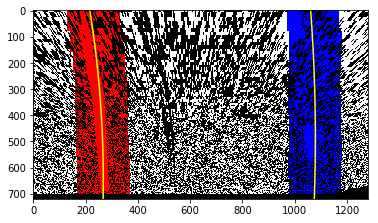

In [54]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane = Lane()

output = 'output_video/output_video1.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(25,45)
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image)
%time out_clip.write_videofile(output, audio=False)